# Исследование оттока клиентов

Заказчик : Телеком


Цель: Cоздание модели прогнозирования оттока клиентов

Примерный план работы:

    1) Знакомство с данными
        - анализ датафреймов 
        - сбор всех датафреймов в один
        - очистка данных + приведение данных в нужный тип(вид)
        - возможно генерация новых фичей
        
    2) Построение нескольких моделей машинного обучения
        - разбиение на тренировочную и тестовую выборки
        - построение моделей
        - расчет accuracy
        
    3) Анализ результатов
        - ROC-AUC
        - признаки
        
    4) Построение наилучшей модели на уточненных данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import shuffle
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

import phik
from phik.report import plot_correlation_matrix

In [2]:
df_contract = pd.read_csv('C://Python//ЯП//final_provider//contract.csv')
df_internet = pd.read_csv('C://Python//ЯП//final_provider//internet.csv')
df_personal = pd.read_csv('C://Python//ЯП//final_provider//personal.csv')
df_phone = pd.read_csv('C://Python//ЯП//final_provider//phone.csv')

## Знакомство с данными

### Анализ датафрейма contract

Обозначения столбцов относительно их названия: 
   - customerID - пользовательские id
   - BeginDate - дата начала
   - EndDate - дата окончания
   - Type - тип
   - PaperlessBilling - Безбумажный биллинг 
   - PaymentMethod - способ оплаты
   - MonthlyCharges - ежемесячные платежи
   - TotalCharges - всего начислений

In [3]:
df_contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


In [4]:
df_contract['target_value']=df_contract['EndDate'].apply(lambda x: 1 if x == 'No' else 0)

In [5]:
df_contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_value
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,0


In [6]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   target_value      7043 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 495.3+ KB


колонку TotalCharges необходимо привести к численному формату, после этого, с помощью .describe() посмотрим основные метрики
колонку BeginDate нужно привести к формату даты

Согласно условию задачи данные актуальны на 1 февраля 2020, поэтому можем заменить No на эту дату

In [7]:
df_contract['EndDate']=df_contract['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)

In [8]:
df_contract['EndDate'].unique()

array(['2020-02-01', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

In [9]:
df_contract['BeginDate'].isnull().sum()

0

In [10]:
df_contract['BeginDate']=pd.to_datetime(df_contract['BeginDate'].astype(str), format='%Y/%m/%d')
df_contract['EndDate']=pd.to_datetime(df_contract['EndDate'].astype(str), format='%Y/%m/%d')


In [11]:
df_contract['time_delta'] = df_contract['EndDate'] - df_contract['BeginDate']
df_contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_value,time_delta
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,1,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,1,1036 days
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,0,61 days


In [12]:
df_contract['time_delta'] = df_contract['time_delta'].astype('str')

In [13]:
df_contract['time_delta'] = df_contract['time_delta'].str.replace(' days','').astype(int)

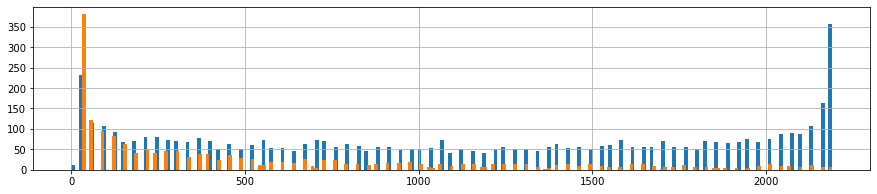

In [14]:
df_contract[df_contract['target_value'] == 1]['time_delta'].hist(bins = 200, figsize = (15, 3));
df_contract[df_contract['target_value'] == 0]['time_delta'].hist(bins = 200, figsize = (15, 3));

Обатим внимание, что отсутствие у таргетной группы ==0 высоких значений time_delta после 2000 можно считать за признак.

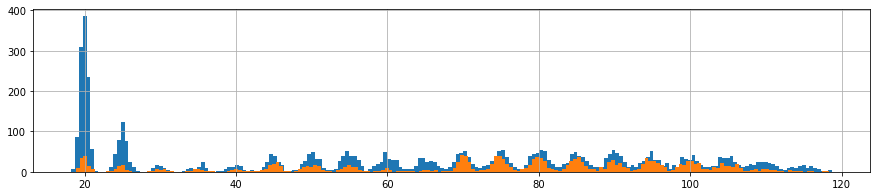

In [15]:
df_contract[df_contract['target_value'] == 1]['MonthlyCharges'].hist(bins = 200, figsize = (15, 3));
df_contract[df_contract['target_value'] == 0]['MonthlyCharges'].hist(bins = 200, figsize = (15, 3));

In [16]:
df_contract['customerID'].duplicated().sum()

0

In [17]:
df_contract.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target_value        0
time_delta          0
dtype: int64

#### Исследование колонки TotalCharges и перевод к численному формату

Попробуем посмотреть какие данные есть в колонке

In [18]:
df_contract['TotalCharges'].value_counts().head(20)

         11
20.2     11
19.75     9
19.9      8
20.05     8
19.65     8
19.55     7
45.3      7
20.15     6
20.25     6
19.45     6
20.45     5
20.3      5
44        4
19.5      4
69.6      4
19.3      4
69.9      4
20.35     4
19.4      4
Name: TotalCharges, dtype: int64

наблюдаем какие то пробелы вместо цифр. Следует задать вопрос "почему так?", но сейчас заменим нулями. (хотя в дальнейшем можно будет их удалить,т.к. потери не большие)

проверим заодно нет ли уже у нас в таблице нулей

In [19]:
df_contract.loc[(df_contract.loc[:,'TotalCharges'] == 0)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_value,time_delta


In [20]:
df_contract.loc[(df_contract.loc[:,'TotalCharges'] == ' ')]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_value,time_delta
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,1,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,1,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,1,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,1,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,1,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,1,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,1,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,1,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,1,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,1,0


нулей нет, можем осуществлять замену

Посмотрим на кол-во строк с пропусками

In [21]:
df_contract.loc[(df_contract.loc[:,'TotalCharges'] == ' ')].count()

customerID          11
BeginDate           11
EndDate             11
Type                11
PaperlessBilling    11
PaymentMethod       11
MonthlyCharges      11
TotalCharges        11
target_value        11
time_delta          11
dtype: int64

их 11

In [22]:
df_contract=df_contract.drop(df_contract.loc[(df_contract.loc[:,'TotalCharges'] == ' ')].index)

удалим

In [23]:
df_contract.loc[(df_contract.loc[:,'TotalCharges'] == ' ')].count()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target_value        0
time_delta          0
dtype: int64

Теперь изменим тип данных этой колонки

In [24]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype(float)

построим гистограмму

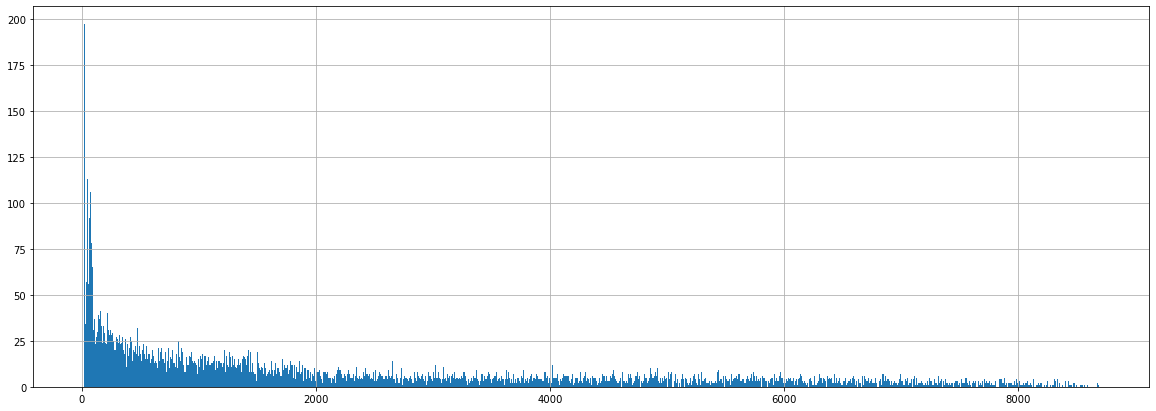

In [25]:
df_contract['TotalCharges'].hist(figsize=(20,7), bins=1000);

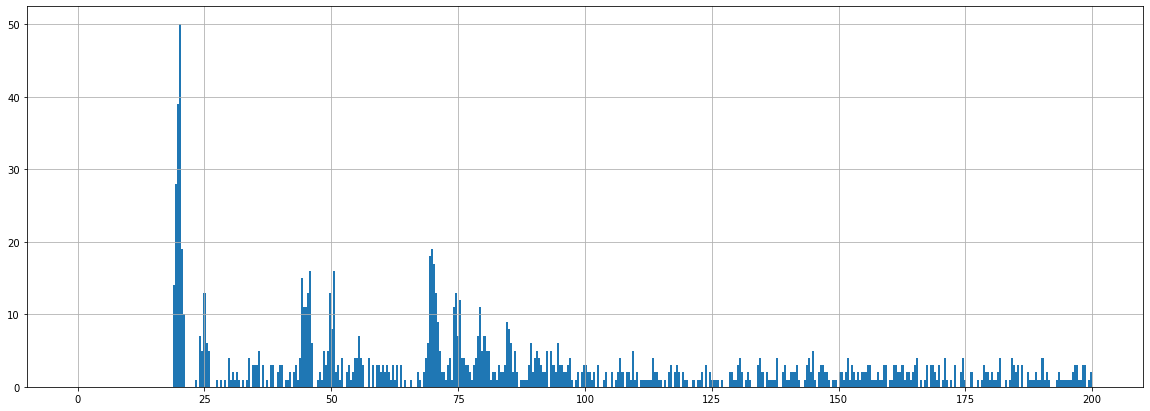

In [26]:
df_contract['TotalCharges'].hist(figsize=(20,7), bins=500, range=(0,200));

При более деттальном рассмотрении увидели что максимумы приходятся окресности чисел 20, 45, 50, 70, 75 . Или если "округлить", то от 20 до 85

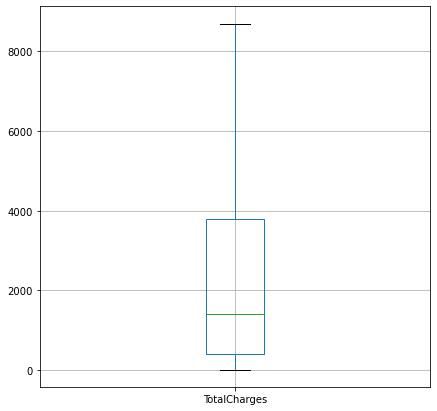

In [27]:
df_contract[['TotalCharges']].boxplot(figsize = (7,7));

Как и собирались, посмотрим основные метрики двух наших числовых столбцов

In [28]:
df_contract.describe()

,MonthlyCharges,TotalCharges,target_value,time_delta
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,0.734215,987.538538
std,30.085974,2266.771362,0.441782,747.153663
min,18.250000,18.800000,0.000000,30.000000
25%,35.587500,401.450000,0.000000,275.000000
50%,70.350000,1397.475000,1.000000,883.000000
75%,89.862500,3794.737500,1.000000,1676.000000
max,118.750000,8684.800000,1.000000,2191.000000


медиана сильно отличается от средней, что может говорить о выбросах

Попробуем сгенерировать еще фичей

In [29]:
df_contract['TotalCharges_id']=df_contract['TotalCharges'].apply(lambda x: 0 if x > 2500 else 1)

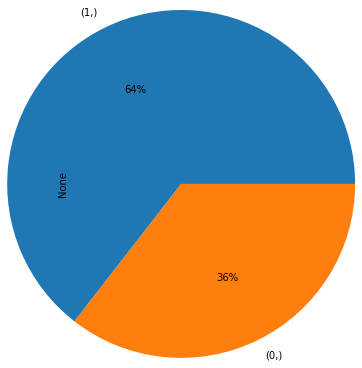

In [30]:
df_contract[['TotalCharges_id']].value_counts().plot.pie(radius=2, autopct='%1.0f%%');

#### Исследование колонки MonthlyCharges

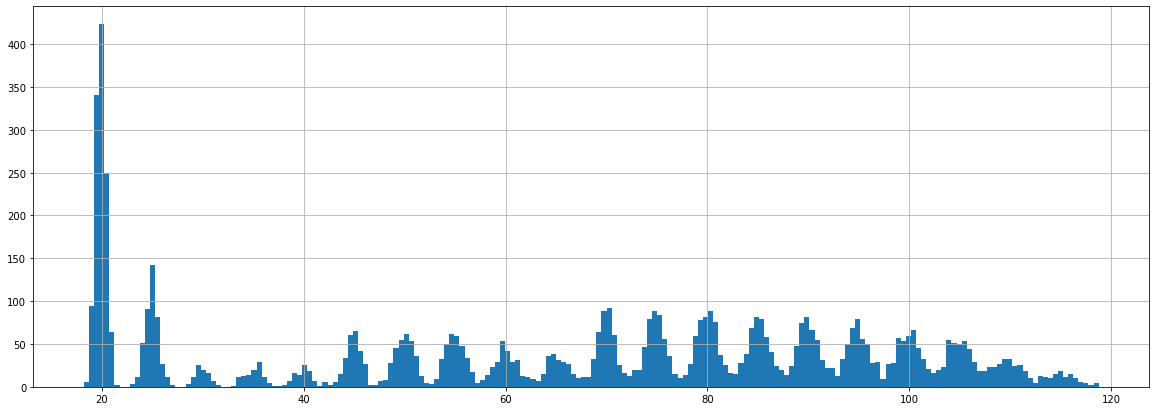

In [31]:
df_contract['MonthlyCharges'].hist(figsize=(20,7), bins=200);

пиковые значения в районе 20

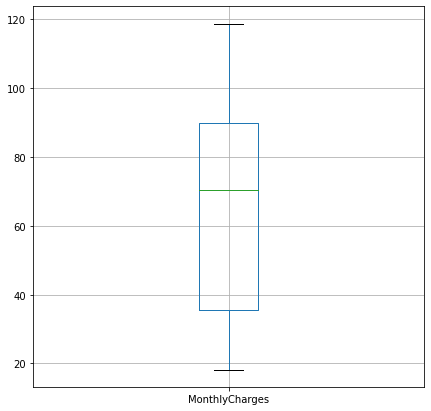

In [32]:
df_contract[['MonthlyCharges']].boxplot(figsize = (7,7));

#### Остальные колонки

 Исследование колонки EndDate

target_value
1               5163
0               1869
dtype: int64


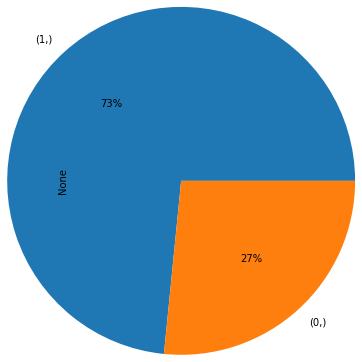

In [33]:
print(df_contract[['target_value']].value_counts())
df_contract[['target_value']].value_counts().plot.pie(radius=2, autopct='%1.0f%%');

У нас явный дисбаланс классов

 Исследование колонки EndDate

EndDate   
2020-02-01    5163
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
dtype: int64


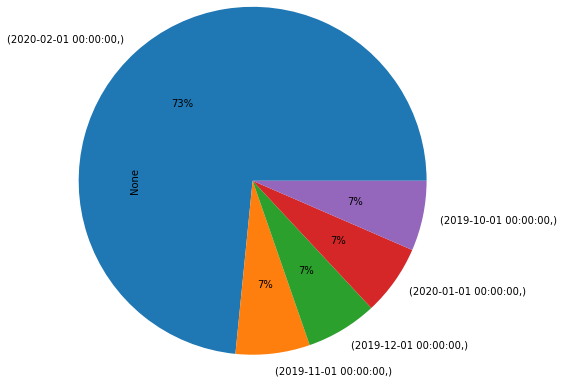

In [34]:
print(df_contract[['EndDate']].value_counts())
df_contract[['EndDate']].value_counts().plot.pie(radius=2, autopct='%1.0f%%');

Большая часть клиентов "No", как я понял, всё еще наши клиенты (не ушли от нас)

И мы видим 4 практически одинаковые волны "уходов" по 7% каждая

Исследование колонки Type

Type          
Month-to-month    3875
Two year          1685
One year          1472
dtype: int64


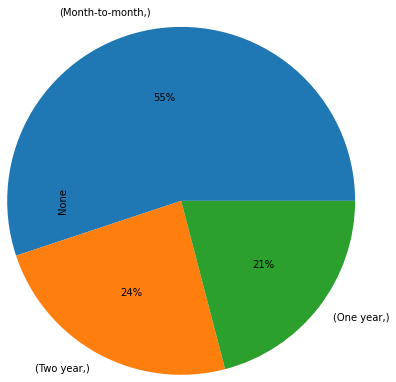

In [35]:
print(df_contract[['Type']].value_counts())
df_contract[['Type']].value_counts().plot.pie(radius=2, autopct='%1.0f%%');

Исследование колонки PaperlessBilling

PaperlessBilling
Yes                 4168
No                  2864
dtype: int64


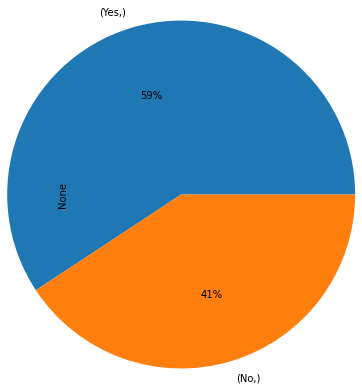

In [36]:
print(df_contract[['PaperlessBilling']].value_counts())
df_contract[['PaperlessBilling']].value_counts().plot.pie(radius=2, autopct='%1.0f%%');

безбумажным биллингом пользуется большая часть пользователей (59%) 

Исследование колонки PaymentMethod

PaymentMethod            
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
dtype: int64


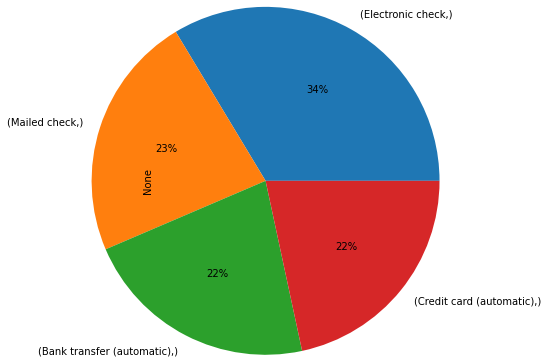

In [37]:
print(df_contract[['PaymentMethod']].value_counts())
df_contract[['PaymentMethod']].value_counts().plot.pie(radius=2, autopct='%1.0f%%');

Электронным чеком пользуется клиентов чуть больше чем остальными вариантами(Mailed check, Bank transfer, Credit card)

## Анализ датафрейма internet

Обозначения столбцов относительно их названия: 
   - customerID - пользовательские id
   - InternetService - интернет служба 
   - OnlineSecurity - интернет безопасность
   - OnlineBackup - Облачное хранилище файлов для резервного копирования данных
   - DeviceProtection - Защита устройства 
   - TechSupport - Техническая поддержка 
   - StreamingTV - Потоковое ТВ 
   - StreamingMovies - Потоковые фильмы 

In [38]:
df_internet.head(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [39]:
df_internet['customerID'].duplicated().sum()

0

In [40]:
df_internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [41]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [42]:
df_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7255-SSFBC,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Большинство параметров нашего датафрейма у нас бинарные(судя по таблице). Напишем функцию, делающую анализ всего датафрейма сразу. Колонку customerID анализировать не будем, т.к. это просто id.

In [43]:
def analiz(dataframe):
    for i in dataframe.columns[1:]:
        print(i)
        print('Анализ колонки: "{:}"'.format(i))
        print(dataframe[i].value_counts())

        plt.figure()
        dataframe[i].value_counts().plot.pie(radius=1, autopct='%1.0f%%')
        plt.show()
        print('')
        print('')

InternetService
Анализ колонки: "InternetService"
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64


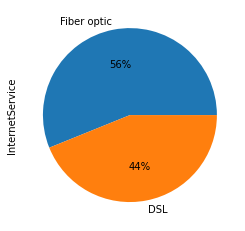



OnlineSecurity
Анализ колонки: "OnlineSecurity"
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64


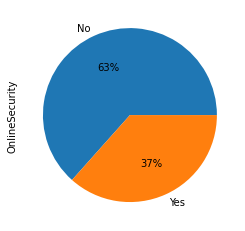



OnlineBackup
Анализ колонки: "OnlineBackup"
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64


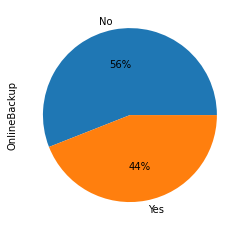



DeviceProtection
Анализ колонки: "DeviceProtection"
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64


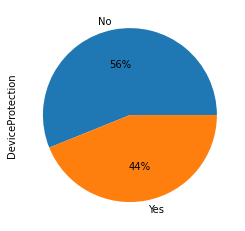



TechSupport
Анализ колонки: "TechSupport"
No     3473
Yes    2044
Name: TechSupport, dtype: int64


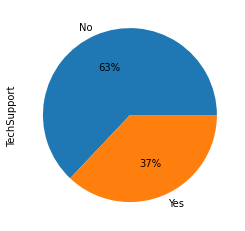



StreamingTV
Анализ колонки: "StreamingTV"
No     2810
Yes    2707
Name: StreamingTV, dtype: int64


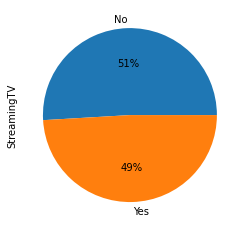



StreamingMovies
Анализ колонки: "StreamingMovies"
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64


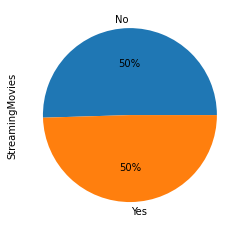

In [44]:
analiz(df_internet)

В целом познакомился с характеристиками.

## Анализ датафрейма personal

Обозначения столбцов относительно их названия: 
   - customerID - пользовательские id
   - SeniorCitizen - пенсионер
   - Partner - женат/не женат
   - Dependents - иждивенцы

In [45]:
df_personal.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [46]:
df_personal['customerID'].duplicated().sum()

0

In [47]:
df_personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

пропусков нет

In [48]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


по типам данных, все ОК

gender
Анализ колонки: "gender"
Male      3555
Female    3488
Name: gender, dtype: int64


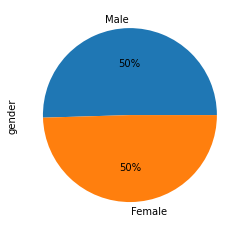



SeniorCitizen
Анализ колонки: "SeniorCitizen"
0    5901
1    1142
Name: SeniorCitizen, dtype: int64


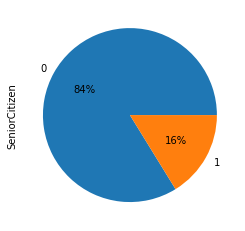



Partner
Анализ колонки: "Partner"
No     3641
Yes    3402
Name: Partner, dtype: int64


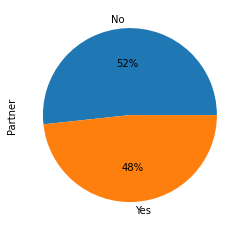



Dependents
Анализ колонки: "Dependents"
No     4933
Yes    2110
Name: Dependents, dtype: int64


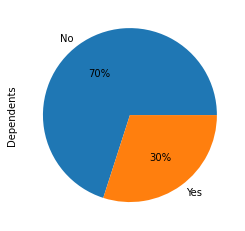

In [49]:
analiz(df_personal)

пенсионеров не так много + иждевенцев треть от всей выборки

## Анализ датафрейма phone

Обозначения столбцов относительно их названия: 
   - customerID - пользовательские id
   - MultipleLines - несколько линий

In [50]:
df_phone.head(3)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


In [51]:
df_phone['customerID'].duplicated().sum()

0

In [52]:
df_phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

In [53]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [54]:
df_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,6873-UDNLD,No
freq,1,3390


MultipleLines
Анализ колонки: "MultipleLines"
No     3390
Yes    2971
Name: MultipleLines, dtype: int64


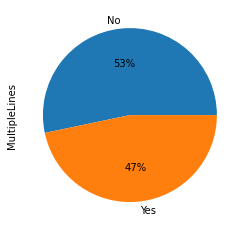

In [55]:
analiz(df_phone)

Объединим наши данные в одну таблицу

In [56]:
df_contract = df_contract.merge(df_internet, on = ['customerID'], how = 'outer')
df_contract = df_contract.merge(df_personal, on = ['customerID'], how = 'outer')
df = df_contract.merge(df_phone, on = ['customerID'], how = 'outer')

In [57]:
df.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_value,time_delta,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,1.0,31.0,...,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,1.0,1036.0,...,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,0.0,61.0,...,Yes,No,No,No,No,Male,0,No,No,No


In [58]:
df.isnull().sum()

customerID             0
BeginDate             11
EndDate               11
Type                  11
PaperlessBilling      11
PaymentMethod         11
MonthlyCharges        11
TotalCharges          11
target_value          11
time_delta            11
TotalCharges_id       11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

In [59]:
df['InternetService'] = df['InternetService'].fillna('N')
df['OnlineSecurity'] = df['OnlineSecurity'].fillna('N')
df['OnlineBackup'] = df['OnlineBackup'].fillna('N')
df['DeviceProtection'] = df['DeviceProtection'].fillna('N')
df['TechSupport'] = df['TechSupport'].fillna('N')
df['StreamingTV'] = df['StreamingTV'].fillna('N')
df['StreamingTV'] = df['StreamingTV'].fillna('N')
df['StreamingMovies'] = df['StreamingMovies'].fillna('N')
df['MultipleLines'] = df['MultipleLines'].fillna('N')

In [60]:
df.isnull().sum()

customerID           0
BeginDate           11
EndDate             11
Type                11
PaperlessBilling    11
PaymentMethod       11
MonthlyCharges      11
TotalCharges        11
target_value        11
time_delta          11
TotalCharges_id     11
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
MultipleLines        0
dtype: int64

In [61]:
df = df.dropna()

In [62]:
df.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target_value        0
time_delta          0
TotalCharges_id     0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64

Посмотрим на корреляцию признаков

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target_value', 'time_delta', 'TotalCharges_id', 'SeniorCitizen']


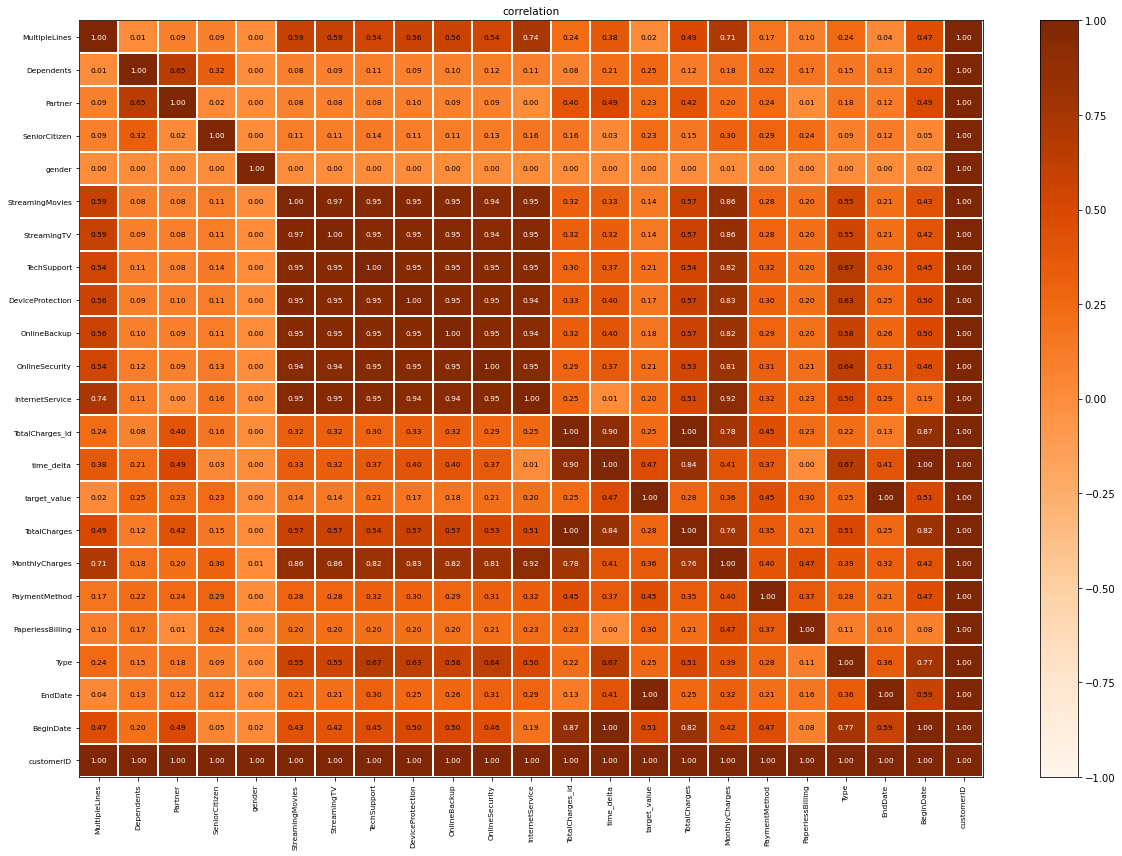

In [63]:
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values,
                       x_labels = phik_overview.columns,
                       y_labels = phik_overview.index,
                       color_map = 'Oranges',
                       fontsize_factor = 0.75,
                       figsize = (17,12))

Очень много всего тут коррелирует. Видимо следовало бы удалить все что коррелирует выше 0.5. В общем то я в конце своей работы так и поступил, оставив только 4 ключевые фичи.

Выводы: Данные подготовили, пропуски обработали, новые фичи сгенерировали

## Обучение моделей

### Подготовка данных для обучения моделей

Удалим лишние фичи. Если  тема наших исследований НЕ временные ряды, то такие факторы не используем. Они "нагонят" метрики, но бизнес-эффективность модели  - упадет.

In [64]:
df=df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [65]:
df.head(3)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target_value,time_delta,TotalCharges_id,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,Month-to-month,Yes,Electronic check,29.85,29.85,1.0,31.0,1.0,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,N
1,One year,No,Mailed check,56.95,1889.50,1.0,1036.0,1.0,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,108.15,0.0,61.0,1.0,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No


Преобразуем наши категориальные данные

In [66]:
df = pd.get_dummies(df, drop_first=True)
df.head(3)

,MonthlyCharges,TotalCharges,target_value,time_delta,TotalCharges_id,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_No,MultipleLines_Yes
0,29.85,29.85,1.0,31.0,1.0,0,0,0,1,0,...,0,1,0,1,0,0,1,0,0,0
1,56.95,1889.50,1.0,1036.0,1.0,0,1,0,0,0,...,0,1,0,1,0,1,0,0,1,0
2,53.85,108.15,0.0,61.0,1.0,0,0,0,1,0,...,0,1,0,1,0,1,0,0,1,0


Посмотрим на матрицу корреляции полученных фичей

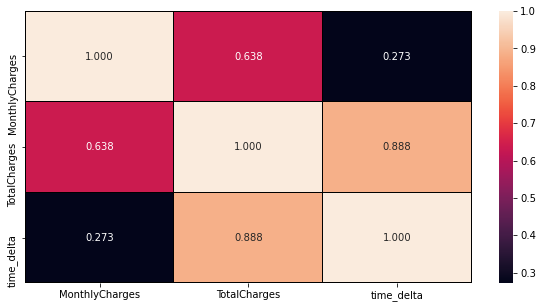

In [67]:
plt.figure(figsize=(10, 5))
sns.heatmap(df[['MonthlyCharges','TotalCharges', 'time_delta']].corr(method='spearman'), annot=True, fmt='.3f', linecolor='black', linewidths=0.1);

Обратили внимание что некоторые фичи сильно коррелируют друг с другом, при этом корреляция с целевым признаком не очень высокая. Удалим TotalCharges, т.к. мы знаем что time_delta это наша ключевой признак, а TotalCharges мы категоризировали в TotalCharges_id

In [68]:
df = df.drop(['TotalCharges'], axis=1)    

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7032 non-null   float64
 1   target_value                           7032 non-null   float64
 2   time_delta                             7032 non-null   float64
 3   TotalCharges_id                        7032 non-null   float64
 4   SeniorCitizen                          7032 non-null   int64  
 5   Type_One year                          7032 non-null   uint8  
 6   Type_Two year                          7032 non-null   uint8  
 7   PaperlessBilling_Yes                   7032 non-null   uint8  
 8   PaymentMethod_Credit card (automatic)  7032 non-null   uint8  
 9   PaymentMethod_Electronic check         7032 non-null   uint8  
 10  PaymentMethod_Mailed check             7032 non-null   uint8  
 11  Inte

Скопируем наши обработанные данные чтобы потом на них обучить наши модели-лидеры

In [70]:
df_copy = df.copy()

 ### Разбивка данных

In [71]:
target = df['target_value']
features = df.drop('target_value', axis=1)

In [72]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

In [73]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.25, random_state=12345)

In [74]:
target_train.value_counts()

1.0    3110
0.0    1108
Name: target_value, dtype: int64

дисбаланс 1 к 3

Сделаем наши выборки более равновесными, увеличив "отстающую"

In [75]:
def upsample(features, target, repeat):
    features_zeros = features[target == 1]
    features_ones = features[target == 0]
    target_zeros = target[target == 1]
    target_ones = target[target == 0]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [76]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

In [77]:
target_upsampled.value_counts()

0.0    3324
1.0    3110
Name: target_value, dtype: int64

теперь баланс классов соблюдён

 Это списки для анализа точности и скорости работы моделей. Пока не успел реализовать, к этапу выводов надеюсь доделать

In [78]:
time_value = []
RMSE_value = []
model = []

#### CatBoostClassifier

Закомментировал поиск по GridSearchCV т.к. работает очень долго

In [79]:
#start_time = time.time()
#cat = GridSearchCV(estimator=CatBoostClassifier(iterations  = 700),
#                   param_grid={"learning_rate": (0.05, 0.1, 0.2, 0.3, 0.4),
#                               "max_depth": [3, 5, 7, 9, 12, 15]},
#            cv=5, verbose=0, n_jobs=-1)
#
#grid_result = cat.fit(features_upsampled, target_upsampled)
#print(f'Лучшие параметры модели {grid_result.best_params_}')


##time_value.append(time.time() - start_time)
##RMSE_value.append(accuracy)
##model.append('CatBoostRegressor')

In [80]:
start_time = time.time()

cat = GridSearchCV(estimator=CatBoostClassifier(iterations  = 10000, learning_rate = 0.025, max_depth = 4),
                   param_grid={},
            cv=5, verbose=0, n_jobs=-1)

grid_result = cat.fit(features_upsampled, target_upsampled)

pred_valid = grid_result.predict(features_valid)
accuracy = accuracy_score(target_valid, pred_valid)
print(accuracy)
time_value.append(time.time() - start_time)
RMSE_value.append(accuracy)
model.append('CatBoostRegressor')

0:	learn: 0.6822194	total: 171ms	remaining: 28m 26s
1:	learn: 0.6736029	total: 172ms	remaining: 14m 19s
2:	learn: 0.6640885	total: 173ms	remaining: 9m 37s
3:	learn: 0.6556810	total: 174ms	remaining: 7m 15s
4:	learn: 0.6477987	total: 175ms	remaining: 5m 50s
5:	learn: 0.6393634	total: 177ms	remaining: 4m 54s
6:	learn: 0.6327247	total: 178ms	remaining: 4m 13s
7:	learn: 0.6261403	total: 179ms	remaining: 3m 43s
8:	learn: 0.6197011	total: 180ms	remaining: 3m 19s
9:	learn: 0.6138016	total: 181ms	remaining: 3m
10:	learn: 0.6078971	total: 182ms	remaining: 2m 45s
11:	learn: 0.6026221	total: 183ms	remaining: 2m 32s
12:	learn: 0.5972706	total: 184ms	remaining: 2m 21s
13:	learn: 0.5920649	total: 185ms	remaining: 2m 12s
14:	learn: 0.5875812	total: 186ms	remaining: 2m 4s
15:	learn: 0.5826099	total: 188ms	remaining: 1m 57s
16:	learn: 0.5785402	total: 189ms	remaining: 1m 50s
17:	learn: 0.5749167	total: 190ms	remaining: 1m 45s
18:	learn: 0.5711391	total: 191ms	remaining: 1m 40s
19:	learn: 0.5673670	tota

301:	learn: 0.4110258	total: 514ms	remaining: 16.5s
302:	learn: 0.4107128	total: 515ms	remaining: 16.5s
303:	learn: 0.4100496	total: 516ms	remaining: 16.5s
304:	learn: 0.4098835	total: 517ms	remaining: 16.4s
305:	learn: 0.4098103	total: 519ms	remaining: 16.4s
306:	learn: 0.4097348	total: 520ms	remaining: 16.4s
307:	learn: 0.4096502	total: 521ms	remaining: 16.4s
308:	learn: 0.4095377	total: 522ms	remaining: 16.4s
309:	learn: 0.4094065	total: 523ms	remaining: 16.3s
310:	learn: 0.4093407	total: 524ms	remaining: 16.3s
311:	learn: 0.4092054	total: 525ms	remaining: 16.3s
312:	learn: 0.4089979	total: 526ms	remaining: 16.3s
313:	learn: 0.4088692	total: 528ms	remaining: 16.3s
314:	learn: 0.4087077	total: 529ms	remaining: 16.3s
315:	learn: 0.4086533	total: 530ms	remaining: 16.2s
316:	learn: 0.4085325	total: 531ms	remaining: 16.2s
317:	learn: 0.4083319	total: 532ms	remaining: 16.2s
318:	learn: 0.4081957	total: 533ms	remaining: 16.2s
319:	learn: 0.4081001	total: 534ms	remaining: 16.2s
320:	learn: 

595:	learn: 0.3548628	total: 850ms	remaining: 13.4s
596:	learn: 0.3546284	total: 851ms	remaining: 13.4s
597:	learn: 0.3544807	total: 852ms	remaining: 13.4s
598:	learn: 0.3542953	total: 854ms	remaining: 13.4s
599:	learn: 0.3541569	total: 855ms	remaining: 13.4s
600:	learn: 0.3539971	total: 856ms	remaining: 13.4s
601:	learn: 0.3538604	total: 857ms	remaining: 13.4s
602:	learn: 0.3535928	total: 858ms	remaining: 13.4s
603:	learn: 0.3533450	total: 859ms	remaining: 13.4s
604:	learn: 0.3530789	total: 860ms	remaining: 13.4s
605:	learn: 0.3529931	total: 862ms	remaining: 13.4s
606:	learn: 0.3528204	total: 863ms	remaining: 13.4s
607:	learn: 0.3527181	total: 864ms	remaining: 13.3s
608:	learn: 0.3525667	total: 865ms	remaining: 13.3s
609:	learn: 0.3524616	total: 866ms	remaining: 13.3s
610:	learn: 0.3523385	total: 867ms	remaining: 13.3s
611:	learn: 0.3521840	total: 869ms	remaining: 13.3s
612:	learn: 0.3520747	total: 870ms	remaining: 13.3s
613:	learn: 0.3519776	total: 871ms	remaining: 13.3s
614:	learn: 

884:	learn: 0.3097602	total: 1.19s	remaining: 12.2s
885:	learn: 0.3096435	total: 1.19s	remaining: 12.2s
886:	learn: 0.3095689	total: 1.19s	remaining: 12.2s
887:	learn: 0.3094330	total: 1.19s	remaining: 12.2s
888:	learn: 0.3093170	total: 1.19s	remaining: 12.2s
889:	learn: 0.3091553	total: 1.19s	remaining: 12.2s
890:	learn: 0.3089329	total: 1.19s	remaining: 12.2s
891:	learn: 0.3088514	total: 1.19s	remaining: 12.2s
892:	learn: 0.3086798	total: 1.19s	remaining: 12.2s
893:	learn: 0.3085662	total: 1.2s	remaining: 12.2s
894:	learn: 0.3083694	total: 1.2s	remaining: 12.2s
895:	learn: 0.3081006	total: 1.2s	remaining: 12.2s
896:	learn: 0.3079243	total: 1.2s	remaining: 12.2s
897:	learn: 0.3078683	total: 1.2s	remaining: 12.2s
898:	learn: 0.3077954	total: 1.2s	remaining: 12.2s
899:	learn: 0.3077134	total: 1.2s	remaining: 12.2s
900:	learn: 0.3076276	total: 1.2s	remaining: 12.2s
901:	learn: 0.3075564	total: 1.21s	remaining: 12.2s
902:	learn: 0.3074843	total: 1.21s	remaining: 12.2s
903:	learn: 0.307433

1183:	learn: 0.2789035	total: 1.53s	remaining: 11.4s
1184:	learn: 0.2787861	total: 1.53s	remaining: 11.4s
1185:	learn: 0.2786435	total: 1.53s	remaining: 11.4s
1186:	learn: 0.2785631	total: 1.53s	remaining: 11.4s
1187:	learn: 0.2785206	total: 1.53s	remaining: 11.4s
1188:	learn: 0.2782090	total: 1.53s	remaining: 11.4s
1189:	learn: 0.2781339	total: 1.53s	remaining: 11.4s
1190:	learn: 0.2779857	total: 1.54s	remaining: 11.4s
1191:	learn: 0.2777990	total: 1.54s	remaining: 11.4s
1192:	learn: 0.2777389	total: 1.54s	remaining: 11.4s
1193:	learn: 0.2776713	total: 1.54s	remaining: 11.4s
1194:	learn: 0.2775414	total: 1.54s	remaining: 11.4s
1195:	learn: 0.2774854	total: 1.54s	remaining: 11.4s
1196:	learn: 0.2774102	total: 1.54s	remaining: 11.4s
1197:	learn: 0.2772480	total: 1.54s	remaining: 11.4s
1198:	learn: 0.2771861	total: 1.55s	remaining: 11.3s
1199:	learn: 0.2771456	total: 1.55s	remaining: 11.3s
1200:	learn: 0.2770669	total: 1.55s	remaining: 11.3s
1201:	learn: 0.2770099	total: 1.55s	remaining:

1478:	learn: 0.2555780	total: 1.86s	remaining: 10.7s
1479:	learn: 0.2555114	total: 1.86s	remaining: 10.7s
1480:	learn: 0.2554577	total: 1.87s	remaining: 10.7s
1481:	learn: 0.2554118	total: 1.87s	remaining: 10.7s
1482:	learn: 0.2553746	total: 1.87s	remaining: 10.7s
1483:	learn: 0.2552624	total: 1.87s	remaining: 10.7s
1484:	learn: 0.2552073	total: 1.87s	remaining: 10.7s
1485:	learn: 0.2551393	total: 1.87s	remaining: 10.7s
1486:	learn: 0.2550764	total: 1.87s	remaining: 10.7s
1487:	learn: 0.2550337	total: 1.87s	remaining: 10.7s
1488:	learn: 0.2549797	total: 1.88s	remaining: 10.7s
1489:	learn: 0.2548956	total: 1.88s	remaining: 10.7s
1490:	learn: 0.2548373	total: 1.88s	remaining: 10.7s
1491:	learn: 0.2547464	total: 1.88s	remaining: 10.7s
1492:	learn: 0.2546835	total: 1.88s	remaining: 10.7s
1493:	learn: 0.2546254	total: 1.88s	remaining: 10.7s
1494:	learn: 0.2545506	total: 1.88s	remaining: 10.7s
1495:	learn: 0.2544535	total: 1.88s	remaining: 10.7s
1496:	learn: 0.2543948	total: 1.88s	remaining:

1788:	learn: 0.2353783	total: 2.21s	remaining: 10.2s
1789:	learn: 0.2352928	total: 2.22s	remaining: 10.2s
1790:	learn: 0.2352394	total: 2.22s	remaining: 10.2s
1791:	learn: 0.2351790	total: 2.22s	remaining: 10.2s
1792:	learn: 0.2351242	total: 2.22s	remaining: 10.2s
1793:	learn: 0.2350965	total: 2.22s	remaining: 10.2s
1794:	learn: 0.2350422	total: 2.22s	remaining: 10.2s
1795:	learn: 0.2349550	total: 2.22s	remaining: 10.2s
1796:	learn: 0.2349139	total: 2.22s	remaining: 10.2s
1797:	learn: 0.2348540	total: 2.23s	remaining: 10.2s
1798:	learn: 0.2348220	total: 2.23s	remaining: 10.2s
1799:	learn: 0.2347521	total: 2.23s	remaining: 10.1s
1800:	learn: 0.2347183	total: 2.23s	remaining: 10.1s
1801:	learn: 0.2346828	total: 2.23s	remaining: 10.1s
1802:	learn: 0.2346375	total: 2.23s	remaining: 10.1s
1803:	learn: 0.2346157	total: 2.23s	remaining: 10.1s
1804:	learn: 0.2345590	total: 2.23s	remaining: 10.1s
1805:	learn: 0.2345148	total: 2.23s	remaining: 10.1s
1806:	learn: 0.2344582	total: 2.23s	remaining:

2079:	learn: 0.2195861	total: 2.55s	remaining: 9.71s
2080:	learn: 0.2195436	total: 2.55s	remaining: 9.71s
2081:	learn: 0.2194822	total: 2.55s	remaining: 9.71s
2082:	learn: 0.2194509	total: 2.55s	remaining: 9.71s
2083:	learn: 0.2194187	total: 2.56s	remaining: 9.71s
2084:	learn: 0.2193741	total: 2.56s	remaining: 9.7s
2085:	learn: 0.2193157	total: 2.56s	remaining: 9.7s
2086:	learn: 0.2192921	total: 2.56s	remaining: 9.7s
2087:	learn: 0.2192390	total: 2.56s	remaining: 9.7s
2088:	learn: 0.2191956	total: 2.56s	remaining: 9.7s
2089:	learn: 0.2191755	total: 2.56s	remaining: 9.7s
2090:	learn: 0.2191276	total: 2.56s	remaining: 9.7s
2091:	learn: 0.2190966	total: 2.56s	remaining: 9.69s
2092:	learn: 0.2190552	total: 2.56s	remaining: 9.69s
2093:	learn: 0.2190101	total: 2.57s	remaining: 9.69s
2094:	learn: 0.2189735	total: 2.57s	remaining: 9.69s
2095:	learn: 0.2189368	total: 2.57s	remaining: 9.69s
2096:	learn: 0.2189058	total: 2.57s	remaining: 9.69s
2097:	learn: 0.2188504	total: 2.57s	remaining: 9.68s


2376:	learn: 0.2050990	total: 2.9s	remaining: 9.29s
2377:	learn: 0.2050667	total: 2.9s	remaining: 9.29s
2378:	learn: 0.2050086	total: 2.9s	remaining: 9.28s
2379:	learn: 0.2049649	total: 2.9s	remaining: 9.28s
2380:	learn: 0.2048954	total: 2.9s	remaining: 9.28s
2381:	learn: 0.2048223	total: 2.9s	remaining: 9.28s
2382:	learn: 0.2047841	total: 2.9s	remaining: 9.28s
2383:	learn: 0.2047075	total: 2.9s	remaining: 9.28s
2384:	learn: 0.2046711	total: 2.9s	remaining: 9.27s
2385:	learn: 0.2046223	total: 2.91s	remaining: 9.27s
2386:	learn: 0.2045803	total: 2.91s	remaining: 9.27s
2387:	learn: 0.2045431	total: 2.91s	remaining: 9.27s
2388:	learn: 0.2045137	total: 2.91s	remaining: 9.27s
2389:	learn: 0.2044430	total: 2.91s	remaining: 9.27s
2390:	learn: 0.2043763	total: 2.91s	remaining: 9.27s
2391:	learn: 0.2042926	total: 2.91s	remaining: 9.26s
2392:	learn: 0.2042084	total: 2.91s	remaining: 9.26s
2393:	learn: 0.2041717	total: 2.92s	remaining: 9.26s
2394:	learn: 0.2041363	total: 2.92s	remaining: 9.26s
23

2668:	learn: 0.1928782	total: 3.23s	remaining: 8.88s
2669:	learn: 0.1928376	total: 3.23s	remaining: 8.87s
2670:	learn: 0.1928113	total: 3.23s	remaining: 8.87s
2671:	learn: 0.1927855	total: 3.23s	remaining: 8.87s
2672:	learn: 0.1927548	total: 3.23s	remaining: 8.87s
2673:	learn: 0.1927091	total: 3.24s	remaining: 8.87s
2674:	learn: 0.1926807	total: 3.24s	remaining: 8.87s
2675:	learn: 0.1926278	total: 3.24s	remaining: 8.87s
2676:	learn: 0.1925809	total: 3.24s	remaining: 8.86s
2677:	learn: 0.1925601	total: 3.24s	remaining: 8.86s
2678:	learn: 0.1925280	total: 3.24s	remaining: 8.86s
2679:	learn: 0.1925074	total: 3.24s	remaining: 8.86s
2680:	learn: 0.1924826	total: 3.24s	remaining: 8.86s
2681:	learn: 0.1924557	total: 3.25s	remaining: 8.86s
2682:	learn: 0.1923957	total: 3.25s	remaining: 8.86s
2683:	learn: 0.1923402	total: 3.25s	remaining: 8.85s
2684:	learn: 0.1922985	total: 3.25s	remaining: 8.85s
2685:	learn: 0.1922596	total: 3.25s	remaining: 8.85s
2686:	learn: 0.1922293	total: 3.25s	remaining:

2965:	learn: 0.1827150	total: 3.57s	remaining: 8.46s
2966:	learn: 0.1826814	total: 3.57s	remaining: 8.46s
2967:	learn: 0.1826457	total: 3.57s	remaining: 8.46s
2968:	learn: 0.1825970	total: 3.57s	remaining: 8.46s
2969:	learn: 0.1825576	total: 3.57s	remaining: 8.46s
2970:	learn: 0.1825186	total: 3.57s	remaining: 8.45s
2971:	learn: 0.1824725	total: 3.57s	remaining: 8.45s
2972:	learn: 0.1824536	total: 3.58s	remaining: 8.45s
2973:	learn: 0.1824380	total: 3.58s	remaining: 8.45s
2974:	learn: 0.1824167	total: 3.58s	remaining: 8.45s
2975:	learn: 0.1823945	total: 3.58s	remaining: 8.45s
2976:	learn: 0.1823855	total: 3.58s	remaining: 8.45s
2977:	learn: 0.1823566	total: 3.58s	remaining: 8.44s
2978:	learn: 0.1823256	total: 3.58s	remaining: 8.44s
2979:	learn: 0.1823047	total: 3.58s	remaining: 8.44s
2980:	learn: 0.1822827	total: 3.58s	remaining: 8.44s
2981:	learn: 0.1822630	total: 3.58s	remaining: 8.44s
2982:	learn: 0.1822407	total: 3.59s	remaining: 8.44s
2983:	learn: 0.1822041	total: 3.59s	remaining:

3125:	learn: 0.1775409	total: 3.75s	remaining: 8.25s
3126:	learn: 0.1775051	total: 3.75s	remaining: 8.24s
3127:	learn: 0.1774805	total: 3.75s	remaining: 8.24s
3128:	learn: 0.1774570	total: 3.75s	remaining: 8.24s
3129:	learn: 0.1774275	total: 3.75s	remaining: 8.24s
3130:	learn: 0.1773420	total: 3.76s	remaining: 8.24s
3131:	learn: 0.1773193	total: 3.76s	remaining: 8.24s
3132:	learn: 0.1772873	total: 3.76s	remaining: 8.24s
3133:	learn: 0.1772680	total: 3.76s	remaining: 8.24s
3134:	learn: 0.1771989	total: 3.76s	remaining: 8.23s
3135:	learn: 0.1771722	total: 3.76s	remaining: 8.23s
3136:	learn: 0.1771294	total: 3.76s	remaining: 8.23s
3137:	learn: 0.1770870	total: 3.76s	remaining: 8.23s
3138:	learn: 0.1770407	total: 3.77s	remaining: 8.23s
3139:	learn: 0.1770010	total: 3.77s	remaining: 8.23s
3140:	learn: 0.1769518	total: 3.77s	remaining: 8.23s
3141:	learn: 0.1769183	total: 3.77s	remaining: 8.23s
3142:	learn: 0.1768804	total: 3.77s	remaining: 8.22s
3143:	learn: 0.1767864	total: 3.77s	remaining:

3417:	learn: 0.1682363	total: 4.09s	remaining: 7.87s
3418:	learn: 0.1682032	total: 4.09s	remaining: 7.87s
3419:	learn: 0.1681837	total: 4.09s	remaining: 7.87s
3420:	learn: 0.1681416	total: 4.09s	remaining: 7.87s
3421:	learn: 0.1681074	total: 4.09s	remaining: 7.87s
3422:	learn: 0.1680616	total: 4.09s	remaining: 7.86s
3423:	learn: 0.1680331	total: 4.09s	remaining: 7.86s
3424:	learn: 0.1680116	total: 4.09s	remaining: 7.86s
3425:	learn: 0.1679450	total: 4.1s	remaining: 7.86s
3426:	learn: 0.1679210	total: 4.1s	remaining: 7.86s
3427:	learn: 0.1678858	total: 4.1s	remaining: 7.86s
3428:	learn: 0.1678653	total: 4.1s	remaining: 7.86s
3429:	learn: 0.1678289	total: 4.1s	remaining: 7.86s
3430:	learn: 0.1678047	total: 4.1s	remaining: 7.85s
3431:	learn: 0.1677714	total: 4.1s	remaining: 7.85s
3432:	learn: 0.1677578	total: 4.1s	remaining: 7.85s
3433:	learn: 0.1677232	total: 4.11s	remaining: 7.85s
3434:	learn: 0.1677110	total: 4.11s	remaining: 7.85s
3435:	learn: 0.1676923	total: 4.11s	remaining: 7.85s
3

3720:	learn: 0.1599614	total: 4.43s	remaining: 7.48s
3721:	learn: 0.1599362	total: 4.43s	remaining: 7.48s
3722:	learn: 0.1599176	total: 4.43s	remaining: 7.48s
3723:	learn: 0.1598677	total: 4.44s	remaining: 7.48s
3724:	learn: 0.1598457	total: 4.44s	remaining: 7.48s
3725:	learn: 0.1598324	total: 4.45s	remaining: 7.49s
3726:	learn: 0.1598020	total: 4.45s	remaining: 7.49s
3727:	learn: 0.1597767	total: 4.46s	remaining: 7.5s
3728:	learn: 0.1597558	total: 4.46s	remaining: 7.5s
3729:	learn: 0.1597356	total: 4.46s	remaining: 7.5s
3730:	learn: 0.1596649	total: 4.46s	remaining: 7.5s
3731:	learn: 0.1596462	total: 4.46s	remaining: 7.5s
3732:	learn: 0.1596360	total: 4.47s	remaining: 7.5s
3733:	learn: 0.1596248	total: 4.47s	remaining: 7.5s
3734:	learn: 0.1596094	total: 4.47s	remaining: 7.5s
3735:	learn: 0.1595811	total: 4.47s	remaining: 7.5s
3736:	learn: 0.1595029	total: 4.47s	remaining: 7.5s
3737:	learn: 0.1594805	total: 4.48s	remaining: 7.5s
3738:	learn: 0.1594616	total: 4.48s	remaining: 7.5s
3739:

3993:	learn: 0.1532091	total: 4.77s	remaining: 7.17s
3994:	learn: 0.1531659	total: 4.77s	remaining: 7.17s
3995:	learn: 0.1531496	total: 4.77s	remaining: 7.17s
3996:	learn: 0.1531193	total: 4.77s	remaining: 7.17s
3997:	learn: 0.1530974	total: 4.77s	remaining: 7.17s
3998:	learn: 0.1530708	total: 4.78s	remaining: 7.17s
3999:	learn: 0.1530572	total: 4.78s	remaining: 7.17s
4000:	learn: 0.1530365	total: 4.78s	remaining: 7.16s
4001:	learn: 0.1530245	total: 4.78s	remaining: 7.16s
4002:	learn: 0.1529976	total: 4.78s	remaining: 7.16s
4003:	learn: 0.1529808	total: 4.78s	remaining: 7.16s
4004:	learn: 0.1529631	total: 4.78s	remaining: 7.16s
4005:	learn: 0.1529487	total: 4.78s	remaining: 7.16s
4006:	learn: 0.1529260	total: 4.79s	remaining: 7.16s
4007:	learn: 0.1529093	total: 4.79s	remaining: 7.16s
4008:	learn: 0.1528770	total: 4.79s	remaining: 7.15s
4009:	learn: 0.1528600	total: 4.79s	remaining: 7.15s
4010:	learn: 0.1528431	total: 4.79s	remaining: 7.15s
4011:	learn: 0.1528257	total: 4.79s	remaining:

4289:	learn: 0.1459393	total: 5.11s	remaining: 6.8s
4290:	learn: 0.1459239	total: 5.11s	remaining: 6.8s
4291:	learn: 0.1458792	total: 5.11s	remaining: 6.79s
4292:	learn: 0.1458468	total: 5.11s	remaining: 6.79s
4293:	learn: 0.1458350	total: 5.11s	remaining: 6.79s
4294:	learn: 0.1458169	total: 5.11s	remaining: 6.79s
4295:	learn: 0.1457859	total: 5.11s	remaining: 6.79s
4296:	learn: 0.1457677	total: 5.12s	remaining: 6.79s
4297:	learn: 0.1457482	total: 5.12s	remaining: 6.79s
4298:	learn: 0.1457232	total: 5.12s	remaining: 6.79s
4299:	learn: 0.1456807	total: 5.12s	remaining: 6.79s
4300:	learn: 0.1456306	total: 5.12s	remaining: 6.78s
4301:	learn: 0.1456009	total: 5.12s	remaining: 6.78s
4302:	learn: 0.1455833	total: 5.12s	remaining: 6.78s
4303:	learn: 0.1455569	total: 5.12s	remaining: 6.78s
4304:	learn: 0.1455178	total: 5.12s	remaining: 6.78s
4305:	learn: 0.1455021	total: 5.13s	remaining: 6.78s
4306:	learn: 0.1454840	total: 5.13s	remaining: 6.78s
4307:	learn: 0.1454749	total: 5.13s	remaining: 6

4449:	learn: 0.1419397	total: 5.29s	remaining: 6.6s
4450:	learn: 0.1419155	total: 5.29s	remaining: 6.6s
4451:	learn: 0.1418922	total: 5.29s	remaining: 6.6s
4452:	learn: 0.1418520	total: 5.29s	remaining: 6.59s
4453:	learn: 0.1418133	total: 5.29s	remaining: 6.59s
4454:	learn: 0.1417956	total: 5.3s	remaining: 6.59s
4455:	learn: 0.1417732	total: 5.3s	remaining: 6.59s
4456:	learn: 0.1417650	total: 5.3s	remaining: 6.59s
4457:	learn: 0.1417436	total: 5.3s	remaining: 6.59s
4458:	learn: 0.1417093	total: 5.3s	remaining: 6.59s
4459:	learn: 0.1416902	total: 5.3s	remaining: 6.58s
4460:	learn: 0.1416562	total: 5.3s	remaining: 6.58s
4461:	learn: 0.1416321	total: 5.3s	remaining: 6.58s
4462:	learn: 0.1416204	total: 5.3s	remaining: 6.58s
4463:	learn: 0.1415735	total: 5.31s	remaining: 6.58s
4464:	learn: 0.1415635	total: 5.31s	remaining: 6.58s
4465:	learn: 0.1415012	total: 5.31s	remaining: 6.58s
4466:	learn: 0.1414850	total: 5.31s	remaining: 6.58s
4467:	learn: 0.1414595	total: 5.31s	remaining: 6.58s
4468:

4732:	learn: 0.1361540	total: 5.62s	remaining: 6.25s
4733:	learn: 0.1361334	total: 5.62s	remaining: 6.25s
4734:	learn: 0.1361217	total: 5.62s	remaining: 6.25s
4735:	learn: 0.1361020	total: 5.62s	remaining: 6.25s
4736:	learn: 0.1360924	total: 5.62s	remaining: 6.25s
4737:	learn: 0.1360765	total: 5.62s	remaining: 6.25s
4738:	learn: 0.1360580	total: 5.62s	remaining: 6.24s
4739:	learn: 0.1360410	total: 5.63s	remaining: 6.24s
4740:	learn: 0.1360114	total: 5.63s	remaining: 6.24s
4741:	learn: 0.1359903	total: 5.63s	remaining: 6.24s
4742:	learn: 0.1359753	total: 5.63s	remaining: 6.24s
4743:	learn: 0.1359583	total: 5.63s	remaining: 6.24s
4744:	learn: 0.1359499	total: 5.63s	remaining: 6.24s
4745:	learn: 0.1359330	total: 5.63s	remaining: 6.24s
4746:	learn: 0.1359150	total: 5.63s	remaining: 6.23s
4747:	learn: 0.1358818	total: 5.63s	remaining: 6.23s
4748:	learn: 0.1358676	total: 5.64s	remaining: 6.23s
4749:	learn: 0.1358341	total: 5.64s	remaining: 6.23s
4750:	learn: 0.1358145	total: 5.64s	remaining:

5036:	learn: 0.1303116	total: 5.97s	remaining: 5.88s
5037:	learn: 0.1302808	total: 5.97s	remaining: 5.88s
5038:	learn: 0.1302627	total: 5.97s	remaining: 5.88s
5039:	learn: 0.1302400	total: 5.97s	remaining: 5.88s
5040:	learn: 0.1302213	total: 5.97s	remaining: 5.87s
5041:	learn: 0.1302096	total: 5.97s	remaining: 5.87s
5042:	learn: 0.1301979	total: 5.97s	remaining: 5.87s
5043:	learn: 0.1301793	total: 5.97s	remaining: 5.87s
5044:	learn: 0.1301658	total: 5.97s	remaining: 5.87s
5045:	learn: 0.1301483	total: 5.98s	remaining: 5.87s
5046:	learn: 0.1301336	total: 5.98s	remaining: 5.87s
5047:	learn: 0.1300973	total: 5.98s	remaining: 5.87s
5048:	learn: 0.1300487	total: 5.98s	remaining: 5.86s
5049:	learn: 0.1300316	total: 5.98s	remaining: 5.86s
5050:	learn: 0.1300199	total: 5.98s	remaining: 5.86s
5051:	learn: 0.1300133	total: 5.98s	remaining: 5.86s
5052:	learn: 0.1299891	total: 5.98s	remaining: 5.86s
5053:	learn: 0.1299719	total: 5.99s	remaining: 5.86s
5054:	learn: 0.1299521	total: 5.99s	remaining:

5331:	learn: 0.1250668	total: 6.3s	remaining: 5.52s
5332:	learn: 0.1250519	total: 6.3s	remaining: 5.51s
5333:	learn: 0.1250264	total: 6.3s	remaining: 5.51s
5334:	learn: 0.1249962	total: 6.3s	remaining: 5.51s
5335:	learn: 0.1249810	total: 6.3s	remaining: 5.51s
5336:	learn: 0.1249612	total: 6.31s	remaining: 5.51s
5337:	learn: 0.1249534	total: 6.31s	remaining: 5.51s
5338:	learn: 0.1249388	total: 6.31s	remaining: 5.51s
5339:	learn: 0.1249324	total: 6.31s	remaining: 5.51s
5340:	learn: 0.1249120	total: 6.31s	remaining: 5.5s
5341:	learn: 0.1249001	total: 6.31s	remaining: 5.5s
5342:	learn: 0.1248591	total: 6.31s	remaining: 5.5s
5343:	learn: 0.1248420	total: 6.31s	remaining: 5.5s
5344:	learn: 0.1248170	total: 6.32s	remaining: 5.5s
5345:	learn: 0.1247886	total: 6.32s	remaining: 5.5s
5346:	learn: 0.1247831	total: 6.32s	remaining: 5.5s
5347:	learn: 0.1247735	total: 6.32s	remaining: 5.5s
5348:	learn: 0.1247410	total: 6.32s	remaining: 5.5s
5349:	learn: 0.1247298	total: 6.32s	remaining: 5.49s
5350:	l

5628:	learn: 0.1198960	total: 6.64s	remaining: 5.15s
5629:	learn: 0.1198799	total: 6.64s	remaining: 5.15s
5630:	learn: 0.1198567	total: 6.64s	remaining: 5.15s
5631:	learn: 0.1198315	total: 6.64s	remaining: 5.15s
5632:	learn: 0.1198175	total: 6.64s	remaining: 5.15s
5633:	learn: 0.1197955	total: 6.64s	remaining: 5.15s
5634:	learn: 0.1197774	total: 6.64s	remaining: 5.15s
5635:	learn: 0.1197714	total: 6.65s	remaining: 5.15s
5636:	learn: 0.1197591	total: 6.65s	remaining: 5.14s
5637:	learn: 0.1197414	total: 6.65s	remaining: 5.14s
5638:	learn: 0.1197289	total: 6.65s	remaining: 5.14s
5639:	learn: 0.1197137	total: 6.65s	remaining: 5.14s
5640:	learn: 0.1196962	total: 6.65s	remaining: 5.14s
5641:	learn: 0.1196842	total: 6.65s	remaining: 5.14s
5642:	learn: 0.1196733	total: 6.65s	remaining: 5.14s
5643:	learn: 0.1196555	total: 6.66s	remaining: 5.14s
5644:	learn: 0.1196366	total: 6.66s	remaining: 5.13s
5645:	learn: 0.1196223	total: 6.66s	remaining: 5.13s
5646:	learn: 0.1196082	total: 6.66s	remaining:

5784:	learn: 0.1173471	total: 6.82s	remaining: 4.96s
5785:	learn: 0.1173350	total: 6.82s	remaining: 4.96s
5786:	learn: 0.1173154	total: 6.82s	remaining: 4.96s
5787:	learn: 0.1172824	total: 6.82s	remaining: 4.96s
5788:	learn: 0.1172742	total: 6.82s	remaining: 4.96s
5789:	learn: 0.1172696	total: 6.82s	remaining: 4.96s
5790:	learn: 0.1172485	total: 6.82s	remaining: 4.96s
5791:	learn: 0.1172326	total: 6.82s	remaining: 4.96s
5792:	learn: 0.1172091	total: 6.82s	remaining: 4.96s
5793:	learn: 0.1171922	total: 6.83s	remaining: 4.96s
5794:	learn: 0.1171790	total: 6.83s	remaining: 4.95s
5795:	learn: 0.1171682	total: 6.83s	remaining: 4.95s
5796:	learn: 0.1171524	total: 6.83s	remaining: 4.95s
5797:	learn: 0.1171253	total: 6.83s	remaining: 4.95s
5798:	learn: 0.1171021	total: 6.83s	remaining: 4.95s
5799:	learn: 0.1170854	total: 6.83s	remaining: 4.95s
5800:	learn: 0.1170684	total: 6.83s	remaining: 4.95s
5801:	learn: 0.1170500	total: 6.83s	remaining: 4.95s
5802:	learn: 0.1170397	total: 6.84s	remaining:

6076:	learn: 0.1128261	total: 7.15s	remaining: 4.62s
6077:	learn: 0.1128003	total: 7.15s	remaining: 4.62s
6078:	learn: 0.1127946	total: 7.15s	remaining: 4.61s
6079:	learn: 0.1127713	total: 7.16s	remaining: 4.61s
6080:	learn: 0.1127557	total: 7.16s	remaining: 4.61s
6081:	learn: 0.1127468	total: 7.16s	remaining: 4.61s
6082:	learn: 0.1127343	total: 7.16s	remaining: 4.61s
6083:	learn: 0.1127213	total: 7.16s	remaining: 4.61s
6084:	learn: 0.1127088	total: 7.16s	remaining: 4.61s
6085:	learn: 0.1126982	total: 7.16s	remaining: 4.61s
6086:	learn: 0.1126865	total: 7.16s	remaining: 4.61s
6087:	learn: 0.1126704	total: 7.17s	remaining: 4.6s
6088:	learn: 0.1126504	total: 7.17s	remaining: 4.6s
6089:	learn: 0.1126404	total: 7.17s	remaining: 4.6s
6090:	learn: 0.1126060	total: 7.17s	remaining: 4.6s
6091:	learn: 0.1125904	total: 7.17s	remaining: 4.6s
6092:	learn: 0.1125682	total: 7.17s	remaining: 4.6s
6093:	learn: 0.1125601	total: 7.17s	remaining: 4.6s
6094:	learn: 0.1125482	total: 7.17s	remaining: 4.6s
6

6381:	learn: 0.1079065	total: 7.5s	remaining: 4.25s
6382:	learn: 0.1078953	total: 7.5s	remaining: 4.25s
6383:	learn: 0.1078793	total: 7.5s	remaining: 4.25s
6384:	learn: 0.1078565	total: 7.51s	remaining: 4.25s
6385:	learn: 0.1078529	total: 7.51s	remaining: 4.25s
6386:	learn: 0.1078454	total: 7.51s	remaining: 4.25s
6387:	learn: 0.1078167	total: 7.51s	remaining: 4.25s
6388:	learn: 0.1077998	total: 7.51s	remaining: 4.25s
6389:	learn: 0.1077915	total: 7.51s	remaining: 4.24s
6390:	learn: 0.1077835	total: 7.51s	remaining: 4.24s
6391:	learn: 0.1077709	total: 7.51s	remaining: 4.24s
6392:	learn: 0.1077579	total: 7.51s	remaining: 4.24s
6393:	learn: 0.1077441	total: 7.52s	remaining: 4.24s
6394:	learn: 0.1077197	total: 7.52s	remaining: 4.24s
6395:	learn: 0.1077078	total: 7.52s	remaining: 4.24s
6396:	learn: 0.1076825	total: 7.52s	remaining: 4.24s
6397:	learn: 0.1076772	total: 7.52s	remaining: 4.23s
6398:	learn: 0.1076472	total: 7.52s	remaining: 4.23s
6399:	learn: 0.1076352	total: 7.52s	remaining: 4.

6673:	learn: 0.1038344	total: 7.84s	remaining: 3.91s
6674:	learn: 0.1038177	total: 7.84s	remaining: 3.9s
6675:	learn: 0.1038098	total: 7.84s	remaining: 3.9s
6676:	learn: 0.1038005	total: 7.84s	remaining: 3.9s
6677:	learn: 0.1037850	total: 7.84s	remaining: 3.9s
6678:	learn: 0.1037742	total: 7.84s	remaining: 3.9s
6679:	learn: 0.1037631	total: 7.85s	remaining: 3.9s
6680:	learn: 0.1037525	total: 7.85s	remaining: 3.9s
6681:	learn: 0.1037365	total: 7.85s	remaining: 3.9s
6682:	learn: 0.1037217	total: 7.85s	remaining: 3.9s
6683:	learn: 0.1037078	total: 7.85s	remaining: 3.89s
6684:	learn: 0.1036990	total: 7.85s	remaining: 3.89s
6685:	learn: 0.1036819	total: 7.85s	remaining: 3.89s
6686:	learn: 0.1036557	total: 7.85s	remaining: 3.89s
6687:	learn: 0.1036463	total: 7.86s	remaining: 3.89s
6688:	learn: 0.1036376	total: 7.86s	remaining: 3.89s
6689:	learn: 0.1036279	total: 7.86s	remaining: 3.89s
6690:	learn: 0.1036097	total: 7.86s	remaining: 3.89s
6691:	learn: 0.1035990	total: 7.86s	remaining: 3.88s
66

6975:	learn: 0.0998022	total: 8.18s	remaining: 3.55s
6976:	learn: 0.0997853	total: 8.19s	remaining: 3.55s
6977:	learn: 0.0997795	total: 8.19s	remaining: 3.54s
6978:	learn: 0.0997705	total: 8.19s	remaining: 3.54s
6979:	learn: 0.0997614	total: 8.19s	remaining: 3.54s
6980:	learn: 0.0997464	total: 8.19s	remaining: 3.54s
6981:	learn: 0.0997365	total: 8.19s	remaining: 3.54s
6982:	learn: 0.0997277	total: 8.19s	remaining: 3.54s
6983:	learn: 0.0997195	total: 8.19s	remaining: 3.54s
6984:	learn: 0.0997109	total: 8.2s	remaining: 3.54s
6985:	learn: 0.0996972	total: 8.2s	remaining: 3.54s
6986:	learn: 0.0996811	total: 8.2s	remaining: 3.54s
6987:	learn: 0.0996719	total: 8.2s	remaining: 3.53s
6988:	learn: 0.0996505	total: 8.2s	remaining: 3.53s
6989:	learn: 0.0996427	total: 8.2s	remaining: 3.53s
6990:	learn: 0.0996378	total: 8.2s	remaining: 3.53s
6991:	learn: 0.0996282	total: 8.2s	remaining: 3.53s
6992:	learn: 0.0996122	total: 8.2s	remaining: 3.53s
6993:	learn: 0.0996009	total: 8.21s	remaining: 3.53s
69

7269:	learn: 0.0962820	total: 8.52s	remaining: 3.2s
7270:	learn: 0.0962627	total: 8.52s	remaining: 3.2s
7271:	learn: 0.0962584	total: 8.53s	remaining: 3.2s
7272:	learn: 0.0962469	total: 8.53s	remaining: 3.2s
7273:	learn: 0.0962410	total: 8.53s	remaining: 3.19s
7274:	learn: 0.0962370	total: 8.53s	remaining: 3.19s
7275:	learn: 0.0962253	total: 8.53s	remaining: 3.19s
7276:	learn: 0.0962224	total: 8.53s	remaining: 3.19s
7277:	learn: 0.0962077	total: 8.53s	remaining: 3.19s
7278:	learn: 0.0962013	total: 8.53s	remaining: 3.19s
7279:	learn: 0.0961852	total: 8.53s	remaining: 3.19s
7280:	learn: 0.0961735	total: 8.54s	remaining: 3.19s
7281:	learn: 0.0961521	total: 8.54s	remaining: 3.19s
7282:	learn: 0.0961423	total: 8.54s	remaining: 3.19s
7283:	learn: 0.0961273	total: 8.54s	remaining: 3.18s
7284:	learn: 0.0961099	total: 8.54s	remaining: 3.18s
7285:	learn: 0.0961029	total: 8.54s	remaining: 3.18s
7286:	learn: 0.0960911	total: 8.54s	remaining: 3.18s
7287:	learn: 0.0960811	total: 8.54s	remaining: 3.1

7567:	learn: 0.0927871	total: 8.86s	remaining: 2.85s
7568:	learn: 0.0927697	total: 8.86s	remaining: 2.85s
7569:	learn: 0.0927458	total: 8.86s	remaining: 2.84s
7570:	learn: 0.0927332	total: 8.86s	remaining: 2.84s
7571:	learn: 0.0927128	total: 8.86s	remaining: 2.84s
7572:	learn: 0.0927066	total: 8.87s	remaining: 2.84s
7573:	learn: 0.0927038	total: 8.87s	remaining: 2.84s
7574:	learn: 0.0926819	total: 8.87s	remaining: 2.84s
7575:	learn: 0.0926768	total: 8.87s	remaining: 2.84s
7576:	learn: 0.0926636	total: 8.87s	remaining: 2.84s
7577:	learn: 0.0926465	total: 8.87s	remaining: 2.83s
7578:	learn: 0.0926286	total: 8.87s	remaining: 2.83s
7579:	learn: 0.0926113	total: 8.87s	remaining: 2.83s
7580:	learn: 0.0925965	total: 8.87s	remaining: 2.83s
7581:	learn: 0.0925940	total: 8.88s	remaining: 2.83s
7582:	learn: 0.0925770	total: 8.88s	remaining: 2.83s
7583:	learn: 0.0925580	total: 8.88s	remaining: 2.83s
7584:	learn: 0.0925410	total: 8.88s	remaining: 2.83s
7585:	learn: 0.0925296	total: 8.88s	remaining:

7728:	learn: 0.0909628	total: 9.04s	remaining: 2.66s
7729:	learn: 0.0909577	total: 9.04s	remaining: 2.65s
7730:	learn: 0.0909509	total: 9.04s	remaining: 2.65s
7731:	learn: 0.0909376	total: 9.04s	remaining: 2.65s
7732:	learn: 0.0909239	total: 9.05s	remaining: 2.65s
7733:	learn: 0.0909141	total: 9.05s	remaining: 2.65s
7734:	learn: 0.0909014	total: 9.05s	remaining: 2.65s
7735:	learn: 0.0908953	total: 9.05s	remaining: 2.65s
7736:	learn: 0.0908841	total: 9.05s	remaining: 2.65s
7737:	learn: 0.0908749	total: 9.05s	remaining: 2.65s
7738:	learn: 0.0908587	total: 9.05s	remaining: 2.65s
7739:	learn: 0.0908444	total: 9.05s	remaining: 2.64s
7740:	learn: 0.0908375	total: 9.06s	remaining: 2.64s
7741:	learn: 0.0908299	total: 9.06s	remaining: 2.64s
7742:	learn: 0.0908237	total: 9.06s	remaining: 2.64s
7743:	learn: 0.0908102	total: 9.06s	remaining: 2.64s
7744:	learn: 0.0908010	total: 9.06s	remaining: 2.64s
7745:	learn: 0.0907835	total: 9.06s	remaining: 2.64s
7746:	learn: 0.0907657	total: 9.06s	remaining:

8019:	learn: 0.0880202	total: 9.37s	remaining: 2.31s
8020:	learn: 0.0880130	total: 9.37s	remaining: 2.31s
8021:	learn: 0.0880085	total: 9.38s	remaining: 2.31s
8022:	learn: 0.0879919	total: 9.38s	remaining: 2.31s
8023:	learn: 0.0879804	total: 9.38s	remaining: 2.31s
8024:	learn: 0.0879587	total: 9.38s	remaining: 2.31s
8025:	learn: 0.0879528	total: 9.38s	remaining: 2.31s
8026:	learn: 0.0879464	total: 9.38s	remaining: 2.31s
8027:	learn: 0.0879341	total: 9.38s	remaining: 2.3s
8028:	learn: 0.0879111	total: 9.38s	remaining: 2.3s
8029:	learn: 0.0878902	total: 9.38s	remaining: 2.3s
8030:	learn: 0.0878721	total: 9.39s	remaining: 2.3s
8031:	learn: 0.0878666	total: 9.39s	remaining: 2.3s
8032:	learn: 0.0878619	total: 9.39s	remaining: 2.3s
8033:	learn: 0.0878385	total: 9.39s	remaining: 2.3s
8034:	learn: 0.0878245	total: 9.39s	remaining: 2.3s
8035:	learn: 0.0878183	total: 9.39s	remaining: 2.29s
8036:	learn: 0.0878058	total: 9.39s	remaining: 2.29s
8037:	learn: 0.0877905	total: 9.39s	remaining: 2.29s
8

8179:	learn: 0.0863533	total: 9.56s	remaining: 2.13s
8180:	learn: 0.0863425	total: 9.56s	remaining: 2.13s
8181:	learn: 0.0863339	total: 9.56s	remaining: 2.12s
8182:	learn: 0.0863257	total: 9.56s	remaining: 2.12s
8183:	learn: 0.0863194	total: 9.56s	remaining: 2.12s
8184:	learn: 0.0863071	total: 9.56s	remaining: 2.12s
8185:	learn: 0.0862983	total: 9.56s	remaining: 2.12s
8186:	learn: 0.0862928	total: 9.56s	remaining: 2.12s
8187:	learn: 0.0862740	total: 9.56s	remaining: 2.12s
8188:	learn: 0.0862538	total: 9.57s	remaining: 2.12s
8189:	learn: 0.0862506	total: 9.57s	remaining: 2.11s
8190:	learn: 0.0862411	total: 9.57s	remaining: 2.11s
8191:	learn: 0.0862315	total: 9.57s	remaining: 2.11s
8192:	learn: 0.0862236	total: 9.57s	remaining: 2.11s
8193:	learn: 0.0862161	total: 9.57s	remaining: 2.11s
8194:	learn: 0.0862146	total: 9.57s	remaining: 2.11s
8195:	learn: 0.0862102	total: 9.57s	remaining: 2.11s
8196:	learn: 0.0862034	total: 9.58s	remaining: 2.11s
8197:	learn: 0.0861904	total: 9.58s	remaining:

8475:	learn: 0.0835100	total: 9.89s	remaining: 1.78s
8476:	learn: 0.0835040	total: 9.89s	remaining: 1.78s
8477:	learn: 0.0835019	total: 9.89s	remaining: 1.78s
8478:	learn: 0.0834928	total: 9.9s	remaining: 1.77s
8479:	learn: 0.0834882	total: 9.9s	remaining: 1.77s
8480:	learn: 0.0834793	total: 9.9s	remaining: 1.77s
8481:	learn: 0.0834737	total: 9.9s	remaining: 1.77s
8482:	learn: 0.0834542	total: 9.9s	remaining: 1.77s
8483:	learn: 0.0834464	total: 9.9s	remaining: 1.77s
8484:	learn: 0.0834268	total: 9.9s	remaining: 1.77s
8485:	learn: 0.0834201	total: 9.9s	remaining: 1.77s
8486:	learn: 0.0834157	total: 9.9s	remaining: 1.76s
8487:	learn: 0.0834128	total: 9.91s	remaining: 1.76s
8488:	learn: 0.0834017	total: 9.91s	remaining: 1.76s
8489:	learn: 0.0833915	total: 9.91s	remaining: 1.76s
8490:	learn: 0.0833747	total: 9.91s	remaining: 1.76s
8491:	learn: 0.0833661	total: 9.91s	remaining: 1.76s
8492:	learn: 0.0833602	total: 9.91s	remaining: 1.76s
8493:	learn: 0.0833532	total: 9.91s	remaining: 1.76s
84

8773:	learn: 0.0806946	total: 10.2s	remaining: 1.43s
8774:	learn: 0.0806925	total: 10.2s	remaining: 1.43s
8775:	learn: 0.0806748	total: 10.2s	remaining: 1.43s
8776:	learn: 0.0806707	total: 10.2s	remaining: 1.43s
8777:	learn: 0.0806618	total: 10.2s	remaining: 1.42s
8778:	learn: 0.0806534	total: 10.2s	remaining: 1.42s
8779:	learn: 0.0806494	total: 10.2s	remaining: 1.42s
8780:	learn: 0.0806130	total: 10.2s	remaining: 1.42s
8781:	learn: 0.0805949	total: 10.2s	remaining: 1.42s
8782:	learn: 0.0805917	total: 10.2s	remaining: 1.42s
8783:	learn: 0.0805884	total: 10.2s	remaining: 1.42s
8784:	learn: 0.0805828	total: 10.2s	remaining: 1.42s
8785:	learn: 0.0805787	total: 10.2s	remaining: 1.42s
8786:	learn: 0.0805767	total: 10.2s	remaining: 1.41s
8787:	learn: 0.0805719	total: 10.2s	remaining: 1.41s
8788:	learn: 0.0805679	total: 10.2s	remaining: 1.41s
8789:	learn: 0.0805545	total: 10.2s	remaining: 1.41s
8790:	learn: 0.0805468	total: 10.3s	remaining: 1.41s
8791:	learn: 0.0805404	total: 10.3s	remaining:

9079:	learn: 0.0778347	total: 10.6s	remaining: 1.07s
9080:	learn: 0.0778295	total: 10.6s	remaining: 1.07s
9081:	learn: 0.0778256	total: 10.6s	remaining: 1.07s
9082:	learn: 0.0778192	total: 10.6s	remaining: 1.07s
9083:	learn: 0.0778156	total: 10.6s	remaining: 1.07s
9084:	learn: 0.0778094	total: 10.6s	remaining: 1.07s
9085:	learn: 0.0778061	total: 10.6s	remaining: 1.06s
9086:	learn: 0.0777976	total: 10.6s	remaining: 1.06s
9087:	learn: 0.0777960	total: 10.6s	remaining: 1.06s
9088:	learn: 0.0777899	total: 10.6s	remaining: 1.06s
9089:	learn: 0.0777828	total: 10.6s	remaining: 1.06s
9090:	learn: 0.0777704	total: 10.6s	remaining: 1.06s
9091:	learn: 0.0777582	total: 10.6s	remaining: 1.06s
9092:	learn: 0.0777468	total: 10.6s	remaining: 1.06s
9093:	learn: 0.0777350	total: 10.6s	remaining: 1.05s
9094:	learn: 0.0777294	total: 10.6s	remaining: 1.05s
9095:	learn: 0.0777271	total: 10.6s	remaining: 1.05s
9096:	learn: 0.0777208	total: 10.6s	remaining: 1.05s
9097:	learn: 0.0777056	total: 10.6s	remaining:

9367:	learn: 0.0754404	total: 10.9s	remaining: 736ms
9368:	learn: 0.0754362	total: 10.9s	remaining: 735ms
9369:	learn: 0.0754294	total: 10.9s	remaining: 734ms
9370:	learn: 0.0754119	total: 10.9s	remaining: 733ms
9371:	learn: 0.0754033	total: 10.9s	remaining: 732ms
9372:	learn: 0.0753831	total: 10.9s	remaining: 731ms
9373:	learn: 0.0753658	total: 10.9s	remaining: 729ms
9374:	learn: 0.0753499	total: 10.9s	remaining: 728ms
9375:	learn: 0.0753456	total: 10.9s	remaining: 727ms
9376:	learn: 0.0753396	total: 10.9s	remaining: 726ms
9377:	learn: 0.0753351	total: 10.9s	remaining: 725ms
9378:	learn: 0.0753209	total: 10.9s	remaining: 724ms
9379:	learn: 0.0753086	total: 10.9s	remaining: 722ms
9380:	learn: 0.0752987	total: 10.9s	remaining: 721ms
9381:	learn: 0.0752952	total: 10.9s	remaining: 720ms
9382:	learn: 0.0752909	total: 10.9s	remaining: 719ms
9383:	learn: 0.0752843	total: 10.9s	remaining: 718ms
9384:	learn: 0.0752793	total: 10.9s	remaining: 717ms
9385:	learn: 0.0752696	total: 10.9s	remaining:

9675:	learn: 0.0730633	total: 11.3s	remaining: 377ms
9676:	learn: 0.0730568	total: 11.3s	remaining: 376ms
9677:	learn: 0.0730527	total: 11.3s	remaining: 375ms
9678:	learn: 0.0730498	total: 11.3s	remaining: 374ms
9679:	learn: 0.0730451	total: 11.3s	remaining: 373ms
9680:	learn: 0.0730425	total: 11.3s	remaining: 371ms
9681:	learn: 0.0730409	total: 11.3s	remaining: 370ms
9682:	learn: 0.0730278	total: 11.3s	remaining: 369ms
9683:	learn: 0.0730079	total: 11.3s	remaining: 368ms
9684:	learn: 0.0730017	total: 11.3s	remaining: 367ms
9685:	learn: 0.0729951	total: 11.3s	remaining: 366ms
9686:	learn: 0.0729919	total: 11.3s	remaining: 364ms
9687:	learn: 0.0729822	total: 11.3s	remaining: 363ms
9688:	learn: 0.0729771	total: 11.3s	remaining: 362ms
9689:	learn: 0.0729690	total: 11.3s	remaining: 361ms
9690:	learn: 0.0729656	total: 11.3s	remaining: 360ms
9691:	learn: 0.0729612	total: 11.3s	remaining: 359ms
9692:	learn: 0.0729587	total: 11.3s	remaining: 357ms
9693:	learn: 0.0729488	total: 11.3s	remaining:

9967:	learn: 0.0709672	total: 11.6s	remaining: 37.3ms
9968:	learn: 0.0709551	total: 11.6s	remaining: 36.1ms
9969:	learn: 0.0709481	total: 11.6s	remaining: 34.9ms
9970:	learn: 0.0709353	total: 11.6s	remaining: 33.8ms
9971:	learn: 0.0709301	total: 11.6s	remaining: 32.6ms
9972:	learn: 0.0709197	total: 11.6s	remaining: 31.4ms
9973:	learn: 0.0709036	total: 11.6s	remaining: 30.3ms
9974:	learn: 0.0708950	total: 11.6s	remaining: 29.1ms
9975:	learn: 0.0708888	total: 11.6s	remaining: 27.9ms
9976:	learn: 0.0708832	total: 11.6s	remaining: 26.8ms
9977:	learn: 0.0708789	total: 11.6s	remaining: 25.6ms
9978:	learn: 0.0708708	total: 11.6s	remaining: 24.4ms
9979:	learn: 0.0708681	total: 11.6s	remaining: 23.3ms
9980:	learn: 0.0708593	total: 11.6s	remaining: 22.1ms
9981:	learn: 0.0708526	total: 11.6s	remaining: 21ms
9982:	learn: 0.0708433	total: 11.6s	remaining: 19.8ms
9983:	learn: 0.0708377	total: 11.6s	remaining: 18.6ms
9984:	learn: 0.0708333	total: 11.6s	remaining: 17.5ms
9985:	learn: 0.0708309	total: 

In [81]:
pred_test = grid_result.predict(features_test)
accuracy = accuracy_score(target_test, pred_test)
print(accuracy)


0.8614072494669509


посмотрим что у нас с метрикой Roc-Auc

Text(0.5, 1.0, 'ROC-кривая')

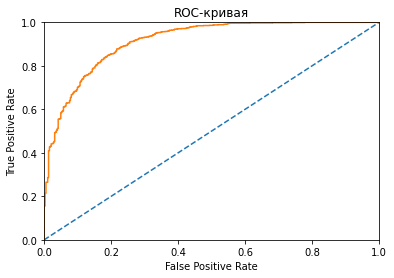

In [82]:
probabilities_test = cat.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')


In [83]:
probabilities_test = cat.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(roc_auc_score(target_test, probabilities_one_test))

0.9137934991024804


#### XGBClassifier

In [84]:
#start_time = time.time()

#gsc = GridSearchCV(
#            estimator=xgb.XGBClassifier(random_state=12345),
#            param_grid={"learning_rate": (0.05, 0.1, 0.2, 0.3, 0.4),
#                        "max_depth": [3, 5, 7, 9, 12, 15],
#                        "min_child_weight": [0.1, 0.3, 0.5],
#                        "colsample_bytree":[0.2, 0.5, 0.7, 0.9, 1.0],
#                       },
#            cv=5, verbose=0, n_jobs=-1)
#
#grid_result = gsc.fit(features_upsampled, target_upsampled)
#
#print(f'Лучшие параметры модели {grid_result.best_params_}')
#pred_valid = grid_result.predict(features_valid)



In [85]:
gsc = GridSearchCV(
            estimator=xgb.XGBClassifier(random_state=12345,
                                        learning_rate = 0.025,
                                        max_depth = 4,
                                        colsample_bytree= 1.0 ),
            param_grid={},
            cv=5, verbose=0, n_jobs=-1)

grid_result = gsc.fit(features_upsampled, target_upsampled)

pred_valid = grid_result.predict(features_valid)
accuracy = accuracy_score(target_valid, pred_valid)
print(accuracy)


[12:57:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.767590618336887


Text(0.5, 1.0, 'ROC-кривая')

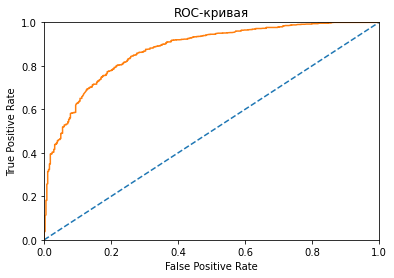

In [86]:
probabilities_test = gsc.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')


In [87]:
probabilities_test = gsc.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(roc_auc_score(target_test, probabilities_one_test))

0.8738526028067886


#### RandomForestClassifier

In [88]:
#%%time

#clf_rf_cv=RandomForestClassifier(random_state=12345)
#parametrs={
#    'n_estimators':range(30,100,5),
#    'max_depth':range(2,25,3),
#},
#n_jobs=-1,

#gr=GridSearchCV(clf_rf_cv,parametrs, cv=5)
#gr.fit(features_upsampled, target_upsampled)

#print(f"Лучшее параметры модели: {(gr.best_params_)}")

#pred_valid = gr.predict(features_valid)
#RMSE = mean_squared_error(target_valid, pred_valid)**0.5
#RMSE

In [89]:
model_rand_for_reg = RandomForestClassifier(random_state=12345, n_estimators=900, max_depth=5)
start_time = time.time()

model_rand_for_reg.fit(features_upsampled, target_upsampled)

time_value.append(time.time() - start_time)
model.append('RandomForestRegressor')
accuracy = accuracy_score(target_valid, pred_valid)
print(accuracy)

0.767590618336887


0.8502111210835509


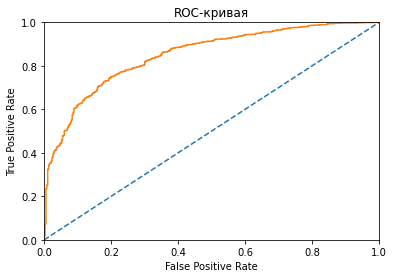

In [90]:
probabilities_test = model_rand_for_reg.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

probabilities_test = model_rand_for_reg.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(roc_auc_score(target_test, probabilities_one_test))

#### LGBMClassifier

In [91]:
#start_time = time.time()
#model_lgb = GridSearchCV(estimator=lgb.LGBMClassifier(objective="binary"),
#                         
#                   param_grid={"learning_rate" : (0.05, 0.1, 0.2, 0.3, 0.4),
#                               'n_estimators' : range(30,900,5),
#                               'max_depth' : range(2,25,3)},
#                         
#                         cv=5, verbose=0, n_jobs=-1)

#grid_result = model_lgb.fit(features_upsampled, target_upsampled)
#print(f'Лучшие параметры модели {grid_result.best_params_}')

#pred_valid = model_lgb.predict(features_valid)

#accuracy = accuracy_score(target_valid, pred_valid)
#print(accuracy)

In [92]:
model_lgb = lgb.LGBMClassifier(objective='binary', n_estimators = 900, learning_rate = 0.05, max_depth = 5)
model_lgb.fit(features_upsampled, target_upsampled)
pred_valid = model_lgb.predict(features_valid)

accuracy = accuracy_score(target_valid, pred_valid)
print(accuracy)

0.8628287135749823


0.9084619268113576


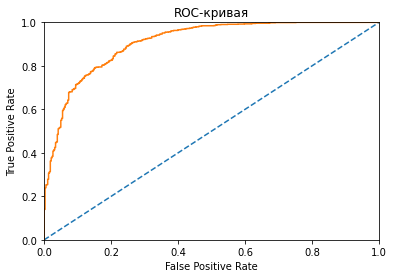

In [93]:
probabilities_test = model_lgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

probabilities_test = model_lgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(roc_auc_score(target_test, probabilities_one_test))

### Анализ важности фичей

model_lgb - модель

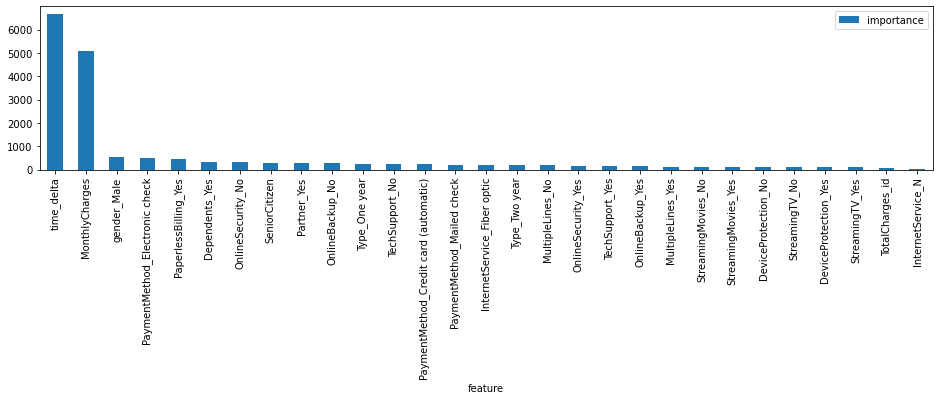

In [94]:
importances = pd.DataFrame({'feature':features_valid.columns,'importance':np.round(model_lgb.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(16, 3));

 CatBoostClassifier - модель

In [95]:
cat = CatBoostClassifier(iterations  = 10000, learning_rate = 0.025, max_depth = 4, random_state=12345)
cat.fit(features_upsampled, target_upsampled)
pred_valid = grid_result.predict(features_valid)

0:	learn: 0.6837823	total: 1.6ms	remaining: 16s
1:	learn: 0.6743476	total: 3.17ms	remaining: 15.9s
2:	learn: 0.6653012	total: 4.6ms	remaining: 15.3s
3:	learn: 0.6569927	total: 5.94ms	remaining: 14.8s
4:	learn: 0.6483444	total: 7.32ms	remaining: 14.6s
5:	learn: 0.6406066	total: 8.67ms	remaining: 14.4s
6:	learn: 0.6333818	total: 10.1ms	remaining: 14.4s
7:	learn: 0.6263972	total: 11.5ms	remaining: 14.3s
8:	learn: 0.6199029	total: 12.8ms	remaining: 14.2s
9:	learn: 0.6136613	total: 14.2ms	remaining: 14.2s
10:	learn: 0.6079466	total: 15.6ms	remaining: 14.2s
11:	learn: 0.6025083	total: 16.7ms	remaining: 13.9s
12:	learn: 0.5970105	total: 17.8ms	remaining: 13.7s
13:	learn: 0.5921863	total: 18.9ms	remaining: 13.5s
14:	learn: 0.5878965	total: 20ms	remaining: 13.3s
15:	learn: 0.5814775	total: 21.1ms	remaining: 13.2s
16:	learn: 0.5770440	total: 22.2ms	remaining: 13s
17:	learn: 0.5733437	total: 23.4ms	remaining: 13s
18:	learn: 0.5695917	total: 24.5ms	remaining: 12.9s
19:	learn: 0.5653660	total: 25.6

294:	learn: 0.4127893	total: 338ms	remaining: 11.1s
295:	learn: 0.4125781	total: 339ms	remaining: 11.1s
296:	learn: 0.4124157	total: 340ms	remaining: 11.1s
297:	learn: 0.4122634	total: 342ms	remaining: 11.1s
298:	learn: 0.4121577	total: 343ms	remaining: 11.1s
299:	learn: 0.4120199	total: 344ms	remaining: 11.1s
300:	learn: 0.4119313	total: 345ms	remaining: 11.1s
301:	learn: 0.4118482	total: 346ms	remaining: 11.1s
302:	learn: 0.4112296	total: 347ms	remaining: 11.1s
303:	learn: 0.4111325	total: 349ms	remaining: 11.1s
304:	learn: 0.4109005	total: 350ms	remaining: 11.1s
305:	learn: 0.4108144	total: 351ms	remaining: 11.1s
306:	learn: 0.4106834	total: 352ms	remaining: 11.1s
307:	learn: 0.4105678	total: 353ms	remaining: 11.1s
308:	learn: 0.4104169	total: 354ms	remaining: 11.1s
309:	learn: 0.4103213	total: 355ms	remaining: 11.1s
310:	learn: 0.4100997	total: 357ms	remaining: 11.1s
311:	learn: 0.4099720	total: 358ms	remaining: 11.1s
312:	learn: 0.4097797	total: 359ms	remaining: 11.1s
313:	learn: 

590:	learn: 0.3552219	total: 679ms	remaining: 10.8s
591:	learn: 0.3549952	total: 680ms	remaining: 10.8s
592:	learn: 0.3549075	total: 682ms	remaining: 10.8s
593:	learn: 0.3548235	total: 683ms	remaining: 10.8s
594:	learn: 0.3546525	total: 684ms	remaining: 10.8s
595:	learn: 0.3544118	total: 685ms	remaining: 10.8s
596:	learn: 0.3541359	total: 686ms	remaining: 10.8s
597:	learn: 0.3540452	total: 687ms	remaining: 10.8s
598:	learn: 0.3539593	total: 689ms	remaining: 10.8s
599:	learn: 0.3537711	total: 690ms	remaining: 10.8s
600:	learn: 0.3535218	total: 691ms	remaining: 10.8s
601:	learn: 0.3534330	total: 692ms	remaining: 10.8s
602:	learn: 0.3532926	total: 693ms	remaining: 10.8s
603:	learn: 0.3530274	total: 694ms	remaining: 10.8s
604:	learn: 0.3528677	total: 696ms	remaining: 10.8s
605:	learn: 0.3525834	total: 697ms	remaining: 10.8s
606:	learn: 0.3523518	total: 698ms	remaining: 10.8s
607:	learn: 0.3522082	total: 699ms	remaining: 10.8s
608:	learn: 0.3521264	total: 700ms	remaining: 10.8s
609:	learn: 

887:	learn: 0.3123142	total: 1.02s	remaining: 10.5s
888:	learn: 0.3121281	total: 1.02s	remaining: 10.5s
889:	learn: 0.3119644	total: 1.02s	remaining: 10.5s
890:	learn: 0.3119339	total: 1.02s	remaining: 10.5s
891:	learn: 0.3118546	total: 1.03s	remaining: 10.5s
892:	learn: 0.3118062	total: 1.03s	remaining: 10.5s
893:	learn: 0.3116925	total: 1.03s	remaining: 10.5s
894:	learn: 0.3115155	total: 1.03s	remaining: 10.5s
895:	learn: 0.3113934	total: 1.03s	remaining: 10.5s
896:	learn: 0.3112544	total: 1.03s	remaining: 10.5s
897:	learn: 0.3109874	total: 1.03s	remaining: 10.5s
898:	learn: 0.3108300	total: 1.03s	remaining: 10.5s
899:	learn: 0.3104797	total: 1.03s	remaining: 10.5s
900:	learn: 0.3102330	total: 1.04s	remaining: 10.5s
901:	learn: 0.3101738	total: 1.04s	remaining: 10.5s
902:	learn: 0.3100605	total: 1.04s	remaining: 10.5s
903:	learn: 0.3099530	total: 1.04s	remaining: 10.5s
904:	learn: 0.3097104	total: 1.04s	remaining: 10.5s
905:	learn: 0.3095688	total: 1.04s	remaining: 10.5s
906:	learn: 

1184:	learn: 0.2797380	total: 1.36s	remaining: 10.1s
1185:	learn: 0.2796958	total: 1.36s	remaining: 10.1s
1186:	learn: 0.2796249	total: 1.36s	remaining: 10.1s
1187:	learn: 0.2795514	total: 1.37s	remaining: 10.1s
1188:	learn: 0.2794846	total: 1.37s	remaining: 10.1s
1189:	learn: 0.2794106	total: 1.37s	remaining: 10.1s
1190:	learn: 0.2793685	total: 1.37s	remaining: 10.1s
1191:	learn: 0.2792885	total: 1.37s	remaining: 10.1s
1192:	learn: 0.2791009	total: 1.37s	remaining: 10.1s
1193:	learn: 0.2789635	total: 1.37s	remaining: 10.1s
1194:	learn: 0.2788946	total: 1.37s	remaining: 10.1s
1195:	learn: 0.2788467	total: 1.38s	remaining: 10.1s
1196:	learn: 0.2787775	total: 1.38s	remaining: 10.1s
1197:	learn: 0.2786863	total: 1.38s	remaining: 10.1s
1198:	learn: 0.2786415	total: 1.38s	remaining: 10.1s
1199:	learn: 0.2786260	total: 1.38s	remaining: 10.1s
1200:	learn: 0.2785392	total: 1.38s	remaining: 10.1s
1201:	learn: 0.2784696	total: 1.38s	remaining: 10.1s
1202:	learn: 0.2783540	total: 1.38s	remaining:

1482:	learn: 0.2560983	total: 1.7s	remaining: 9.79s
1483:	learn: 0.2558867	total: 1.71s	remaining: 9.79s
1484:	learn: 0.2558327	total: 1.71s	remaining: 9.79s
1485:	learn: 0.2557944	total: 1.71s	remaining: 9.78s
1486:	learn: 0.2556509	total: 1.71s	remaining: 9.78s
1487:	learn: 0.2555826	total: 1.71s	remaining: 9.78s
1488:	learn: 0.2554936	total: 1.71s	remaining: 9.78s
1489:	learn: 0.2554430	total: 1.71s	remaining: 9.78s
1490:	learn: 0.2553778	total: 1.71s	remaining: 9.78s
1491:	learn: 0.2553219	total: 1.71s	remaining: 9.78s
1492:	learn: 0.2552711	total: 1.72s	remaining: 9.78s
1493:	learn: 0.2551785	total: 1.72s	remaining: 9.77s
1494:	learn: 0.2550825	total: 1.72s	remaining: 9.77s
1495:	learn: 0.2550330	total: 1.72s	remaining: 9.77s
1496:	learn: 0.2549465	total: 1.72s	remaining: 9.77s
1497:	learn: 0.2548521	total: 1.72s	remaining: 9.77s
1498:	learn: 0.2547702	total: 1.72s	remaining: 9.77s
1499:	learn: 0.2546801	total: 1.72s	remaining: 9.77s
1500:	learn: 0.2546245	total: 1.72s	remaining: 

1781:	learn: 0.2368672	total: 2.04s	remaining: 9.44s
1782:	learn: 0.2368429	total: 2.05s	remaining: 9.43s
1783:	learn: 0.2368027	total: 2.05s	remaining: 9.43s
1784:	learn: 0.2366377	total: 2.05s	remaining: 9.43s
1785:	learn: 0.2365936	total: 2.05s	remaining: 9.43s
1786:	learn: 0.2365153	total: 2.05s	remaining: 9.43s
1787:	learn: 0.2364597	total: 2.05s	remaining: 9.43s
1788:	learn: 0.2364077	total: 2.05s	remaining: 9.43s
1789:	learn: 0.2363560	total: 2.06s	remaining: 9.43s
1790:	learn: 0.2363129	total: 2.06s	remaining: 9.42s
1791:	learn: 0.2362787	total: 2.06s	remaining: 9.42s
1792:	learn: 0.2362368	total: 2.06s	remaining: 9.42s
1793:	learn: 0.2362008	total: 2.06s	remaining: 9.42s
1794:	learn: 0.2361673	total: 2.06s	remaining: 9.42s
1795:	learn: 0.2360983	total: 2.06s	remaining: 9.42s
1796:	learn: 0.2360457	total: 2.06s	remaining: 9.42s
1797:	learn: 0.2359964	total: 2.06s	remaining: 9.42s
1798:	learn: 0.2359354	total: 2.06s	remaining: 9.41s
1799:	learn: 0.2358998	total: 2.07s	remaining:

2080:	learn: 0.2199141	total: 2.39s	remaining: 9.09s
2081:	learn: 0.2198655	total: 2.39s	remaining: 9.09s
2082:	learn: 0.2198302	total: 2.39s	remaining: 9.09s
2083:	learn: 0.2198017	total: 2.39s	remaining: 9.09s
2084:	learn: 0.2197741	total: 2.39s	remaining: 9.08s
2085:	learn: 0.2197093	total: 2.39s	remaining: 9.08s
2086:	learn: 0.2196431	total: 2.4s	remaining: 9.08s
2087:	learn: 0.2195804	total: 2.4s	remaining: 9.08s
2088:	learn: 0.2195400	total: 2.4s	remaining: 9.08s
2089:	learn: 0.2195103	total: 2.4s	remaining: 9.08s
2090:	learn: 0.2194368	total: 2.4s	remaining: 9.08s
2091:	learn: 0.2193900	total: 2.4s	remaining: 9.08s
2092:	learn: 0.2193146	total: 2.4s	remaining: 9.07s
2093:	learn: 0.2192803	total: 2.4s	remaining: 9.07s
2094:	learn: 0.2192290	total: 2.4s	remaining: 9.07s
2095:	learn: 0.2191488	total: 2.4s	remaining: 9.07s
2096:	learn: 0.2191173	total: 2.41s	remaining: 9.07s
2097:	learn: 0.2190696	total: 2.41s	remaining: 9.07s
2098:	learn: 0.2190186	total: 2.41s	remaining: 9.07s
209

2372:	learn: 0.2050693	total: 2.73s	remaining: 8.77s
2373:	learn: 0.2050141	total: 2.73s	remaining: 8.77s
2374:	learn: 0.2049860	total: 2.73s	remaining: 8.77s
2375:	learn: 0.2049390	total: 2.73s	remaining: 8.77s
2376:	learn: 0.2048826	total: 2.73s	remaining: 8.77s
2377:	learn: 0.2048130	total: 2.73s	remaining: 8.77s
2378:	learn: 0.2047605	total: 2.74s	remaining: 8.76s
2379:	learn: 0.2047347	total: 2.74s	remaining: 8.76s
2380:	learn: 0.2047025	total: 2.74s	remaining: 8.76s
2381:	learn: 0.2046617	total: 2.74s	remaining: 8.76s
2382:	learn: 0.2045715	total: 2.74s	remaining: 8.76s
2383:	learn: 0.2045034	total: 2.74s	remaining: 8.76s
2384:	learn: 0.2044593	total: 2.74s	remaining: 8.76s
2385:	learn: 0.2044280	total: 2.74s	remaining: 8.76s
2386:	learn: 0.2043716	total: 2.75s	remaining: 8.76s
2387:	learn: 0.2043440	total: 2.75s	remaining: 8.75s
2388:	learn: 0.2043130	total: 2.75s	remaining: 8.75s
2389:	learn: 0.2042567	total: 2.75s	remaining: 8.75s
2390:	learn: 0.2041839	total: 2.75s	remaining:

2670:	learn: 0.1925656	total: 3.07s	remaining: 8.43s
2671:	learn: 0.1925344	total: 3.07s	remaining: 8.43s
2672:	learn: 0.1924985	total: 3.07s	remaining: 8.43s
2673:	learn: 0.1924594	total: 3.07s	remaining: 8.42s
2674:	learn: 0.1924273	total: 3.08s	remaining: 8.42s
2675:	learn: 0.1923852	total: 3.08s	remaining: 8.42s
2676:	learn: 0.1923561	total: 3.08s	remaining: 8.42s
2677:	learn: 0.1923081	total: 3.08s	remaining: 8.42s
2678:	learn: 0.1922807	total: 3.08s	remaining: 8.42s
2679:	learn: 0.1922448	total: 3.08s	remaining: 8.42s
2680:	learn: 0.1922195	total: 3.08s	remaining: 8.42s
2681:	learn: 0.1921827	total: 3.08s	remaining: 8.41s
2682:	learn: 0.1921444	total: 3.08s	remaining: 8.41s
2683:	learn: 0.1921225	total: 3.09s	remaining: 8.41s
2684:	learn: 0.1920941	total: 3.09s	remaining: 8.41s
2685:	learn: 0.1920701	total: 3.09s	remaining: 8.41s
2686:	learn: 0.1920240	total: 3.09s	remaining: 8.41s
2687:	learn: 0.1919733	total: 3.09s	remaining: 8.41s
2688:	learn: 0.1919450	total: 3.09s	remaining:

2966:	learn: 0.1821611	total: 3.41s	remaining: 8.09s
2967:	learn: 0.1821377	total: 3.41s	remaining: 8.09s
2968:	learn: 0.1821099	total: 3.42s	remaining: 8.09s
2969:	learn: 0.1820784	total: 3.42s	remaining: 8.09s
2970:	learn: 0.1820589	total: 3.42s	remaining: 8.09s
2971:	learn: 0.1820373	total: 3.42s	remaining: 8.09s
2972:	learn: 0.1820120	total: 3.42s	remaining: 8.08s
2973:	learn: 0.1819834	total: 3.42s	remaining: 8.08s
2974:	learn: 0.1819602	total: 3.42s	remaining: 8.08s
2975:	learn: 0.1819445	total: 3.42s	remaining: 8.08s
2976:	learn: 0.1819158	total: 3.42s	remaining: 8.08s
2977:	learn: 0.1818939	total: 3.43s	remaining: 8.08s
2978:	learn: 0.1818720	total: 3.43s	remaining: 8.08s
2979:	learn: 0.1818619	total: 3.43s	remaining: 8.08s
2980:	learn: 0.1818435	total: 3.43s	remaining: 8.07s
2981:	learn: 0.1818269	total: 3.43s	remaining: 8.07s
2982:	learn: 0.1818037	total: 3.43s	remaining: 8.07s
2983:	learn: 0.1817813	total: 3.43s	remaining: 8.07s
2984:	learn: 0.1817612	total: 3.43s	remaining:

3261:	learn: 0.1728521	total: 3.75s	remaining: 7.76s
3262:	learn: 0.1728289	total: 3.76s	remaining: 7.75s
3263:	learn: 0.1728084	total: 3.76s	remaining: 7.75s
3264:	learn: 0.1727878	total: 3.76s	remaining: 7.75s
3265:	learn: 0.1727543	total: 3.76s	remaining: 7.75s
3266:	learn: 0.1727260	total: 3.76s	remaining: 7.75s
3267:	learn: 0.1727022	total: 3.76s	remaining: 7.75s
3268:	learn: 0.1726807	total: 3.76s	remaining: 7.75s
3269:	learn: 0.1726573	total: 3.76s	remaining: 7.75s
3270:	learn: 0.1726283	total: 3.77s	remaining: 7.75s
3271:	learn: 0.1725953	total: 3.77s	remaining: 7.74s
3272:	learn: 0.1725626	total: 3.77s	remaining: 7.74s
3273:	learn: 0.1725456	total: 3.77s	remaining: 7.74s
3274:	learn: 0.1725202	total: 3.77s	remaining: 7.74s
3275:	learn: 0.1724923	total: 3.77s	remaining: 7.74s
3276:	learn: 0.1724580	total: 3.77s	remaining: 7.74s
3277:	learn: 0.1724302	total: 3.77s	remaining: 7.74s
3278:	learn: 0.1724001	total: 3.77s	remaining: 7.74s
3279:	learn: 0.1723622	total: 3.77s	remaining:

3559:	learn: 0.1647062	total: 4.1s	remaining: 7.41s
3560:	learn: 0.1646804	total: 4.1s	remaining: 7.41s
3561:	learn: 0.1646464	total: 4.1s	remaining: 7.41s
3562:	learn: 0.1645902	total: 4.1s	remaining: 7.41s
3563:	learn: 0.1645599	total: 4.1s	remaining: 7.41s
3564:	learn: 0.1645441	total: 4.1s	remaining: 7.41s
3565:	learn: 0.1645180	total: 4.1s	remaining: 7.41s
3566:	learn: 0.1644940	total: 4.11s	remaining: 7.4s
3567:	learn: 0.1644602	total: 4.11s	remaining: 7.4s
3568:	learn: 0.1644345	total: 4.11s	remaining: 7.4s
3569:	learn: 0.1643970	total: 4.11s	remaining: 7.4s
3570:	learn: 0.1643624	total: 4.11s	remaining: 7.4s
3571:	learn: 0.1643273	total: 4.11s	remaining: 7.4s
3572:	learn: 0.1642410	total: 4.11s	remaining: 7.4s
3573:	learn: 0.1642090	total: 4.11s	remaining: 7.39s
3574:	learn: 0.1641897	total: 4.11s	remaining: 7.39s
3575:	learn: 0.1641542	total: 4.12s	remaining: 7.39s
3576:	learn: 0.1641453	total: 4.12s	remaining: 7.39s
3577:	learn: 0.1641271	total: 4.12s	remaining: 7.39s
3578:	l

3849:	learn: 0.1569148	total: 4.43s	remaining: 7.09s
3850:	learn: 0.1569067	total: 4.44s	remaining: 7.08s
3851:	learn: 0.1568887	total: 4.44s	remaining: 7.08s
3852:	learn: 0.1568304	total: 4.44s	remaining: 7.08s
3853:	learn: 0.1568025	total: 4.44s	remaining: 7.08s
3854:	learn: 0.1567822	total: 4.44s	remaining: 7.08s
3855:	learn: 0.1567584	total: 4.44s	remaining: 7.08s
3856:	learn: 0.1567244	total: 4.44s	remaining: 7.08s
3857:	learn: 0.1567113	total: 4.45s	remaining: 7.08s
3858:	learn: 0.1566840	total: 4.45s	remaining: 7.08s
3859:	learn: 0.1566499	total: 4.45s	remaining: 7.07s
3860:	learn: 0.1566326	total: 4.45s	remaining: 7.07s
3861:	learn: 0.1566155	total: 4.45s	remaining: 7.07s
3862:	learn: 0.1566012	total: 4.45s	remaining: 7.07s
3863:	learn: 0.1565520	total: 4.45s	remaining: 7.07s
3864:	learn: 0.1565413	total: 4.45s	remaining: 7.07s
3865:	learn: 0.1565076	total: 4.45s	remaining: 7.07s
3866:	learn: 0.1564654	total: 4.46s	remaining: 7.07s
3867:	learn: 0.1564475	total: 4.46s	remaining:

4139:	learn: 0.1494538	total: 4.78s	remaining: 6.76s
4140:	learn: 0.1493826	total: 4.78s	remaining: 6.76s
4141:	learn: 0.1493362	total: 4.78s	remaining: 6.76s
4142:	learn: 0.1493229	total: 4.78s	remaining: 6.76s
4143:	learn: 0.1492873	total: 4.78s	remaining: 6.75s
4144:	learn: 0.1492441	total: 4.78s	remaining: 6.75s
4145:	learn: 0.1492253	total: 4.78s	remaining: 6.75s
4146:	learn: 0.1492107	total: 4.78s	remaining: 6.75s
4147:	learn: 0.1491552	total: 4.78s	remaining: 6.75s
4148:	learn: 0.1491405	total: 4.79s	remaining: 6.75s
4149:	learn: 0.1490947	total: 4.79s	remaining: 6.75s
4150:	learn: 0.1490816	total: 4.79s	remaining: 6.75s
4151:	learn: 0.1490688	total: 4.79s	remaining: 6.75s
4152:	learn: 0.1490426	total: 4.79s	remaining: 6.74s
4153:	learn: 0.1489947	total: 4.79s	remaining: 6.74s
4154:	learn: 0.1489530	total: 4.79s	remaining: 6.74s
4155:	learn: 0.1489314	total: 4.79s	remaining: 6.74s
4156:	learn: 0.1489159	total: 4.79s	remaining: 6.74s
4157:	learn: 0.1489010	total: 4.8s	remaining: 

4383:	learn: 0.1435563	total: 5.12s	remaining: 6.56s
4384:	learn: 0.1435431	total: 5.12s	remaining: 6.56s
4385:	learn: 0.1434743	total: 5.12s	remaining: 6.55s
4386:	learn: 0.1434617	total: 5.12s	remaining: 6.55s
4387:	learn: 0.1434438	total: 5.12s	remaining: 6.55s
4388:	learn: 0.1434213	total: 5.13s	remaining: 6.55s
4389:	learn: 0.1434051	total: 5.13s	remaining: 6.55s
4390:	learn: 0.1433799	total: 5.13s	remaining: 6.55s
4391:	learn: 0.1433640	total: 5.13s	remaining: 6.55s
4392:	learn: 0.1433476	total: 5.13s	remaining: 6.55s
4393:	learn: 0.1433282	total: 5.13s	remaining: 6.55s
4394:	learn: 0.1433096	total: 5.13s	remaining: 6.54s
4395:	learn: 0.1432973	total: 5.13s	remaining: 6.54s
4396:	learn: 0.1432795	total: 5.13s	remaining: 6.54s
4397:	learn: 0.1432664	total: 5.13s	remaining: 6.54s
4398:	learn: 0.1432443	total: 5.14s	remaining: 6.54s
4399:	learn: 0.1432153	total: 5.14s	remaining: 6.54s
4400:	learn: 0.1432080	total: 5.14s	remaining: 6.54s
4401:	learn: 0.1431734	total: 5.14s	remaining:

4676:	learn: 0.1373264	total: 5.46s	remaining: 6.21s
4677:	learn: 0.1373145	total: 5.46s	remaining: 6.21s
4678:	learn: 0.1373014	total: 5.46s	remaining: 6.21s
4679:	learn: 0.1372835	total: 5.46s	remaining: 6.21s
4680:	learn: 0.1372725	total: 5.46s	remaining: 6.21s
4681:	learn: 0.1372420	total: 5.46s	remaining: 6.21s
4682:	learn: 0.1372288	total: 5.47s	remaining: 6.21s
4683:	learn: 0.1372165	total: 5.47s	remaining: 6.21s
4684:	learn: 0.1371789	total: 5.47s	remaining: 6.2s
4685:	learn: 0.1371458	total: 5.47s	remaining: 6.2s
4686:	learn: 0.1371182	total: 5.47s	remaining: 6.2s
4687:	learn: 0.1370977	total: 5.47s	remaining: 6.2s
4688:	learn: 0.1370752	total: 5.47s	remaining: 6.2s
4689:	learn: 0.1370447	total: 5.47s	remaining: 6.2s
4690:	learn: 0.1370299	total: 5.47s	remaining: 6.2s
4691:	learn: 0.1370136	total: 5.48s	remaining: 6.2s
4692:	learn: 0.1369944	total: 5.48s	remaining: 6.19s
4693:	learn: 0.1369859	total: 5.48s	remaining: 6.19s
4694:	learn: 0.1369615	total: 5.48s	remaining: 6.19s
4

4973:	learn: 0.1317544	total: 5.8s	remaining: 5.86s
4974:	learn: 0.1317381	total: 5.8s	remaining: 5.86s
4975:	learn: 0.1317286	total: 5.8s	remaining: 5.86s
4976:	learn: 0.1316903	total: 5.8s	remaining: 5.86s
4977:	learn: 0.1316622	total: 5.81s	remaining: 5.86s
4978:	learn: 0.1316336	total: 5.81s	remaining: 5.86s
4979:	learn: 0.1316167	total: 5.81s	remaining: 5.86s
4980:	learn: 0.1316032	total: 5.81s	remaining: 5.85s
4981:	learn: 0.1315528	total: 5.81s	remaining: 5.85s
4982:	learn: 0.1315255	total: 5.81s	remaining: 5.85s
4983:	learn: 0.1315142	total: 5.81s	remaining: 5.85s
4984:	learn: 0.1314754	total: 5.82s	remaining: 5.85s
4985:	learn: 0.1314633	total: 5.82s	remaining: 5.85s
4986:	learn: 0.1314206	total: 5.82s	remaining: 5.85s
4987:	learn: 0.1314072	total: 5.82s	remaining: 5.85s
4988:	learn: 0.1313949	total: 5.82s	remaining: 5.84s
4989:	learn: 0.1313728	total: 5.82s	remaining: 5.84s
4990:	learn: 0.1313609	total: 5.82s	remaining: 5.84s
4991:	learn: 0.1313397	total: 5.82s	remaining: 5.8

5269:	learn: 0.1259647	total: 6.14s	remaining: 5.51s
5270:	learn: 0.1259575	total: 6.14s	remaining: 5.51s
5271:	learn: 0.1259488	total: 6.15s	remaining: 5.51s
5272:	learn: 0.1259331	total: 6.15s	remaining: 5.51s
5273:	learn: 0.1259174	total: 6.15s	remaining: 5.51s
5274:	learn: 0.1259052	total: 6.15s	remaining: 5.51s
5275:	learn: 0.1258933	total: 6.15s	remaining: 5.51s
5276:	learn: 0.1258526	total: 6.15s	remaining: 5.51s
5277:	learn: 0.1258133	total: 6.15s	remaining: 5.5s
5278:	learn: 0.1257993	total: 6.16s	remaining: 5.5s
5279:	learn: 0.1257791	total: 6.16s	remaining: 5.5s
5280:	learn: 0.1257648	total: 6.16s	remaining: 5.5s
5281:	learn: 0.1257466	total: 6.16s	remaining: 5.5s
5282:	learn: 0.1257366	total: 6.16s	remaining: 5.5s
5283:	learn: 0.1257169	total: 6.16s	remaining: 5.5s
5284:	learn: 0.1257034	total: 6.16s	remaining: 5.5s
5285:	learn: 0.1256903	total: 6.16s	remaining: 5.5s
5286:	learn: 0.1256860	total: 6.16s	remaining: 5.5s
5287:	learn: 0.1256437	total: 6.17s	remaining: 5.49s
528

5565:	learn: 0.1208097	total: 6.49s	remaining: 5.17s
5566:	learn: 0.1207996	total: 6.49s	remaining: 5.17s
5567:	learn: 0.1207850	total: 6.49s	remaining: 5.17s
5568:	learn: 0.1207552	total: 6.49s	remaining: 5.16s
5569:	learn: 0.1207489	total: 6.49s	remaining: 5.16s
5570:	learn: 0.1207283	total: 6.49s	remaining: 5.16s
5571:	learn: 0.1207004	total: 6.49s	remaining: 5.16s
5572:	learn: 0.1206877	total: 6.5s	remaining: 5.16s
5573:	learn: 0.1206729	total: 6.5s	remaining: 5.16s
5574:	learn: 0.1206612	total: 6.5s	remaining: 5.16s
5575:	learn: 0.1206396	total: 6.5s	remaining: 5.16s
5576:	learn: 0.1206294	total: 6.5s	remaining: 5.16s
5577:	learn: 0.1205959	total: 6.5s	remaining: 5.15s
5578:	learn: 0.1205755	total: 6.5s	remaining: 5.15s
5579:	learn: 0.1205431	total: 6.5s	remaining: 5.15s
5580:	learn: 0.1205317	total: 6.5s	remaining: 5.15s
5581:	learn: 0.1205176	total: 6.5s	remaining: 5.15s
5582:	learn: 0.1204837	total: 6.51s	remaining: 5.15s
5583:	learn: 0.1204643	total: 6.51s	remaining: 5.15s
558

5860:	learn: 0.1158800	total: 6.83s	remaining: 4.82s
5861:	learn: 0.1158612	total: 6.83s	remaining: 4.82s
5862:	learn: 0.1158369	total: 6.83s	remaining: 4.82s
5863:	learn: 0.1158198	total: 6.83s	remaining: 4.82s
5864:	learn: 0.1158013	total: 6.83s	remaining: 4.82s
5865:	learn: 0.1157853	total: 6.83s	remaining: 4.82s
5866:	learn: 0.1157671	total: 6.83s	remaining: 4.82s
5867:	learn: 0.1157609	total: 6.84s	remaining: 4.81s
5868:	learn: 0.1157410	total: 6.84s	remaining: 4.81s
5869:	learn: 0.1157123	total: 6.84s	remaining: 4.81s
5870:	learn: 0.1156914	total: 6.84s	remaining: 4.81s
5871:	learn: 0.1156805	total: 6.84s	remaining: 4.81s
5872:	learn: 0.1156416	total: 6.84s	remaining: 4.81s
5873:	learn: 0.1156235	total: 6.84s	remaining: 4.81s
5874:	learn: 0.1156074	total: 6.84s	remaining: 4.81s
5875:	learn: 0.1155841	total: 6.85s	remaining: 4.8s
5876:	learn: 0.1155776	total: 6.85s	remaining: 4.8s
5877:	learn: 0.1155556	total: 6.85s	remaining: 4.8s
5878:	learn: 0.1155425	total: 6.85s	remaining: 4.

6154:	learn: 0.1112094	total: 7.17s	remaining: 4.48s
6155:	learn: 0.1111971	total: 7.17s	remaining: 4.48s
6156:	learn: 0.1111765	total: 7.17s	remaining: 4.48s
6157:	learn: 0.1111559	total: 7.17s	remaining: 4.48s
6158:	learn: 0.1111455	total: 7.18s	remaining: 4.47s
6159:	learn: 0.1111206	total: 7.18s	remaining: 4.47s
6160:	learn: 0.1111046	total: 7.18s	remaining: 4.47s
6161:	learn: 0.1110959	total: 7.18s	remaining: 4.47s
6162:	learn: 0.1110864	total: 7.18s	remaining: 4.47s
6163:	learn: 0.1110334	total: 7.18s	remaining: 4.47s
6164:	learn: 0.1110176	total: 7.18s	remaining: 4.47s
6165:	learn: 0.1109921	total: 7.18s	remaining: 4.47s
6166:	learn: 0.1109872	total: 7.18s	remaining: 4.47s
6167:	learn: 0.1109787	total: 7.19s	remaining: 4.46s
6168:	learn: 0.1109482	total: 7.19s	remaining: 4.46s
6169:	learn: 0.1109379	total: 7.19s	remaining: 4.46s
6170:	learn: 0.1109256	total: 7.19s	remaining: 4.46s
6171:	learn: 0.1109096	total: 7.19s	remaining: 4.46s
6172:	learn: 0.1109011	total: 7.19s	remaining:

6310:	learn: 0.1088471	total: 7.35s	remaining: 4.3s
6311:	learn: 0.1088327	total: 7.35s	remaining: 4.3s
6312:	learn: 0.1088213	total: 7.35s	remaining: 4.29s
6313:	learn: 0.1088137	total: 7.36s	remaining: 4.29s
6314:	learn: 0.1088008	total: 7.36s	remaining: 4.29s
6315:	learn: 0.1087888	total: 7.36s	remaining: 4.29s
6316:	learn: 0.1087817	total: 7.36s	remaining: 4.29s
6317:	learn: 0.1087739	total: 7.36s	remaining: 4.29s
6318:	learn: 0.1087451	total: 7.36s	remaining: 4.29s
6319:	learn: 0.1087303	total: 7.36s	remaining: 4.29s
6320:	learn: 0.1087076	total: 7.36s	remaining: 4.29s
6321:	learn: 0.1086934	total: 7.37s	remaining: 4.29s
6322:	learn: 0.1086739	total: 7.37s	remaining: 4.28s
6323:	learn: 0.1086465	total: 7.37s	remaining: 4.28s
6324:	learn: 0.1086275	total: 7.37s	remaining: 4.28s
6325:	learn: 0.1086060	total: 7.37s	remaining: 4.28s
6326:	learn: 0.1085905	total: 7.37s	remaining: 4.28s
6327:	learn: 0.1085778	total: 7.37s	remaining: 4.28s
6328:	learn: 0.1085659	total: 7.37s	remaining: 4

6608:	learn: 0.1045006	total: 7.7s	remaining: 3.95s
6609:	learn: 0.1044905	total: 7.7s	remaining: 3.95s
6610:	learn: 0.1044718	total: 7.7s	remaining: 3.95s
6611:	learn: 0.1044518	total: 7.7s	remaining: 3.95s
6612:	learn: 0.1044313	total: 7.7s	remaining: 3.94s
6613:	learn: 0.1044226	total: 7.7s	remaining: 3.94s
6614:	learn: 0.1044137	total: 7.71s	remaining: 3.94s
6615:	learn: 0.1044024	total: 7.71s	remaining: 3.94s
6616:	learn: 0.1043939	total: 7.71s	remaining: 3.94s
6617:	learn: 0.1043840	total: 7.71s	remaining: 3.94s
6618:	learn: 0.1043637	total: 7.71s	remaining: 3.94s
6619:	learn: 0.1043470	total: 7.71s	remaining: 3.94s
6620:	learn: 0.1043347	total: 7.71s	remaining: 3.94s
6621:	learn: 0.1043151	total: 7.71s	remaining: 3.93s
6622:	learn: 0.1043014	total: 7.71s	remaining: 3.93s
6623:	learn: 0.1042925	total: 7.71s	remaining: 3.93s
6624:	learn: 0.1042799	total: 7.72s	remaining: 3.93s
6625:	learn: 0.1042688	total: 7.72s	remaining: 3.93s
6626:	learn: 0.1042552	total: 7.72s	remaining: 3.93s

6900:	learn: 0.1005374	total: 8.04s	remaining: 3.61s
6901:	learn: 0.1005126	total: 8.04s	remaining: 3.61s
6902:	learn: 0.1005080	total: 8.04s	remaining: 3.61s
6903:	learn: 0.1004957	total: 8.04s	remaining: 3.6s
6904:	learn: 0.1004875	total: 8.04s	remaining: 3.6s
6905:	learn: 0.1004782	total: 8.04s	remaining: 3.6s
6906:	learn: 0.1004671	total: 8.04s	remaining: 3.6s
6907:	learn: 0.1004627	total: 8.04s	remaining: 3.6s
6908:	learn: 0.1004469	total: 8.05s	remaining: 3.6s
6909:	learn: 0.1004355	total: 8.05s	remaining: 3.6s
6910:	learn: 0.1004244	total: 8.05s	remaining: 3.6s
6911:	learn: 0.1004169	total: 8.05s	remaining: 3.6s
6912:	learn: 0.1004095	total: 8.05s	remaining: 3.6s
6913:	learn: 0.1003859	total: 8.05s	remaining: 3.59s
6914:	learn: 0.1003683	total: 8.05s	remaining: 3.59s
6915:	learn: 0.1003566	total: 8.05s	remaining: 3.59s
6916:	learn: 0.1003434	total: 8.05s	remaining: 3.59s
6917:	learn: 0.1003352	total: 8.06s	remaining: 3.59s
6918:	learn: 0.1003274	total: 8.06s	remaining: 3.59s
691

7193:	learn: 0.0971084	total: 8.37s	remaining: 3.27s
7194:	learn: 0.0971019	total: 8.38s	remaining: 3.27s
7195:	learn: 0.0970859	total: 8.38s	remaining: 3.26s
7196:	learn: 0.0970734	total: 8.38s	remaining: 3.26s
7197:	learn: 0.0970665	total: 8.38s	remaining: 3.26s
7198:	learn: 0.0970638	total: 8.38s	remaining: 3.26s
7199:	learn: 0.0970568	total: 8.38s	remaining: 3.26s
7200:	learn: 0.0970505	total: 8.38s	remaining: 3.26s
7201:	learn: 0.0970439	total: 8.38s	remaining: 3.26s
7202:	learn: 0.0970402	total: 8.38s	remaining: 3.25s
7203:	learn: 0.0970308	total: 8.38s	remaining: 3.25s
7204:	learn: 0.0970179	total: 8.39s	remaining: 3.25s
7205:	learn: 0.0970060	total: 8.39s	remaining: 3.25s
7206:	learn: 0.0969957	total: 8.39s	remaining: 3.25s
7207:	learn: 0.0969817	total: 8.39s	remaining: 3.25s
7208:	learn: 0.0969722	total: 8.39s	remaining: 3.25s
7209:	learn: 0.0969577	total: 8.39s	remaining: 3.25s
7210:	learn: 0.0969401	total: 8.39s	remaining: 3.25s
7211:	learn: 0.0969348	total: 8.39s	remaining:

7494:	learn: 0.0936918	total: 8.72s	remaining: 2.92s
7495:	learn: 0.0936863	total: 8.73s	remaining: 2.91s
7496:	learn: 0.0936766	total: 8.73s	remaining: 2.91s
7497:	learn: 0.0936678	total: 8.73s	remaining: 2.91s
7498:	learn: 0.0936531	total: 8.73s	remaining: 2.91s
7499:	learn: 0.0936399	total: 8.73s	remaining: 2.91s
7500:	learn: 0.0936319	total: 8.73s	remaining: 2.91s
7501:	learn: 0.0936221	total: 8.73s	remaining: 2.91s
7502:	learn: 0.0936138	total: 8.73s	remaining: 2.91s
7503:	learn: 0.0936025	total: 8.73s	remaining: 2.9s
7504:	learn: 0.0935874	total: 8.74s	remaining: 2.9s
7505:	learn: 0.0935812	total: 8.74s	remaining: 2.9s
7506:	learn: 0.0935764	total: 8.74s	remaining: 2.9s
7507:	learn: 0.0935631	total: 8.74s	remaining: 2.9s
7508:	learn: 0.0935560	total: 8.74s	remaining: 2.9s
7509:	learn: 0.0935391	total: 8.74s	remaining: 2.9s
7510:	learn: 0.0935367	total: 8.74s	remaining: 2.9s
7511:	learn: 0.0935302	total: 8.74s	remaining: 2.9s
7512:	learn: 0.0935061	total: 8.75s	remaining: 2.9s
751

7775:	learn: 0.0906426	total: 9.05s	remaining: 2.59s
7776:	learn: 0.0906318	total: 9.06s	remaining: 2.59s
7777:	learn: 0.0906262	total: 9.06s	remaining: 2.59s
7778:	learn: 0.0906127	total: 9.06s	remaining: 2.59s
7779:	learn: 0.0906028	total: 9.06s	remaining: 2.58s
7780:	learn: 0.0905892	total: 9.06s	remaining: 2.58s
7781:	learn: 0.0905864	total: 9.06s	remaining: 2.58s
7782:	learn: 0.0905751	total: 9.06s	remaining: 2.58s
7783:	learn: 0.0905626	total: 9.06s	remaining: 2.58s
7784:	learn: 0.0905431	total: 9.06s	remaining: 2.58s
7785:	learn: 0.0905300	total: 9.07s	remaining: 2.58s
7786:	learn: 0.0905245	total: 9.07s	remaining: 2.58s
7787:	learn: 0.0905076	total: 9.07s	remaining: 2.58s
7788:	learn: 0.0904914	total: 9.07s	remaining: 2.57s
7789:	learn: 0.0904806	total: 9.07s	remaining: 2.57s
7790:	learn: 0.0904631	total: 9.07s	remaining: 2.57s
7791:	learn: 0.0904527	total: 9.07s	remaining: 2.57s
7792:	learn: 0.0904433	total: 9.07s	remaining: 2.57s
7793:	learn: 0.0904411	total: 9.08s	remaining:

8077:	learn: 0.0875181	total: 9.41s	remaining: 2.24s
8078:	learn: 0.0875038	total: 9.41s	remaining: 2.24s
8079:	learn: 0.0874970	total: 9.41s	remaining: 2.23s
8080:	learn: 0.0874880	total: 9.41s	remaining: 2.23s
8081:	learn: 0.0874761	total: 9.41s	remaining: 2.23s
8082:	learn: 0.0874612	total: 9.41s	remaining: 2.23s
8083:	learn: 0.0874578	total: 9.41s	remaining: 2.23s
8084:	learn: 0.0874479	total: 9.41s	remaining: 2.23s
8085:	learn: 0.0874384	total: 9.41s	remaining: 2.23s
8086:	learn: 0.0874284	total: 9.42s	remaining: 2.23s
8087:	learn: 0.0874161	total: 9.42s	remaining: 2.23s
8088:	learn: 0.0874122	total: 9.42s	remaining: 2.23s
8089:	learn: 0.0874066	total: 9.42s	remaining: 2.22s
8090:	learn: 0.0873948	total: 9.42s	remaining: 2.22s
8091:	learn: 0.0873738	total: 9.42s	remaining: 2.22s
8092:	learn: 0.0873697	total: 9.42s	remaining: 2.22s
8093:	learn: 0.0873625	total: 9.42s	remaining: 2.22s
8094:	learn: 0.0873564	total: 9.43s	remaining: 2.22s
8095:	learn: 0.0873494	total: 9.43s	remaining:

8366:	learn: 0.0849275	total: 9.74s	remaining: 1.9s
8367:	learn: 0.0849180	total: 9.74s	remaining: 1.9s
8368:	learn: 0.0849017	total: 9.74s	remaining: 1.9s
8369:	learn: 0.0848960	total: 9.75s	remaining: 1.9s
8370:	learn: 0.0848757	total: 9.75s	remaining: 1.9s
8371:	learn: 0.0848704	total: 9.75s	remaining: 1.9s
8372:	learn: 0.0848672	total: 9.75s	remaining: 1.89s
8373:	learn: 0.0848610	total: 9.75s	remaining: 1.89s
8374:	learn: 0.0848412	total: 9.75s	remaining: 1.89s
8375:	learn: 0.0848347	total: 9.75s	remaining: 1.89s
8376:	learn: 0.0848286	total: 9.75s	remaining: 1.89s
8377:	learn: 0.0848125	total: 9.76s	remaining: 1.89s
8378:	learn: 0.0848087	total: 9.76s	remaining: 1.89s
8379:	learn: 0.0848066	total: 9.76s	remaining: 1.89s
8380:	learn: 0.0848046	total: 9.76s	remaining: 1.89s
8381:	learn: 0.0847985	total: 9.76s	remaining: 1.88s
8382:	learn: 0.0847922	total: 9.76s	remaining: 1.88s
8383:	learn: 0.0847797	total: 9.76s	remaining: 1.88s
8384:	learn: 0.0847746	total: 9.76s	remaining: 1.88s

8655:	learn: 0.0821997	total: 10.1s	remaining: 1.56s
8656:	learn: 0.0821813	total: 10.1s	remaining: 1.56s
8657:	learn: 0.0821709	total: 10.1s	remaining: 1.56s
8658:	learn: 0.0821659	total: 10.1s	remaining: 1.56s
8659:	learn: 0.0821601	total: 10.1s	remaining: 1.56s
8660:	learn: 0.0821393	total: 10.1s	remaining: 1.56s
8661:	learn: 0.0821348	total: 10.1s	remaining: 1.56s
8662:	learn: 0.0821287	total: 10.1s	remaining: 1.56s
8663:	learn: 0.0821072	total: 10.1s	remaining: 1.55s
8664:	learn: 0.0820973	total: 10.1s	remaining: 1.55s
8665:	learn: 0.0820812	total: 10.1s	remaining: 1.55s
8666:	learn: 0.0820768	total: 10.1s	remaining: 1.55s
8667:	learn: 0.0820645	total: 10.1s	remaining: 1.55s
8668:	learn: 0.0820596	total: 10.1s	remaining: 1.55s
8669:	learn: 0.0820367	total: 10.1s	remaining: 1.55s
8670:	learn: 0.0820274	total: 10.1s	remaining: 1.55s
8671:	learn: 0.0820241	total: 10.1s	remaining: 1.55s
8672:	learn: 0.0820165	total: 10.1s	remaining: 1.54s
8673:	learn: 0.0820111	total: 10.1s	remaining:

8952:	learn: 0.0792919	total: 10.4s	remaining: 1.22s
8953:	learn: 0.0792862	total: 10.4s	remaining: 1.22s
8954:	learn: 0.0792791	total: 10.4s	remaining: 1.22s
8955:	learn: 0.0792697	total: 10.4s	remaining: 1.22s
8956:	learn: 0.0792676	total: 10.4s	remaining: 1.21s
8957:	learn: 0.0792538	total: 10.4s	remaining: 1.21s
8958:	learn: 0.0792393	total: 10.4s	remaining: 1.21s
8959:	learn: 0.0792346	total: 10.4s	remaining: 1.21s
8960:	learn: 0.0792290	total: 10.4s	remaining: 1.21s
8961:	learn: 0.0792086	total: 10.4s	remaining: 1.21s
8962:	learn: 0.0792020	total: 10.4s	remaining: 1.21s
8963:	learn: 0.0791931	total: 10.4s	remaining: 1.21s
8964:	learn: 0.0791782	total: 10.4s	remaining: 1.21s
8965:	learn: 0.0791590	total: 10.4s	remaining: 1.2s
8966:	learn: 0.0791551	total: 10.4s	remaining: 1.2s
8967:	learn: 0.0791488	total: 10.4s	remaining: 1.2s
8968:	learn: 0.0791446	total: 10.4s	remaining: 1.2s
8969:	learn: 0.0791402	total: 10.4s	remaining: 1.2s
8970:	learn: 0.0791361	total: 10.4s	remaining: 1.2s

9243:	learn: 0.0766782	total: 10.8s	remaining: 880ms
9244:	learn: 0.0766626	total: 10.8s	remaining: 879ms
9245:	learn: 0.0766491	total: 10.8s	remaining: 878ms
9246:	learn: 0.0766419	total: 10.8s	remaining: 877ms
9247:	learn: 0.0766329	total: 10.8s	remaining: 875ms
9248:	learn: 0.0766309	total: 10.8s	remaining: 874ms
9249:	learn: 0.0766263	total: 10.8s	remaining: 873ms
9250:	learn: 0.0766123	total: 10.8s	remaining: 872ms
9251:	learn: 0.0765983	total: 10.8s	remaining: 871ms
9252:	learn: 0.0765841	total: 10.8s	remaining: 870ms
9253:	learn: 0.0765729	total: 10.8s	remaining: 868ms
9254:	learn: 0.0765674	total: 10.8s	remaining: 867ms
9255:	learn: 0.0765538	total: 10.8s	remaining: 866ms
9256:	learn: 0.0765479	total: 10.8s	remaining: 865ms
9257:	learn: 0.0765408	total: 10.8s	remaining: 864ms
9258:	learn: 0.0765385	total: 10.8s	remaining: 863ms
9259:	learn: 0.0765292	total: 10.8s	remaining: 861ms
9260:	learn: 0.0765207	total: 10.8s	remaining: 860ms
9261:	learn: 0.0765108	total: 10.8s	remaining:

9401:	learn: 0.0753536	total: 10.9s	remaining: 696ms
9402:	learn: 0.0753515	total: 10.9s	remaining: 695ms
9403:	learn: 0.0753417	total: 10.9s	remaining: 694ms
9404:	learn: 0.0753359	total: 10.9s	remaining: 693ms
9405:	learn: 0.0753338	total: 10.9s	remaining: 691ms
9406:	learn: 0.0753259	total: 10.9s	remaining: 690ms
9407:	learn: 0.0753165	total: 11s	remaining: 689ms
9408:	learn: 0.0753080	total: 11s	remaining: 688ms
9409:	learn: 0.0752987	total: 11s	remaining: 687ms
9410:	learn: 0.0752887	total: 11s	remaining: 686ms
9411:	learn: 0.0752810	total: 11s	remaining: 684ms
9412:	learn: 0.0752704	total: 11s	remaining: 683ms
9413:	learn: 0.0752615	total: 11s	remaining: 682ms
9414:	learn: 0.0752526	total: 11s	remaining: 681ms
9415:	learn: 0.0752402	total: 11s	remaining: 680ms
9416:	learn: 0.0752330	total: 11s	remaining: 679ms
9417:	learn: 0.0752233	total: 11s	remaining: 677ms
9418:	learn: 0.0752138	total: 11s	remaining: 676ms
9419:	learn: 0.0752044	total: 11s	remaining: 675ms
9420:	learn: 0.0751

9695:	learn: 0.0729814	total: 11.3s	remaining: 354ms
9696:	learn: 0.0729788	total: 11.3s	remaining: 353ms
9697:	learn: 0.0729733	total: 11.3s	remaining: 351ms
9698:	learn: 0.0729679	total: 11.3s	remaining: 350ms
9699:	learn: 0.0729654	total: 11.3s	remaining: 349ms
9700:	learn: 0.0729561	total: 11.3s	remaining: 348ms
9701:	learn: 0.0729517	total: 11.3s	remaining: 347ms
9702:	learn: 0.0729430	total: 11.3s	remaining: 346ms
9703:	learn: 0.0729384	total: 11.3s	remaining: 344ms
9704:	learn: 0.0729332	total: 11.3s	remaining: 343ms
9705:	learn: 0.0729274	total: 11.3s	remaining: 342ms
9706:	learn: 0.0729162	total: 11.3s	remaining: 341ms
9707:	learn: 0.0729078	total: 11.3s	remaining: 340ms
9708:	learn: 0.0729014	total: 11.3s	remaining: 339ms
9709:	learn: 0.0728860	total: 11.3s	remaining: 337ms
9710:	learn: 0.0728798	total: 11.3s	remaining: 336ms
9711:	learn: 0.0728781	total: 11.3s	remaining: 335ms
9712:	learn: 0.0728682	total: 11.3s	remaining: 334ms
9713:	learn: 0.0728608	total: 11.3s	remaining:

9996:	learn: 0.0707744	total: 11.6s	remaining: 3.49ms
9997:	learn: 0.0707695	total: 11.6s	remaining: 2.33ms
9998:	learn: 0.0707641	total: 11.6s	remaining: 1.16ms
9999:	learn: 0.0707553	total: 11.6s	remaining: 0us


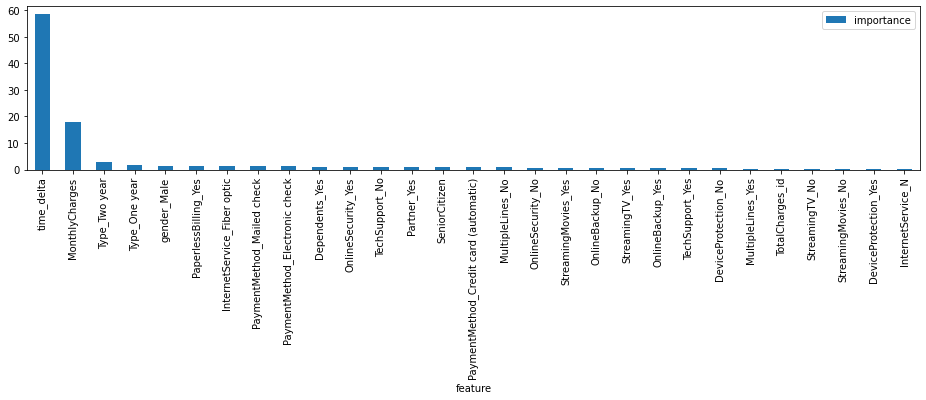

In [96]:
importances = pd.DataFrame({'feature':features_valid.columns,'importance':np.round(cat.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(16, 3));

Выводы: Наиболее полезным признаком оказался сгенерированный нами time_delta. Модель LGBMClassifier сочла не менее полезным признак MonthlyCharges.

## Финальное обучение моделей-лидеров на более полном датасете

модели с наиболее хорошими результати у нас оказались CatBoostClassifier и LGBMClassifier

Воспользуемся нашей копией данных и повторим операцию разбиения на выборки и устранение дисбаланса классов

In [97]:
df_copy.columns

Index(['MonthlyCharges', 'target_value', 'time_delta', 'TotalCharges_id',
       'SeniorCitizen', 'Type_One year', 'Type_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_N', 'OnlineSecurity_No',
       'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_Yes', 'gender_Male',
       'Partner_Yes', 'Dependents_Yes', 'MultipleLines_No',
       'MultipleLines_Yes'],
      dtype='object')

In [98]:
df_copy

,MonthlyCharges,target_value,time_delta,TotalCharges_id,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,gender_Male,Partner_Yes,Dependents_Yes,MultipleLines_No,MultipleLines_Yes
0,29.85,1.0,31.0,1.0,0,0,0,1,0,1,...,0,1,0,1,0,0,1,0,0,0
1,56.95,1.0,1036.0,1.0,0,1,0,0,0,0,...,0,1,0,1,0,1,0,0,1,0
2,53.85,0.0,61.0,1.0,0,0,0,1,0,0,...,0,1,0,1,0,1,0,0,1,0
3,42.30,1.0,1371.0,1.0,0,1,0,0,0,0,...,1,1,0,1,0,1,0,0,0,0
4,70.70,0.0,61.0,1.0,0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,84.80,1.0,730.0,1.0,0,1,0,1,0,0,...,1,0,1,0,1,1,1,1,0,1
7028,103.20,1.0,2191.0,0.0,0,1,0,1,1,0,...,0,0,1,0,1,0,1,1,0,1
7029,29.60,1.0,337.0,1.0,0,0,0,1,0,1,...,0,1,0,1,0,0,1,1,0,0
7030,74.40,0.0,123.0,1.0,1,0,0,1,0,0,...,0,1,0,1,0,1,1,0,0,1


In [99]:
df_copy = df_copy[['time_delta',
                   'MonthlyCharges',
                   'Type_Two year',
                   'target_value']]

In [100]:
target = df_copy['target_value']
features = df_copy.drop('target_value', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
     features, target, test_size=0.2, random_state=12345)

print(target_train.value_counts())

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

print(target_upsampled.value_counts())

1.0    4139
0.0    1486
Name: target_value, dtype: int64
0.0    4458
1.0    4139
Name: target_value, dtype: int64


На полученном более полном датасете обучим обе наши модели

In [101]:
cat = GridSearchCV(estimator=CatBoostClassifier(iterations  = 10000, learning_rate = 0.025, max_depth = 4),
                   param_grid={},
            cv=5, verbose=0, n_jobs=-1)
grid_result = cat.fit(features_upsampled, target_upsampled)
pred_test = grid_result.predict(features_test)

0:	learn: 0.6825587	total: 1.69ms	remaining: 16.8s
1:	learn: 0.6731564	total: 3.49ms	remaining: 17.4s
2:	learn: 0.6649800	total: 4.99ms	remaining: 16.6s
3:	learn: 0.6564340	total: 6.49ms	remaining: 16.2s
4:	learn: 0.6489622	total: 7.79ms	remaining: 15.6s
5:	learn: 0.6416459	total: 9.1ms	remaining: 15.2s
6:	learn: 0.6344597	total: 10.4ms	remaining: 14.9s
7:	learn: 0.6259642	total: 11.7ms	remaining: 14.6s
8:	learn: 0.6200930	total: 13ms	remaining: 14.4s
9:	learn: 0.6134966	total: 14.3ms	remaining: 14.3s
10:	learn: 0.6079799	total: 15.7ms	remaining: 14.2s
11:	learn: 0.6028255	total: 17ms	remaining: 14.1s
12:	learn: 0.5980422	total: 18.3ms	remaining: 14s
13:	learn: 0.5935005	total: 19.6ms	remaining: 14s
14:	learn: 0.5889687	total: 20.9ms	remaining: 13.9s
15:	learn: 0.5846885	total: 22.2ms	remaining: 13.9s
16:	learn: 0.5801867	total: 23.6ms	remaining: 13.8s
17:	learn: 0.5766957	total: 24.9ms	remaining: 13.8s
18:	learn: 0.5727652	total: 26.2ms	remaining: 13.8s
19:	learn: 0.5696127	total: 27.

252:	learn: 0.4379741	total: 342ms	remaining: 13.2s
253:	learn: 0.4378456	total: 344ms	remaining: 13.2s
254:	learn: 0.4377329	total: 345ms	remaining: 13.2s
255:	learn: 0.4376920	total: 346ms	remaining: 13.2s
256:	learn: 0.4375272	total: 348ms	remaining: 13.2s
257:	learn: 0.4372107	total: 349ms	remaining: 13.2s
258:	learn: 0.4371245	total: 351ms	remaining: 13.2s
259:	learn: 0.4369493	total: 352ms	remaining: 13.2s
260:	learn: 0.4368807	total: 353ms	remaining: 13.2s
261:	learn: 0.4364561	total: 355ms	remaining: 13.2s
262:	learn: 0.4359310	total: 356ms	remaining: 13.2s
263:	learn: 0.4357860	total: 357ms	remaining: 13.2s
264:	learn: 0.4355437	total: 359ms	remaining: 13.2s
265:	learn: 0.4353897	total: 360ms	remaining: 13.2s
266:	learn: 0.4353068	total: 362ms	remaining: 13.2s
267:	learn: 0.4352526	total: 363ms	remaining: 13.2s
268:	learn: 0.4350862	total: 364ms	remaining: 13.2s
269:	learn: 0.4348564	total: 366ms	remaining: 13.2s
270:	learn: 0.4347306	total: 367ms	remaining: 13.2s
271:	learn: 

509:	learn: 0.3881652	total: 691ms	remaining: 12.9s
510:	learn: 0.3879454	total: 692ms	remaining: 12.9s
511:	learn: 0.3878671	total: 694ms	remaining: 12.9s
512:	learn: 0.3876199	total: 695ms	remaining: 12.9s
513:	learn: 0.3875057	total: 697ms	remaining: 12.9s
514:	learn: 0.3873889	total: 698ms	remaining: 12.9s
515:	learn: 0.3871488	total: 699ms	remaining: 12.9s
516:	learn: 0.3870627	total: 701ms	remaining: 12.9s
517:	learn: 0.3869888	total: 702ms	remaining: 12.9s
518:	learn: 0.3869295	total: 704ms	remaining: 12.9s
519:	learn: 0.3867001	total: 705ms	remaining: 12.9s
520:	learn: 0.3865729	total: 706ms	remaining: 12.9s
521:	learn: 0.3864428	total: 708ms	remaining: 12.9s
522:	learn: 0.3860035	total: 709ms	remaining: 12.9s
523:	learn: 0.3858622	total: 711ms	remaining: 12.8s
524:	learn: 0.3856446	total: 712ms	remaining: 12.8s
525:	learn: 0.3854731	total: 713ms	remaining: 12.8s
526:	learn: 0.3853669	total: 715ms	remaining: 12.8s
527:	learn: 0.3850837	total: 716ms	remaining: 12.8s
528:	learn: 

757:	learn: 0.3498994	total: 1.03s	remaining: 12.6s
758:	learn: 0.3498187	total: 1.03s	remaining: 12.6s
759:	learn: 0.3496968	total: 1.03s	remaining: 12.6s
760:	learn: 0.3493446	total: 1.03s	remaining: 12.6s
761:	learn: 0.3492623	total: 1.04s	remaining: 12.6s
762:	learn: 0.3492152	total: 1.04s	remaining: 12.6s
763:	learn: 0.3491271	total: 1.04s	remaining: 12.6s
764:	learn: 0.3490756	total: 1.04s	remaining: 12.6s
765:	learn: 0.3489808	total: 1.04s	remaining: 12.6s
766:	learn: 0.3489458	total: 1.04s	remaining: 12.6s
767:	learn: 0.3488872	total: 1.04s	remaining: 12.6s
768:	learn: 0.3487313	total: 1.04s	remaining: 12.6s
769:	learn: 0.3486390	total: 1.05s	remaining: 12.6s
770:	learn: 0.3486041	total: 1.05s	remaining: 12.6s
771:	learn: 0.3484707	total: 1.05s	remaining: 12.6s
772:	learn: 0.3484374	total: 1.05s	remaining: 12.5s
773:	learn: 0.3483822	total: 1.05s	remaining: 12.5s
774:	learn: 0.3483276	total: 1.05s	remaining: 12.5s
775:	learn: 0.3482786	total: 1.05s	remaining: 12.5s
776:	learn: 

1021:	learn: 0.3216200	total: 1.39s	remaining: 12.2s
1022:	learn: 0.3214786	total: 1.39s	remaining: 12.2s
1023:	learn: 0.3213913	total: 1.39s	remaining: 12.2s
1024:	learn: 0.3213478	total: 1.39s	remaining: 12.2s
1025:	learn: 0.3212889	total: 1.39s	remaining: 12.2s
1026:	learn: 0.3212522	total: 1.39s	remaining: 12.2s
1027:	learn: 0.3211973	total: 1.39s	remaining: 12.2s
1028:	learn: 0.3211425	total: 1.4s	remaining: 12.2s
1029:	learn: 0.3210772	total: 1.4s	remaining: 12.2s
1030:	learn: 0.3209800	total: 1.4s	remaining: 12.2s
1031:	learn: 0.3208708	total: 1.4s	remaining: 12.2s
1032:	learn: 0.3208295	total: 1.4s	remaining: 12.2s
1033:	learn: 0.3206660	total: 1.4s	remaining: 12.2s
1034:	learn: 0.3205551	total: 1.4s	remaining: 12.2s
1035:	learn: 0.3205265	total: 1.41s	remaining: 12.2s
1036:	learn: 0.3204570	total: 1.41s	remaining: 12.2s
1037:	learn: 0.3203138	total: 1.41s	remaining: 12.2s
1038:	learn: 0.3202684	total: 1.41s	remaining: 12.2s
1039:	learn: 0.3201170	total: 1.41s	remaining: 12.2s


1273:	learn: 0.3036189	total: 1.73s	remaining: 11.8s
1274:	learn: 0.3035754	total: 1.73s	remaining: 11.8s
1275:	learn: 0.3035487	total: 1.73s	remaining: 11.8s
1276:	learn: 0.3035263	total: 1.73s	remaining: 11.8s
1277:	learn: 0.3034705	total: 1.73s	remaining: 11.8s
1278:	learn: 0.3034145	total: 1.73s	remaining: 11.8s
1279:	learn: 0.3033880	total: 1.73s	remaining: 11.8s
1280:	learn: 0.3033596	total: 1.74s	remaining: 11.8s
1281:	learn: 0.3032491	total: 1.74s	remaining: 11.8s
1282:	learn: 0.3032040	total: 1.74s	remaining: 11.8s
1283:	learn: 0.3031766	total: 1.74s	remaining: 11.8s
1284:	learn: 0.3031376	total: 1.74s	remaining: 11.8s
1285:	learn: 0.3030948	total: 1.74s	remaining: 11.8s
1286:	learn: 0.3029966	total: 1.74s	remaining: 11.8s
1287:	learn: 0.3029418	total: 1.74s	remaining: 11.8s
1288:	learn: 0.3028923	total: 1.75s	remaining: 11.8s
1289:	learn: 0.3028573	total: 1.75s	remaining: 11.8s
1290:	learn: 0.3027730	total: 1.75s	remaining: 11.8s
1291:	learn: 0.3027137	total: 1.75s	remaining:

1537:	learn: 0.2872665	total: 2.08s	remaining: 11.4s
1538:	learn: 0.2872531	total: 2.08s	remaining: 11.4s
1539:	learn: 0.2871557	total: 2.08s	remaining: 11.4s
1540:	learn: 0.2870713	total: 2.08s	remaining: 11.4s
1541:	learn: 0.2870253	total: 2.08s	remaining: 11.4s
1542:	learn: 0.2869349	total: 2.08s	remaining: 11.4s
1543:	learn: 0.2869067	total: 2.08s	remaining: 11.4s
1544:	learn: 0.2868835	total: 2.08s	remaining: 11.4s
1545:	learn: 0.2868275	total: 2.08s	remaining: 11.4s
1546:	learn: 0.2868009	total: 2.09s	remaining: 11.4s
1547:	learn: 0.2867754	total: 2.09s	remaining: 11.4s
1548:	learn: 0.2866792	total: 2.09s	remaining: 11.4s
1549:	learn: 0.2865195	total: 2.09s	remaining: 11.4s
1550:	learn: 0.2864855	total: 2.09s	remaining: 11.4s
1551:	learn: 0.2864332	total: 2.09s	remaining: 11.4s
1552:	learn: 0.2863836	total: 2.1s	remaining: 11.4s
1553:	learn: 0.2863208	total: 2.1s	remaining: 11.4s
1554:	learn: 0.2862543	total: 2.1s	remaining: 11.4s
1555:	learn: 0.2862400	total: 2.1s	remaining: 11.

1794:	learn: 0.2732114	total: 2.42s	remaining: 11s
1795:	learn: 0.2731496	total: 2.42s	remaining: 11s
1796:	learn: 0.2731144	total: 2.42s	remaining: 11s
1797:	learn: 0.2730732	total: 2.42s	remaining: 11s
1798:	learn: 0.2730219	total: 2.42s	remaining: 11s
1799:	learn: 0.2729866	total: 2.42s	remaining: 11s
1800:	learn: 0.2729491	total: 2.42s	remaining: 11s
1801:	learn: 0.2728993	total: 2.43s	remaining: 11s
1802:	learn: 0.2728486	total: 2.43s	remaining: 11s
1803:	learn: 0.2728261	total: 2.43s	remaining: 11s
1804:	learn: 0.2727477	total: 2.43s	remaining: 11s
1805:	learn: 0.2727131	total: 2.43s	remaining: 11s
1806:	learn: 0.2726671	total: 2.43s	remaining: 11s
1807:	learn: 0.2726095	total: 2.43s	remaining: 11s
1808:	learn: 0.2725804	total: 2.44s	remaining: 11s
1809:	learn: 0.2725070	total: 2.44s	remaining: 11s
1810:	learn: 0.2724877	total: 2.44s	remaining: 11s
1811:	learn: 0.2724373	total: 2.44s	remaining: 11s
1812:	learn: 0.2723917	total: 2.44s	remaining: 11s
1813:	learn: 0.2723086	total: 2

2049:	learn: 0.2615856	total: 2.76s	remaining: 10.7s
2050:	learn: 0.2615550	total: 2.76s	remaining: 10.7s
2051:	learn: 0.2615315	total: 2.76s	remaining: 10.7s
2052:	learn: 0.2615156	total: 2.76s	remaining: 10.7s
2053:	learn: 0.2614376	total: 2.76s	remaining: 10.7s
2054:	learn: 0.2614082	total: 2.76s	remaining: 10.7s
2055:	learn: 0.2612768	total: 2.76s	remaining: 10.7s
2056:	learn: 0.2612365	total: 2.77s	remaining: 10.7s
2057:	learn: 0.2611600	total: 2.77s	remaining: 10.7s
2058:	learn: 0.2611310	total: 2.77s	remaining: 10.7s
2059:	learn: 0.2610489	total: 2.77s	remaining: 10.7s
2060:	learn: 0.2610075	total: 2.77s	remaining: 10.7s
2061:	learn: 0.2609866	total: 2.77s	remaining: 10.7s
2062:	learn: 0.2609671	total: 2.77s	remaining: 10.7s
2063:	learn: 0.2609360	total: 2.77s	remaining: 10.7s
2064:	learn: 0.2609170	total: 2.78s	remaining: 10.7s
2065:	learn: 0.2608766	total: 2.78s	remaining: 10.7s
2066:	learn: 0.2608683	total: 2.78s	remaining: 10.7s
2067:	learn: 0.2608310	total: 2.78s	remaining:

2312:	learn: 0.2513449	total: 3.11s	remaining: 10.3s
2313:	learn: 0.2512897	total: 3.11s	remaining: 10.3s
2314:	learn: 0.2512230	total: 3.11s	remaining: 10.3s
2315:	learn: 0.2511166	total: 3.12s	remaining: 10.3s
2316:	learn: 0.2510763	total: 3.12s	remaining: 10.3s
2317:	learn: 0.2510463	total: 3.12s	remaining: 10.3s
2318:	learn: 0.2510123	total: 3.12s	remaining: 10.3s
2319:	learn: 0.2509678	total: 3.12s	remaining: 10.3s
2320:	learn: 0.2509581	total: 3.12s	remaining: 10.3s
2321:	learn: 0.2509280	total: 3.12s	remaining: 10.3s
2322:	learn: 0.2508990	total: 3.12s	remaining: 10.3s
2323:	learn: 0.2508242	total: 3.13s	remaining: 10.3s
2324:	learn: 0.2507659	total: 3.13s	remaining: 10.3s
2325:	learn: 0.2507336	total: 3.13s	remaining: 10.3s
2326:	learn: 0.2507068	total: 3.13s	remaining: 10.3s
2327:	learn: 0.2506838	total: 3.13s	remaining: 10.3s
2328:	learn: 0.2506642	total: 3.13s	remaining: 10.3s
2329:	learn: 0.2506291	total: 3.13s	remaining: 10.3s
2330:	learn: 0.2506141	total: 3.13s	remaining:

2563:	learn: 0.2430711	total: 3.44s	remaining: 9.99s
2564:	learn: 0.2430208	total: 3.45s	remaining: 9.99s
2565:	learn: 0.2429983	total: 3.45s	remaining: 9.99s
2566:	learn: 0.2429440	total: 3.45s	remaining: 9.99s
2567:	learn: 0.2429186	total: 3.45s	remaining: 9.99s
2568:	learn: 0.2428994	total: 3.45s	remaining: 9.98s
2569:	learn: 0.2428672	total: 3.45s	remaining: 9.98s
2570:	learn: 0.2428222	total: 3.45s	remaining: 9.98s
2571:	learn: 0.2427577	total: 3.46s	remaining: 9.98s
2572:	learn: 0.2427279	total: 3.46s	remaining: 9.98s
2573:	learn: 0.2427090	total: 3.46s	remaining: 9.98s
2574:	learn: 0.2426976	total: 3.46s	remaining: 9.98s
2575:	learn: 0.2426683	total: 3.46s	remaining: 9.97s
2576:	learn: 0.2426327	total: 3.46s	remaining: 9.97s
2577:	learn: 0.2425897	total: 3.46s	remaining: 9.97s
2578:	learn: 0.2425675	total: 3.46s	remaining: 9.97s
2579:	learn: 0.2425498	total: 3.47s	remaining: 9.97s
2580:	learn: 0.2425120	total: 3.47s	remaining: 9.97s
2581:	learn: 0.2424890	total: 3.47s	remaining:

2829:	learn: 0.2348262	total: 3.8s	remaining: 9.63s
2830:	learn: 0.2347851	total: 3.8s	remaining: 9.63s
2831:	learn: 0.2347679	total: 3.8s	remaining: 9.63s
2832:	learn: 0.2347383	total: 3.8s	remaining: 9.62s
2833:	learn: 0.2347154	total: 3.81s	remaining: 9.62s
2834:	learn: 0.2347043	total: 3.81s	remaining: 9.62s
2835:	learn: 0.2346900	total: 3.81s	remaining: 9.62s
2836:	learn: 0.2346463	total: 3.81s	remaining: 9.62s
2837:	learn: 0.2346050	total: 3.81s	remaining: 9.62s
2838:	learn: 0.2345555	total: 3.81s	remaining: 9.62s
2839:	learn: 0.2345390	total: 3.81s	remaining: 9.61s
2840:	learn: 0.2345166	total: 3.81s	remaining: 9.61s
2841:	learn: 0.2344814	total: 3.82s	remaining: 9.61s
2842:	learn: 0.2344453	total: 3.82s	remaining: 9.61s
2843:	learn: 0.2343307	total: 3.82s	remaining: 9.61s
2844:	learn: 0.2343107	total: 3.82s	remaining: 9.61s
2845:	learn: 0.2342652	total: 3.82s	remaining: 9.61s
2846:	learn: 0.2342490	total: 3.82s	remaining: 9.61s
2847:	learn: 0.2342321	total: 3.82s	remaining: 9.6

3078:	learn: 0.2279267	total: 4.14s	remaining: 9.3s
3079:	learn: 0.2279225	total: 4.14s	remaining: 9.3s
3080:	learn: 0.2278951	total: 4.14s	remaining: 9.3s
3081:	learn: 0.2278800	total: 4.14s	remaining: 9.3s
3082:	learn: 0.2278676	total: 4.14s	remaining: 9.3s
3083:	learn: 0.2278506	total: 4.14s	remaining: 9.29s
3084:	learn: 0.2278314	total: 4.15s	remaining: 9.29s
3085:	learn: 0.2278060	total: 4.15s	remaining: 9.29s
3086:	learn: 0.2277764	total: 4.15s	remaining: 9.29s
3087:	learn: 0.2277655	total: 4.15s	remaining: 9.29s
3088:	learn: 0.2277264	total: 4.15s	remaining: 9.29s
3089:	learn: 0.2277131	total: 4.15s	remaining: 9.29s
3090:	learn: 0.2276847	total: 4.15s	remaining: 9.29s
3091:	learn: 0.2276610	total: 4.16s	remaining: 9.29s
3092:	learn: 0.2276403	total: 4.16s	remaining: 9.28s
3093:	learn: 0.2276297	total: 4.16s	remaining: 9.28s
3094:	learn: 0.2275941	total: 4.16s	remaining: 9.28s
3095:	learn: 0.2275667	total: 4.16s	remaining: 9.28s
3096:	learn: 0.2275444	total: 4.16s	remaining: 9.28

3332:	learn: 0.2216270	total: 4.48s	remaining: 8.96s
3333:	learn: 0.2216166	total: 4.48s	remaining: 8.96s
3334:	learn: 0.2215886	total: 4.48s	remaining: 8.96s
3335:	learn: 0.2215534	total: 4.48s	remaining: 8.95s
3336:	learn: 0.2215417	total: 4.48s	remaining: 8.95s
3337:	learn: 0.2215191	total: 4.49s	remaining: 8.95s
3338:	learn: 0.2214866	total: 4.49s	remaining: 8.95s
3339:	learn: 0.2214565	total: 4.49s	remaining: 8.95s
3340:	learn: 0.2214499	total: 4.49s	remaining: 8.95s
3341:	learn: 0.2214274	total: 4.49s	remaining: 8.95s
3342:	learn: 0.2214133	total: 4.49s	remaining: 8.95s
3343:	learn: 0.2213908	total: 4.49s	remaining: 8.94s
3344:	learn: 0.2213698	total: 4.49s	remaining: 8.94s
3345:	learn: 0.2213468	total: 4.5s	remaining: 8.94s
3346:	learn: 0.2213234	total: 4.5s	remaining: 8.94s
3347:	learn: 0.2212989	total: 4.5s	remaining: 8.94s
3348:	learn: 0.2212551	total: 4.5s	remaining: 8.94s
3349:	learn: 0.2212366	total: 4.5s	remaining: 8.94s
3350:	learn: 0.2211946	total: 4.5s	remaining: 8.93s

3592:	learn: 0.2160138	total: 4.83s	remaining: 8.61s
3593:	learn: 0.2159840	total: 4.83s	remaining: 8.61s
3594:	learn: 0.2159669	total: 4.83s	remaining: 8.61s
3595:	learn: 0.2159456	total: 4.83s	remaining: 8.6s
3596:	learn: 0.2159371	total: 4.83s	remaining: 8.6s
3597:	learn: 0.2159261	total: 4.83s	remaining: 8.6s
3598:	learn: 0.2159110	total: 4.83s	remaining: 8.6s
3599:	learn: 0.2158936	total: 4.84s	remaining: 8.6s
3600:	learn: 0.2158696	total: 4.84s	remaining: 8.6s
3601:	learn: 0.2158572	total: 4.84s	remaining: 8.6s
3602:	learn: 0.2158432	total: 4.84s	remaining: 8.59s
3603:	learn: 0.2158213	total: 4.84s	remaining: 8.59s
3604:	learn: 0.2158124	total: 4.84s	remaining: 8.59s
3605:	learn: 0.2157957	total: 4.84s	remaining: 8.59s
3606:	learn: 0.2157692	total: 4.84s	remaining: 8.59s
3607:	learn: 0.2156928	total: 4.85s	remaining: 8.59s
3608:	learn: 0.2156457	total: 4.85s	remaining: 8.59s
3609:	learn: 0.2156154	total: 4.85s	remaining: 8.58s
3610:	learn: 0.2156054	total: 4.85s	remaining: 8.58s


3855:	learn: 0.2105863	total: 5.18s	remaining: 8.26s
3856:	learn: 0.2105710	total: 5.18s	remaining: 8.25s
3857:	learn: 0.2105587	total: 5.18s	remaining: 8.25s
3858:	learn: 0.2105389	total: 5.18s	remaining: 8.25s
3859:	learn: 0.2105274	total: 5.19s	remaining: 8.25s
3860:	learn: 0.2105227	total: 5.19s	remaining: 8.25s
3861:	learn: 0.2105145	total: 5.19s	remaining: 8.25s
3862:	learn: 0.2104992	total: 5.19s	remaining: 8.24s
3863:	learn: 0.2104712	total: 5.19s	remaining: 8.24s
3864:	learn: 0.2104272	total: 5.19s	remaining: 8.24s
3865:	learn: 0.2104173	total: 5.19s	remaining: 8.24s
3866:	learn: 0.2103751	total: 5.2s	remaining: 8.24s
3867:	learn: 0.2103655	total: 5.2s	remaining: 8.24s
3868:	learn: 0.2103199	total: 5.2s	remaining: 8.24s
3869:	learn: 0.2103043	total: 5.2s	remaining: 8.24s
3870:	learn: 0.2102776	total: 5.2s	remaining: 8.23s
3871:	learn: 0.2102607	total: 5.2s	remaining: 8.23s
3872:	learn: 0.2102340	total: 5.2s	remaining: 8.23s
3873:	learn: 0.2102222	total: 5.21s	remaining: 8.23s


4107:	learn: 0.2052435	total: 5.52s	remaining: 7.92s
4108:	learn: 0.2052214	total: 5.52s	remaining: 7.92s
4109:	learn: 0.2051902	total: 5.52s	remaining: 7.92s
4110:	learn: 0.2051713	total: 5.53s	remaining: 7.91s
4111:	learn: 0.2051508	total: 5.53s	remaining: 7.91s
4112:	learn: 0.2051402	total: 5.53s	remaining: 7.91s
4113:	learn: 0.2051319	total: 5.53s	remaining: 7.91s
4114:	learn: 0.2051124	total: 5.53s	remaining: 7.91s
4115:	learn: 0.2050975	total: 5.53s	remaining: 7.91s
4116:	learn: 0.2050773	total: 5.53s	remaining: 7.91s
4117:	learn: 0.2050701	total: 5.53s	remaining: 7.91s
4118:	learn: 0.2050413	total: 5.54s	remaining: 7.9s
4119:	learn: 0.2050239	total: 5.54s	remaining: 7.9s
4120:	learn: 0.2050169	total: 5.54s	remaining: 7.9s
4121:	learn: 0.2049963	total: 5.54s	remaining: 7.9s
4122:	learn: 0.2049796	total: 5.54s	remaining: 7.9s
4123:	learn: 0.2049684	total: 5.54s	remaining: 7.9s
4124:	learn: 0.2049543	total: 5.54s	remaining: 7.9s
4125:	learn: 0.2049401	total: 5.54s	remaining: 7.89s


4361:	learn: 0.2007408	total: 5.86s	remaining: 7.58s
4362:	learn: 0.2007243	total: 5.86s	remaining: 7.57s
4363:	learn: 0.2007159	total: 5.86s	remaining: 7.57s
4364:	learn: 0.2007042	total: 5.86s	remaining: 7.57s
4365:	learn: 0.2006870	total: 5.87s	remaining: 7.57s
4366:	learn: 0.2006619	total: 5.87s	remaining: 7.57s
4367:	learn: 0.2006461	total: 5.87s	remaining: 7.57s
4368:	learn: 0.2006325	total: 5.87s	remaining: 7.57s
4369:	learn: 0.2006146	total: 5.87s	remaining: 7.56s
4370:	learn: 0.2006019	total: 5.87s	remaining: 7.56s
4371:	learn: 0.2005891	total: 5.87s	remaining: 7.56s
4372:	learn: 0.2005714	total: 5.88s	remaining: 7.56s
4373:	learn: 0.2005433	total: 5.88s	remaining: 7.56s
4374:	learn: 0.2005181	total: 5.88s	remaining: 7.56s
4375:	learn: 0.2005090	total: 5.88s	remaining: 7.56s
4376:	learn: 0.2004930	total: 5.88s	remaining: 7.55s
4377:	learn: 0.2004766	total: 5.88s	remaining: 7.55s
4378:	learn: 0.2004582	total: 5.88s	remaining: 7.55s
4379:	learn: 0.2004441	total: 5.88s	remaining:

4621:	learn: 0.1962423	total: 6.21s	remaining: 7.22s
4622:	learn: 0.1962329	total: 6.21s	remaining: 7.22s
4623:	learn: 0.1962183	total: 6.21s	remaining: 7.22s
4624:	learn: 0.1962072	total: 6.21s	remaining: 7.22s
4625:	learn: 0.1961914	total: 6.21s	remaining: 7.22s
4626:	learn: 0.1961772	total: 6.22s	remaining: 7.22s
4627:	learn: 0.1961264	total: 6.22s	remaining: 7.22s
4628:	learn: 0.1961148	total: 6.22s	remaining: 7.22s
4629:	learn: 0.1960855	total: 6.22s	remaining: 7.21s
4630:	learn: 0.1960540	total: 6.22s	remaining: 7.21s
4631:	learn: 0.1960484	total: 6.22s	remaining: 7.21s
4632:	learn: 0.1960334	total: 6.22s	remaining: 7.21s
4633:	learn: 0.1960271	total: 6.23s	remaining: 7.21s
4634:	learn: 0.1959862	total: 6.23s	remaining: 7.21s
4635:	learn: 0.1959804	total: 6.23s	remaining: 7.21s
4636:	learn: 0.1959422	total: 6.23s	remaining: 7.21s
4637:	learn: 0.1959216	total: 6.23s	remaining: 7.2s
4638:	learn: 0.1959073	total: 6.23s	remaining: 7.2s
4639:	learn: 0.1958951	total: 6.23s	remaining: 7

4864:	learn: 0.1923134	total: 6.55s	remaining: 6.91s
4865:	learn: 0.1922996	total: 6.55s	remaining: 6.91s
4866:	learn: 0.1922672	total: 6.55s	remaining: 6.91s
4867:	learn: 0.1922520	total: 6.55s	remaining: 6.91s
4868:	learn: 0.1922350	total: 6.55s	remaining: 6.91s
4869:	learn: 0.1922298	total: 6.55s	remaining: 6.9s
4870:	learn: 0.1922111	total: 6.55s	remaining: 6.9s
4871:	learn: 0.1921994	total: 6.56s	remaining: 6.9s
4872:	learn: 0.1921832	total: 6.56s	remaining: 6.9s
4873:	learn: 0.1921570	total: 6.56s	remaining: 6.9s
4874:	learn: 0.1921430	total: 6.56s	remaining: 6.9s
4875:	learn: 0.1921254	total: 6.56s	remaining: 6.9s
4876:	learn: 0.1921198	total: 6.56s	remaining: 6.89s
4877:	learn: 0.1920929	total: 6.57s	remaining: 6.89s
4878:	learn: 0.1920818	total: 6.57s	remaining: 6.89s
4879:	learn: 0.1920758	total: 6.57s	remaining: 6.89s
4880:	learn: 0.1920590	total: 6.57s	remaining: 6.89s
4881:	learn: 0.1920349	total: 6.57s	remaining: 6.89s
4882:	learn: 0.1920163	total: 6.57s	remaining: 6.89s


5122:	learn: 0.1880164	total: 6.9s	remaining: 6.57s
5123:	learn: 0.1879969	total: 6.9s	remaining: 6.57s
5124:	learn: 0.1879825	total: 6.9s	remaining: 6.57s
5125:	learn: 0.1879610	total: 6.91s	remaining: 6.57s
5126:	learn: 0.1879496	total: 6.91s	remaining: 6.57s
5127:	learn: 0.1879359	total: 6.91s	remaining: 6.56s
5128:	learn: 0.1879219	total: 6.91s	remaining: 6.56s
5129:	learn: 0.1879065	total: 6.91s	remaining: 6.56s
5130:	learn: 0.1878799	total: 6.91s	remaining: 6.56s
5131:	learn: 0.1878588	total: 6.91s	remaining: 6.56s
5132:	learn: 0.1878428	total: 6.92s	remaining: 6.56s
5133:	learn: 0.1878318	total: 6.92s	remaining: 6.55s
5134:	learn: 0.1877829	total: 6.92s	remaining: 6.55s
5135:	learn: 0.1877677	total: 6.92s	remaining: 6.55s
5136:	learn: 0.1877475	total: 6.92s	remaining: 6.55s
5137:	learn: 0.1877138	total: 6.92s	remaining: 6.55s
5138:	learn: 0.1876913	total: 6.92s	remaining: 6.55s
5139:	learn: 0.1876673	total: 6.92s	remaining: 6.55s
5140:	learn: 0.1876641	total: 6.93s	remaining: 6.

5369:	learn: 0.1840741	total: 7.24s	remaining: 6.24s
5370:	learn: 0.1840469	total: 7.24s	remaining: 6.24s
5371:	learn: 0.1840363	total: 7.24s	remaining: 6.24s
5372:	learn: 0.1840113	total: 7.24s	remaining: 6.24s
5373:	learn: 0.1840021	total: 7.24s	remaining: 6.24s
5374:	learn: 0.1839944	total: 7.24s	remaining: 6.23s
5375:	learn: 0.1839904	total: 7.25s	remaining: 6.23s
5376:	learn: 0.1839624	total: 7.25s	remaining: 6.23s
5377:	learn: 0.1839500	total: 7.25s	remaining: 6.23s
5378:	learn: 0.1839424	total: 7.25s	remaining: 6.23s
5379:	learn: 0.1839245	total: 7.25s	remaining: 6.23s
5380:	learn: 0.1839106	total: 7.25s	remaining: 6.22s
5381:	learn: 0.1839077	total: 7.25s	remaining: 6.22s
5382:	learn: 0.1838927	total: 7.25s	remaining: 6.22s
5383:	learn: 0.1838768	total: 7.26s	remaining: 6.22s
5384:	learn: 0.1838684	total: 7.26s	remaining: 6.22s
5385:	learn: 0.1838616	total: 7.26s	remaining: 6.22s
5386:	learn: 0.1838550	total: 7.26s	remaining: 6.22s
5387:	learn: 0.1838485	total: 7.26s	remaining:

5631:	learn: 0.1808583	total: 7.59s	remaining: 5.89s
5632:	learn: 0.1808531	total: 7.59s	remaining: 5.89s
5633:	learn: 0.1808346	total: 7.59s	remaining: 5.88s
5634:	learn: 0.1808297	total: 7.6s	remaining: 5.88s
5635:	learn: 0.1808209	total: 7.6s	remaining: 5.88s
5636:	learn: 0.1808075	total: 7.6s	remaining: 5.88s
5637:	learn: 0.1807899	total: 7.6s	remaining: 5.88s
5638:	learn: 0.1807779	total: 7.6s	remaining: 5.88s
5639:	learn: 0.1807691	total: 7.6s	remaining: 5.88s
5640:	learn: 0.1807556	total: 7.6s	remaining: 5.88s
5641:	learn: 0.1807365	total: 7.61s	remaining: 5.88s
5642:	learn: 0.1807319	total: 7.61s	remaining: 5.87s
5643:	learn: 0.1807213	total: 7.61s	remaining: 5.87s
5644:	learn: 0.1806997	total: 7.61s	remaining: 5.87s
5645:	learn: 0.1806793	total: 7.61s	remaining: 5.87s
5646:	learn: 0.1806556	total: 7.61s	remaining: 5.87s
5647:	learn: 0.1806247	total: 7.61s	remaining: 5.87s
5648:	learn: 0.1806093	total: 7.62s	remaining: 5.87s
5649:	learn: 0.1805986	total: 7.62s	remaining: 5.86s


5873:	learn: 0.1779020	total: 7.93s	remaining: 5.57s
5874:	learn: 0.1778898	total: 7.93s	remaining: 5.57s
5875:	learn: 0.1778735	total: 7.93s	remaining: 5.57s
5876:	learn: 0.1778621	total: 7.93s	remaining: 5.57s
5877:	learn: 0.1778432	total: 7.93s	remaining: 5.57s
5878:	learn: 0.1778404	total: 7.94s	remaining: 5.56s
5879:	learn: 0.1778319	total: 7.94s	remaining: 5.56s
5880:	learn: 0.1778274	total: 7.94s	remaining: 5.56s
5881:	learn: 0.1778193	total: 7.94s	remaining: 5.56s
5882:	learn: 0.1777969	total: 7.94s	remaining: 5.56s
5883:	learn: 0.1777796	total: 7.94s	remaining: 5.56s
5884:	learn: 0.1777652	total: 7.95s	remaining: 5.55s
5885:	learn: 0.1777428	total: 7.95s	remaining: 5.55s
5886:	learn: 0.1777222	total: 7.95s	remaining: 5.55s
5887:	learn: 0.1777167	total: 7.95s	remaining: 5.55s
5888:	learn: 0.1777062	total: 7.95s	remaining: 5.55s
5889:	learn: 0.1776966	total: 7.95s	remaining: 5.55s
5890:	learn: 0.1776884	total: 7.95s	remaining: 5.55s
5891:	learn: 0.1776595	total: 7.96s	remaining:

6124:	learn: 0.1749643	total: 8.27s	remaining: 5.23s
6125:	learn: 0.1749343	total: 8.27s	remaining: 5.23s
6126:	learn: 0.1749297	total: 8.27s	remaining: 5.23s
6127:	learn: 0.1749155	total: 8.28s	remaining: 5.23s
6128:	learn: 0.1749022	total: 8.28s	remaining: 5.23s
6129:	learn: 0.1748985	total: 8.28s	remaining: 5.22s
6130:	learn: 0.1748930	total: 8.28s	remaining: 5.22s
6131:	learn: 0.1748838	total: 8.28s	remaining: 5.22s
6132:	learn: 0.1748632	total: 8.28s	remaining: 5.22s
6133:	learn: 0.1748533	total: 8.28s	remaining: 5.22s
6134:	learn: 0.1748393	total: 8.28s	remaining: 5.22s
6135:	learn: 0.1748217	total: 8.29s	remaining: 5.22s
6136:	learn: 0.1748099	total: 8.29s	remaining: 5.22s
6137:	learn: 0.1747931	total: 8.29s	remaining: 5.21s
6138:	learn: 0.1747815	total: 8.29s	remaining: 5.21s
6139:	learn: 0.1747618	total: 8.29s	remaining: 5.21s
6140:	learn: 0.1747543	total: 8.29s	remaining: 5.21s
6141:	learn: 0.1747374	total: 8.29s	remaining: 5.21s
6142:	learn: 0.1747270	total: 8.29s	remaining:

6382:	learn: 0.1718079	total: 8.62s	remaining: 4.88s
6383:	learn: 0.1717840	total: 8.62s	remaining: 4.88s
6384:	learn: 0.1717781	total: 8.62s	remaining: 4.88s
6385:	learn: 0.1717624	total: 8.62s	remaining: 4.88s
6386:	learn: 0.1717507	total: 8.63s	remaining: 4.88s
6387:	learn: 0.1717383	total: 8.63s	remaining: 4.88s
6388:	learn: 0.1717314	total: 8.63s	remaining: 4.88s
6389:	learn: 0.1717196	total: 8.63s	remaining: 4.88s
6390:	learn: 0.1716891	total: 8.63s	remaining: 4.87s
6391:	learn: 0.1716811	total: 8.63s	remaining: 4.87s
6392:	learn: 0.1716675	total: 8.63s	remaining: 4.87s
6393:	learn: 0.1716510	total: 8.63s	remaining: 4.87s
6394:	learn: 0.1716370	total: 8.64s	remaining: 4.87s
6395:	learn: 0.1716201	total: 8.64s	remaining: 4.87s
6396:	learn: 0.1716116	total: 8.64s	remaining: 4.87s
6397:	learn: 0.1715983	total: 8.64s	remaining: 4.86s
6398:	learn: 0.1715941	total: 8.64s	remaining: 4.86s
6399:	learn: 0.1715864	total: 8.64s	remaining: 4.86s
6400:	learn: 0.1715668	total: 8.64s	remaining:

6644:	learn: 0.1688839	total: 8.97s	remaining: 4.53s
6645:	learn: 0.1688755	total: 8.98s	remaining: 4.53s
6646:	learn: 0.1688612	total: 8.98s	remaining: 4.53s
6647:	learn: 0.1688525	total: 8.98s	remaining: 4.53s
6648:	learn: 0.1688451	total: 8.98s	remaining: 4.53s
6649:	learn: 0.1688295	total: 8.98s	remaining: 4.52s
6650:	learn: 0.1688206	total: 8.98s	remaining: 4.52s
6651:	learn: 0.1688073	total: 8.98s	remaining: 4.52s
6652:	learn: 0.1687956	total: 8.98s	remaining: 4.52s
6653:	learn: 0.1687913	total: 8.99s	remaining: 4.52s
6654:	learn: 0.1687852	total: 8.99s	remaining: 4.52s
6655:	learn: 0.1687756	total: 8.99s	remaining: 4.52s
6656:	learn: 0.1687664	total: 8.99s	remaining: 4.51s
6657:	learn: 0.1687520	total: 8.99s	remaining: 4.51s
6658:	learn: 0.1687486	total: 8.99s	remaining: 4.51s
6659:	learn: 0.1687417	total: 8.99s	remaining: 4.51s
6660:	learn: 0.1687298	total: 9s	remaining: 4.51s
6661:	learn: 0.1687199	total: 9s	remaining: 4.51s
6662:	learn: 0.1687085	total: 9s	remaining: 4.51s
66

6897:	learn: 0.1661583	total: 9.31s	remaining: 4.19s
6898:	learn: 0.1661471	total: 9.32s	remaining: 4.19s
6899:	learn: 0.1661384	total: 9.32s	remaining: 4.19s
6900:	learn: 0.1661306	total: 9.32s	remaining: 4.18s
6901:	learn: 0.1661265	total: 9.32s	remaining: 4.18s
6902:	learn: 0.1661193	total: 9.32s	remaining: 4.18s
6903:	learn: 0.1661154	total: 9.32s	remaining: 4.18s
6904:	learn: 0.1661076	total: 9.32s	remaining: 4.18s
6905:	learn: 0.1661013	total: 9.33s	remaining: 4.18s
6906:	learn: 0.1660930	total: 9.33s	remaining: 4.18s
6907:	learn: 0.1660852	total: 9.33s	remaining: 4.17s
6908:	learn: 0.1660740	total: 9.33s	remaining: 4.17s
6909:	learn: 0.1660643	total: 9.33s	remaining: 4.17s
6910:	learn: 0.1660521	total: 9.33s	remaining: 4.17s
6911:	learn: 0.1660381	total: 9.33s	remaining: 4.17s
6912:	learn: 0.1660329	total: 9.34s	remaining: 4.17s
6913:	learn: 0.1660286	total: 9.34s	remaining: 4.17s
6914:	learn: 0.1660192	total: 9.34s	remaining: 4.17s
6915:	learn: 0.1660102	total: 9.34s	remaining:

7151:	learn: 0.1634663	total: 9.66s	remaining: 3.85s
7152:	learn: 0.1634547	total: 9.66s	remaining: 3.84s
7153:	learn: 0.1634327	total: 9.66s	remaining: 3.84s
7154:	learn: 0.1634207	total: 9.66s	remaining: 3.84s
7155:	learn: 0.1633981	total: 9.66s	remaining: 3.84s
7156:	learn: 0.1633923	total: 9.66s	remaining: 3.84s
7157:	learn: 0.1633885	total: 9.66s	remaining: 3.84s
7158:	learn: 0.1633812	total: 9.67s	remaining: 3.84s
7159:	learn: 0.1633714	total: 9.67s	remaining: 3.83s
7160:	learn: 0.1633661	total: 9.67s	remaining: 3.83s
7161:	learn: 0.1633620	total: 9.67s	remaining: 3.83s
7162:	learn: 0.1633546	total: 9.67s	remaining: 3.83s
7163:	learn: 0.1633491	total: 9.67s	remaining: 3.83s
7164:	learn: 0.1633469	total: 9.67s	remaining: 3.83s
7165:	learn: 0.1633414	total: 9.68s	remaining: 3.83s
7166:	learn: 0.1633184	total: 9.68s	remaining: 3.83s
7167:	learn: 0.1632976	total: 9.68s	remaining: 3.82s
7168:	learn: 0.1632783	total: 9.68s	remaining: 3.82s
7169:	learn: 0.1632692	total: 9.68s	remaining:

7410:	learn: 0.1609401	total: 10s	remaining: 3.5s
7411:	learn: 0.1609335	total: 10s	remaining: 3.49s
7412:	learn: 0.1609275	total: 10s	remaining: 3.49s
7413:	learn: 0.1609188	total: 10s	remaining: 3.49s
7414:	learn: 0.1609130	total: 10s	remaining: 3.49s
7415:	learn: 0.1609083	total: 10s	remaining: 3.49s
7416:	learn: 0.1608923	total: 10s	remaining: 3.49s
7417:	learn: 0.1608872	total: 10s	remaining: 3.49s
7418:	learn: 0.1608787	total: 10s	remaining: 3.48s
7419:	learn: 0.1608700	total: 10s	remaining: 3.48s
7420:	learn: 0.1608617	total: 10s	remaining: 3.48s
7421:	learn: 0.1608540	total: 10s	remaining: 3.48s
7422:	learn: 0.1608351	total: 10s	remaining: 3.48s
7423:	learn: 0.1608250	total: 10s	remaining: 3.48s
7424:	learn: 0.1608083	total: 10s	remaining: 3.48s
7425:	learn: 0.1608016	total: 10s	remaining: 3.48s
7426:	learn: 0.1607896	total: 10s	remaining: 3.47s
7427:	learn: 0.1607879	total: 10s	remaining: 3.47s
7428:	learn: 0.1607722	total: 10s	remaining: 3.47s
7429:	learn: 0.1607633	total: 10

7662:	learn: 0.1583509	total: 10.3s	remaining: 3.15s
7663:	learn: 0.1583438	total: 10.3s	remaining: 3.15s
7664:	learn: 0.1583333	total: 10.3s	remaining: 3.15s
7665:	learn: 0.1583147	total: 10.4s	remaining: 3.15s
7666:	learn: 0.1583006	total: 10.4s	remaining: 3.15s
7667:	learn: 0.1582977	total: 10.4s	remaining: 3.15s
7668:	learn: 0.1582900	total: 10.4s	remaining: 3.15s
7669:	learn: 0.1582854	total: 10.4s	remaining: 3.15s
7670:	learn: 0.1582738	total: 10.4s	remaining: 3.14s
7671:	learn: 0.1582630	total: 10.4s	remaining: 3.14s
7672:	learn: 0.1582453	total: 10.4s	remaining: 3.14s
7673:	learn: 0.1582365	total: 10.4s	remaining: 3.14s
7674:	learn: 0.1582296	total: 10.4s	remaining: 3.14s
7675:	learn: 0.1582187	total: 10.4s	remaining: 3.14s
7676:	learn: 0.1582128	total: 10.4s	remaining: 3.14s
7677:	learn: 0.1581949	total: 10.4s	remaining: 3.13s
7678:	learn: 0.1581916	total: 10.4s	remaining: 3.13s
7679:	learn: 0.1581888	total: 10.4s	remaining: 3.13s
7680:	learn: 0.1581848	total: 10.4s	remaining:

7926:	learn: 0.1559401	total: 10.7s	remaining: 2.8s
7927:	learn: 0.1559199	total: 10.7s	remaining: 2.8s
7928:	learn: 0.1559157	total: 10.7s	remaining: 2.8s
7929:	learn: 0.1558991	total: 10.7s	remaining: 2.79s
7930:	learn: 0.1558919	total: 10.7s	remaining: 2.79s
7931:	learn: 0.1558641	total: 10.7s	remaining: 2.79s
7932:	learn: 0.1558576	total: 10.7s	remaining: 2.79s
7933:	learn: 0.1558550	total: 10.7s	remaining: 2.79s
7934:	learn: 0.1558496	total: 10.7s	remaining: 2.79s
7935:	learn: 0.1558471	total: 10.7s	remaining: 2.79s
7936:	learn: 0.1558342	total: 10.7s	remaining: 2.79s
7937:	learn: 0.1558298	total: 10.7s	remaining: 2.78s
7938:	learn: 0.1558151	total: 10.7s	remaining: 2.78s
7939:	learn: 0.1558084	total: 10.7s	remaining: 2.78s
7940:	learn: 0.1557924	total: 10.7s	remaining: 2.78s
7941:	learn: 0.1557880	total: 10.7s	remaining: 2.78s
7942:	learn: 0.1557824	total: 10.7s	remaining: 2.78s
7943:	learn: 0.1557736	total: 10.7s	remaining: 2.77s
7944:	learn: 0.1557606	total: 10.7s	remaining: 2.

8178:	learn: 0.1534812	total: 11s	remaining: 2.46s
8179:	learn: 0.1534787	total: 11s	remaining: 2.46s
8180:	learn: 0.1534699	total: 11s	remaining: 2.46s
8181:	learn: 0.1534640	total: 11s	remaining: 2.45s
8182:	learn: 0.1534555	total: 11s	remaining: 2.45s
8183:	learn: 0.1534448	total: 11s	remaining: 2.45s
8184:	learn: 0.1534313	total: 11.1s	remaining: 2.45s
8185:	learn: 0.1534245	total: 11.1s	remaining: 2.45s
8186:	learn: 0.1534188	total: 11.1s	remaining: 2.45s
8187:	learn: 0.1534066	total: 11.1s	remaining: 2.45s
8188:	learn: 0.1533933	total: 11.1s	remaining: 2.44s
8189:	learn: 0.1533827	total: 11.1s	remaining: 2.44s
8190:	learn: 0.1533734	total: 11.1s	remaining: 2.44s
8191:	learn: 0.1533672	total: 11.1s	remaining: 2.44s
8192:	learn: 0.1533566	total: 11.1s	remaining: 2.44s
8193:	learn: 0.1533414	total: 11.1s	remaining: 2.44s
8194:	learn: 0.1533339	total: 11.1s	remaining: 2.44s
8195:	learn: 0.1533278	total: 11.1s	remaining: 2.44s
8196:	learn: 0.1533188	total: 11.1s	remaining: 2.43s
8197:

8437:	learn: 0.1512723	total: 11.4s	remaining: 2.11s
8438:	learn: 0.1512618	total: 11.4s	remaining: 2.11s
8439:	learn: 0.1512571	total: 11.4s	remaining: 2.11s
8440:	learn: 0.1512469	total: 11.4s	remaining: 2.1s
8441:	learn: 0.1512379	total: 11.4s	remaining: 2.1s
8442:	learn: 0.1512245	total: 11.4s	remaining: 2.1s
8443:	learn: 0.1512039	total: 11.4s	remaining: 2.1s
8444:	learn: 0.1511941	total: 11.4s	remaining: 2.1s
8445:	learn: 0.1511854	total: 11.4s	remaining: 2.1s
8446:	learn: 0.1511808	total: 11.4s	remaining: 2.1s
8447:	learn: 0.1511697	total: 11.4s	remaining: 2.1s
8448:	learn: 0.1511659	total: 11.4s	remaining: 2.09s
8449:	learn: 0.1511598	total: 11.4s	remaining: 2.09s
8450:	learn: 0.1511586	total: 11.4s	remaining: 2.09s
8451:	learn: 0.1511493	total: 11.4s	remaining: 2.09s
8452:	learn: 0.1511474	total: 11.4s	remaining: 2.09s
8453:	learn: 0.1511435	total: 11.4s	remaining: 2.09s
8454:	learn: 0.1511340	total: 11.4s	remaining: 2.09s
8455:	learn: 0.1511273	total: 11.4s	remaining: 2.08s
8

8691:	learn: 0.1491298	total: 11.7s	remaining: 1.76s
8692:	learn: 0.1491217	total: 11.7s	remaining: 1.76s
8693:	learn: 0.1491068	total: 11.7s	remaining: 1.76s
8694:	learn: 0.1490975	total: 11.7s	remaining: 1.76s
8695:	learn: 0.1490963	total: 11.7s	remaining: 1.76s
8696:	learn: 0.1490939	total: 11.7s	remaining: 1.76s
8697:	learn: 0.1490887	total: 11.7s	remaining: 1.76s
8698:	learn: 0.1490766	total: 11.7s	remaining: 1.76s
8699:	learn: 0.1490733	total: 11.7s	remaining: 1.75s
8700:	learn: 0.1490682	total: 11.7s	remaining: 1.75s
8701:	learn: 0.1490628	total: 11.7s	remaining: 1.75s
8702:	learn: 0.1490522	total: 11.7s	remaining: 1.75s
8703:	learn: 0.1490486	total: 11.8s	remaining: 1.75s
8704:	learn: 0.1490383	total: 11.8s	remaining: 1.75s
8705:	learn: 0.1490282	total: 11.8s	remaining: 1.75s
8706:	learn: 0.1490188	total: 11.8s	remaining: 1.75s
8707:	learn: 0.1490117	total: 11.8s	remaining: 1.74s
8708:	learn: 0.1490002	total: 11.8s	remaining: 1.74s
8709:	learn: 0.1489970	total: 11.8s	remaining:

8944:	learn: 0.1472686	total: 12.1s	remaining: 1.42s
8945:	learn: 0.1472547	total: 12.1s	remaining: 1.42s
8946:	learn: 0.1472489	total: 12.1s	remaining: 1.42s
8947:	learn: 0.1472370	total: 12.1s	remaining: 1.42s
8948:	learn: 0.1472306	total: 12.1s	remaining: 1.42s
8949:	learn: 0.1472265	total: 12.1s	remaining: 1.42s
8950:	learn: 0.1472155	total: 12.1s	remaining: 1.42s
8951:	learn: 0.1472080	total: 12.1s	remaining: 1.41s
8952:	learn: 0.1472042	total: 12.1s	remaining: 1.41s
8953:	learn: 0.1472024	total: 12.1s	remaining: 1.41s
8954:	learn: 0.1471939	total: 12.1s	remaining: 1.41s
8955:	learn: 0.1471893	total: 12.1s	remaining: 1.41s
8956:	learn: 0.1471810	total: 12.1s	remaining: 1.41s
8957:	learn: 0.1471738	total: 12.1s	remaining: 1.41s
8958:	learn: 0.1471664	total: 12.1s	remaining: 1.41s
8959:	learn: 0.1471604	total: 12.1s	remaining: 1.4s
8960:	learn: 0.1471446	total: 12.1s	remaining: 1.4s
8961:	learn: 0.1471427	total: 12.1s	remaining: 1.4s
8962:	learn: 0.1471410	total: 12.1s	remaining: 1.

9208:	learn: 0.1452987	total: 12.4s	remaining: 1.07s
9209:	learn: 0.1452921	total: 12.4s	remaining: 1.07s
9210:	learn: 0.1452854	total: 12.4s	remaining: 1.06s
9211:	learn: 0.1452774	total: 12.4s	remaining: 1.06s
9212:	learn: 0.1452602	total: 12.4s	remaining: 1.06s
9213:	learn: 0.1452501	total: 12.4s	remaining: 1.06s
9214:	learn: 0.1452470	total: 12.4s	remaining: 1.06s
9215:	learn: 0.1452455	total: 12.4s	remaining: 1.06s
9216:	learn: 0.1452355	total: 12.4s	remaining: 1.06s
9217:	learn: 0.1452316	total: 12.4s	remaining: 1.05s
9218:	learn: 0.1452246	total: 12.4s	remaining: 1.05s
9219:	learn: 0.1452191	total: 12.4s	remaining: 1.05s
9220:	learn: 0.1452171	total: 12.4s	remaining: 1.05s
9221:	learn: 0.1452111	total: 12.4s	remaining: 1.05s
9222:	learn: 0.1452054	total: 12.4s	remaining: 1.05s
9223:	learn: 0.1451987	total: 12.4s	remaining: 1.05s
9224:	learn: 0.1451934	total: 12.4s	remaining: 1.04s
9225:	learn: 0.1451864	total: 12.5s	remaining: 1.04s
9226:	learn: 0.1451835	total: 12.5s	remaining:

9466:	learn: 0.1433026	total: 12.8s	remaining: 719ms
9467:	learn: 0.1432918	total: 12.8s	remaining: 718ms
9468:	learn: 0.1432885	total: 12.8s	remaining: 717ms
9469:	learn: 0.1432847	total: 12.8s	remaining: 715ms
9470:	learn: 0.1432749	total: 12.8s	remaining: 714ms
9471:	learn: 0.1432665	total: 12.8s	remaining: 713ms
9472:	learn: 0.1432634	total: 12.8s	remaining: 711ms
9473:	learn: 0.1432610	total: 12.8s	remaining: 710ms
9474:	learn: 0.1432553	total: 12.8s	remaining: 709ms
9475:	learn: 0.1432534	total: 12.8s	remaining: 707ms
9476:	learn: 0.1432510	total: 12.8s	remaining: 706ms
9477:	learn: 0.1432259	total: 12.8s	remaining: 705ms
9478:	learn: 0.1432208	total: 12.8s	remaining: 703ms
9479:	learn: 0.1432169	total: 12.8s	remaining: 702ms
9480:	learn: 0.1432072	total: 12.8s	remaining: 700ms
9481:	learn: 0.1431964	total: 12.8s	remaining: 699ms
9482:	learn: 0.1431813	total: 12.8s	remaining: 698ms
9483:	learn: 0.1431735	total: 12.8s	remaining: 696ms
9484:	learn: 0.1431624	total: 12.8s	remaining:

9715:	learn: 0.1413305	total: 13.1s	remaining: 383ms
9716:	learn: 0.1413213	total: 13.1s	remaining: 382ms
9717:	learn: 0.1413114	total: 13.1s	remaining: 381ms
9718:	learn: 0.1413064	total: 13.1s	remaining: 379ms
9719:	learn: 0.1413024	total: 13.1s	remaining: 378ms
9720:	learn: 0.1412881	total: 13.1s	remaining: 377ms
9721:	learn: 0.1412836	total: 13.1s	remaining: 375ms
9722:	learn: 0.1412790	total: 13.1s	remaining: 374ms
9723:	learn: 0.1412727	total: 13.1s	remaining: 373ms
9724:	learn: 0.1412608	total: 13.1s	remaining: 371ms
9725:	learn: 0.1412556	total: 13.1s	remaining: 370ms
9726:	learn: 0.1412532	total: 13.1s	remaining: 369ms
9727:	learn: 0.1412434	total: 13.1s	remaining: 367ms
9728:	learn: 0.1412404	total: 13.1s	remaining: 366ms
9729:	learn: 0.1412382	total: 13.1s	remaining: 364ms
9730:	learn: 0.1412339	total: 13.1s	remaining: 363ms
9731:	learn: 0.1412290	total: 13.1s	remaining: 362ms
9732:	learn: 0.1412224	total: 13.1s	remaining: 360ms
9733:	learn: 0.1412197	total: 13.1s	remaining:

9968:	learn: 0.1394115	total: 13.5s	remaining: 41.8ms
9969:	learn: 0.1394098	total: 13.5s	remaining: 40.5ms
9970:	learn: 0.1394005	total: 13.5s	remaining: 39.1ms
9971:	learn: 0.1393970	total: 13.5s	remaining: 37.8ms
9972:	learn: 0.1393925	total: 13.5s	remaining: 36.4ms
9973:	learn: 0.1393851	total: 13.5s	remaining: 35.1ms
9974:	learn: 0.1393835	total: 13.5s	remaining: 33.7ms
9975:	learn: 0.1393768	total: 13.5s	remaining: 32.4ms
9976:	learn: 0.1393711	total: 13.5s	remaining: 31ms
9977:	learn: 0.1393645	total: 13.5s	remaining: 29.7ms
9978:	learn: 0.1393507	total: 13.5s	remaining: 28.3ms
9979:	learn: 0.1393460	total: 13.5s	remaining: 27ms
9980:	learn: 0.1393401	total: 13.5s	remaining: 25.6ms
9981:	learn: 0.1393325	total: 13.5s	remaining: 24.3ms
9982:	learn: 0.1393302	total: 13.5s	remaining: 22.9ms
9983:	learn: 0.1393230	total: 13.5s	remaining: 21.6ms
9984:	learn: 0.1393220	total: 13.5s	remaining: 20.2ms
9985:	learn: 0.1393186	total: 13.5s	remaining: 18.9ms
9986:	learn: 0.1393117	total: 13

0.8628287135749823
0.9267093668407311


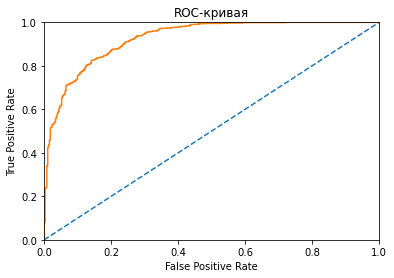

In [102]:
accuracy = accuracy_score(target_test, pred_test)
print(accuracy)

probabilities_test = cat.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

probabilities_test = cat.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(roc_auc_score(target_test, probabilities_one_test))

In [103]:
cat = CatBoostClassifier(iterations  = 10000, learning_rate = 0.025, max_depth = 4, random_state=12345)
cat.fit(features_upsampled, target_upsampled)
pred_valid = grid_result.predict(features_test)

0:	learn: 0.6831543	total: 1.75ms	remaining: 17.5s
1:	learn: 0.6738129	total: 3.69ms	remaining: 18.5s
2:	learn: 0.6649662	total: 5.43ms	remaining: 18.1s
3:	learn: 0.6565851	total: 7.08ms	remaining: 17.7s
4:	learn: 0.6489721	total: 8.67ms	remaining: 17.3s
5:	learn: 0.6419200	total: 10.3ms	remaining: 17.2s
6:	learn: 0.6348546	total: 12ms	remaining: 17.1s
7:	learn: 0.6278943	total: 13.6ms	remaining: 16.9s
8:	learn: 0.6225666	total: 15.1ms	remaining: 16.8s
9:	learn: 0.6166081	total: 16.8ms	remaining: 16.8s
10:	learn: 0.6110486	total: 18.4ms	remaining: 16.7s
11:	learn: 0.6056954	total: 19.9ms	remaining: 16.6s
12:	learn: 0.6002349	total: 21.6ms	remaining: 16.6s
13:	learn: 0.5954010	total: 23.1ms	remaining: 16.5s
14:	learn: 0.5909615	total: 24.6ms	remaining: 16.4s
15:	learn: 0.5865262	total: 26.2ms	remaining: 16.3s
16:	learn: 0.5818665	total: 27.8ms	remaining: 16.3s
17:	learn: 0.5775491	total: 29.3ms	remaining: 16.3s
18:	learn: 0.5721279	total: 30.6ms	remaining: 16.1s
19:	learn: 0.5688012	tot

171:	learn: 0.4532821	total: 236ms	remaining: 13.5s
172:	learn: 0.4530908	total: 237ms	remaining: 13.5s
173:	learn: 0.4529461	total: 238ms	remaining: 13.5s
174:	learn: 0.4526888	total: 240ms	remaining: 13.5s
175:	learn: 0.4524386	total: 241ms	remaining: 13.5s
176:	learn: 0.4522931	total: 243ms	remaining: 13.5s
177:	learn: 0.4521177	total: 244ms	remaining: 13.5s
178:	learn: 0.4520589	total: 245ms	remaining: 13.5s
179:	learn: 0.4519922	total: 247ms	remaining: 13.5s
180:	learn: 0.4517141	total: 248ms	remaining: 13.5s
181:	learn: 0.4513815	total: 249ms	remaining: 13.4s
182:	learn: 0.4510426	total: 251ms	remaining: 13.4s
183:	learn: 0.4502108	total: 252ms	remaining: 13.4s
184:	learn: 0.4501466	total: 253ms	remaining: 13.4s
185:	learn: 0.4500214	total: 255ms	remaining: 13.4s
186:	learn: 0.4499106	total: 256ms	remaining: 13.4s
187:	learn: 0.4498081	total: 258ms	remaining: 13.4s
188:	learn: 0.4494326	total: 259ms	remaining: 13.4s
189:	learn: 0.4492580	total: 260ms	remaining: 13.4s
190:	learn: 

385:	learn: 0.4111886	total: 526ms	remaining: 13.1s
386:	learn: 0.4109169	total: 527ms	remaining: 13.1s
387:	learn: 0.4108421	total: 528ms	remaining: 13.1s
388:	learn: 0.4106577	total: 530ms	remaining: 13.1s
389:	learn: 0.4105865	total: 531ms	remaining: 13.1s
390:	learn: 0.4104621	total: 532ms	remaining: 13.1s
391:	learn: 0.4102337	total: 534ms	remaining: 13.1s
392:	learn: 0.4097347	total: 535ms	remaining: 13.1s
393:	learn: 0.4096099	total: 537ms	remaining: 13.1s
394:	learn: 0.4093025	total: 538ms	remaining: 13.1s
395:	learn: 0.4092062	total: 539ms	remaining: 13.1s
396:	learn: 0.4091310	total: 541ms	remaining: 13.1s
397:	learn: 0.4087372	total: 542ms	remaining: 13.1s
398:	learn: 0.4085252	total: 543ms	remaining: 13.1s
399:	learn: 0.4082532	total: 545ms	remaining: 13.1s
400:	learn: 0.4078659	total: 546ms	remaining: 13.1s
401:	learn: 0.4076392	total: 547ms	remaining: 13.1s
402:	learn: 0.4075013	total: 549ms	remaining: 13.1s
403:	learn: 0.4074196	total: 550ms	remaining: 13.1s
404:	learn: 

554:	learn: 0.3810694	total: 753ms	remaining: 12.8s
555:	learn: 0.3807553	total: 755ms	remaining: 12.8s
556:	learn: 0.3807079	total: 756ms	remaining: 12.8s
557:	learn: 0.3805996	total: 758ms	remaining: 12.8s
558:	learn: 0.3804096	total: 759ms	remaining: 12.8s
559:	learn: 0.3801814	total: 760ms	remaining: 12.8s
560:	learn: 0.3801156	total: 762ms	remaining: 12.8s
561:	learn: 0.3798768	total: 763ms	remaining: 12.8s
562:	learn: 0.3797762	total: 764ms	remaining: 12.8s
563:	learn: 0.3796598	total: 766ms	remaining: 12.8s
564:	learn: 0.3794758	total: 767ms	remaining: 12.8s
565:	learn: 0.3793179	total: 768ms	remaining: 12.8s
566:	learn: 0.3792556	total: 770ms	remaining: 12.8s
567:	learn: 0.3791294	total: 771ms	remaining: 12.8s
568:	learn: 0.3790897	total: 772ms	remaining: 12.8s
569:	learn: 0.3785477	total: 774ms	remaining: 12.8s
570:	learn: 0.3782314	total: 775ms	remaining: 12.8s
571:	learn: 0.3780572	total: 777ms	remaining: 12.8s
572:	learn: 0.3777318	total: 778ms	remaining: 12.8s
573:	learn: 

762:	learn: 0.3470032	total: 1.03s	remaining: 12.5s
763:	learn: 0.3467953	total: 1.04s	remaining: 12.5s
764:	learn: 0.3466764	total: 1.04s	remaining: 12.5s
765:	learn: 0.3465271	total: 1.04s	remaining: 12.5s
766:	learn: 0.3462224	total: 1.04s	remaining: 12.5s
767:	learn: 0.3461254	total: 1.04s	remaining: 12.5s
768:	learn: 0.3458929	total: 1.04s	remaining: 12.5s
769:	learn: 0.3457942	total: 1.04s	remaining: 12.5s
770:	learn: 0.3457207	total: 1.04s	remaining: 12.5s
771:	learn: 0.3455215	total: 1.05s	remaining: 12.5s
772:	learn: 0.3454502	total: 1.05s	remaining: 12.5s
773:	learn: 0.3454139	total: 1.05s	remaining: 12.5s
774:	learn: 0.3452779	total: 1.05s	remaining: 12.5s
775:	learn: 0.3451576	total: 1.05s	remaining: 12.5s
776:	learn: 0.3450495	total: 1.05s	remaining: 12.5s
777:	learn: 0.3448605	total: 1.05s	remaining: 12.5s
778:	learn: 0.3448046	total: 1.06s	remaining: 12.5s
779:	learn: 0.3446211	total: 1.06s	remaining: 12.5s
780:	learn: 0.3443570	total: 1.06s	remaining: 12.5s
781:	learn: 

945:	learn: 0.3287282	total: 1.28s	remaining: 12.2s
946:	learn: 0.3285264	total: 1.28s	remaining: 12.2s
947:	learn: 0.3284007	total: 1.28s	remaining: 12.2s
948:	learn: 0.3283349	total: 1.28s	remaining: 12.2s
949:	learn: 0.3282008	total: 1.28s	remaining: 12.2s
950:	learn: 0.3281747	total: 1.28s	remaining: 12.2s
951:	learn: 0.3277906	total: 1.28s	remaining: 12.2s
952:	learn: 0.3276666	total: 1.29s	remaining: 12.2s
953:	learn: 0.3276213	total: 1.29s	remaining: 12.2s
954:	learn: 0.3275978	total: 1.29s	remaining: 12.2s
955:	learn: 0.3275387	total: 1.29s	remaining: 12.2s
956:	learn: 0.3275066	total: 1.29s	remaining: 12.2s
957:	learn: 0.3272873	total: 1.29s	remaining: 12.2s
958:	learn: 0.3272635	total: 1.29s	remaining: 12.2s
959:	learn: 0.3271519	total: 1.29s	remaining: 12.2s
960:	learn: 0.3269655	total: 1.3s	remaining: 12.2s
961:	learn: 0.3269066	total: 1.3s	remaining: 12.2s
962:	learn: 0.3268243	total: 1.3s	remaining: 12.2s
963:	learn: 0.3267777	total: 1.3s	remaining: 12.2s
964:	learn: 0.32

1154:	learn: 0.3093907	total: 1.55s	remaining: 11.9s
1155:	learn: 0.3093199	total: 1.55s	remaining: 11.9s
1156:	learn: 0.3092491	total: 1.56s	remaining: 11.9s
1157:	learn: 0.3092252	total: 1.56s	remaining: 11.9s
1158:	learn: 0.3092050	total: 1.56s	remaining: 11.9s
1159:	learn: 0.3091214	total: 1.56s	remaining: 11.9s
1160:	learn: 0.3090613	total: 1.56s	remaining: 11.9s
1161:	learn: 0.3090250	total: 1.56s	remaining: 11.9s
1162:	learn: 0.3089951	total: 1.56s	remaining: 11.9s
1163:	learn: 0.3089599	total: 1.57s	remaining: 11.9s
1164:	learn: 0.3089247	total: 1.57s	remaining: 11.9s
1165:	learn: 0.3088641	total: 1.57s	remaining: 11.9s
1166:	learn: 0.3088044	total: 1.57s	remaining: 11.9s
1167:	learn: 0.3087605	total: 1.57s	remaining: 11.9s
1168:	learn: 0.3086438	total: 1.57s	remaining: 11.9s
1169:	learn: 0.3086122	total: 1.57s	remaining: 11.9s
1170:	learn: 0.3083596	total: 1.57s	remaining: 11.9s
1171:	learn: 0.3083101	total: 1.58s	remaining: 11.9s
1172:	learn: 0.3081382	total: 1.58s	remaining:

1329:	learn: 0.2971750	total: 1.79s	remaining: 11.7s
1330:	learn: 0.2971019	total: 1.79s	remaining: 11.6s
1331:	learn: 0.2970732	total: 1.79s	remaining: 11.6s
1332:	learn: 0.2970023	total: 1.79s	remaining: 11.6s
1333:	learn: 0.2969579	total: 1.79s	remaining: 11.6s
1334:	learn: 0.2969208	total: 1.79s	remaining: 11.6s
1335:	learn: 0.2967919	total: 1.79s	remaining: 11.6s
1336:	learn: 0.2967757	total: 1.8s	remaining: 11.6s
1337:	learn: 0.2966490	total: 1.8s	remaining: 11.6s
1338:	learn: 0.2965993	total: 1.8s	remaining: 11.6s
1339:	learn: 0.2965590	total: 1.8s	remaining: 11.6s
1340:	learn: 0.2964923	total: 1.8s	remaining: 11.6s
1341:	learn: 0.2964535	total: 1.8s	remaining: 11.6s
1342:	learn: 0.2964032	total: 1.8s	remaining: 11.6s
1343:	learn: 0.2963784	total: 1.81s	remaining: 11.6s
1344:	learn: 0.2963514	total: 1.81s	remaining: 11.6s
1345:	learn: 0.2962793	total: 1.81s	remaining: 11.6s
1346:	learn: 0.2962050	total: 1.81s	remaining: 11.6s
1347:	learn: 0.2961652	total: 1.81s	remaining: 11.6s


1547:	learn: 0.2842558	total: 2.08s	remaining: 11.3s
1548:	learn: 0.2842143	total: 2.08s	remaining: 11.3s
1549:	learn: 0.2841280	total: 2.08s	remaining: 11.3s
1550:	learn: 0.2841049	total: 2.08s	remaining: 11.3s
1551:	learn: 0.2840644	total: 2.08s	remaining: 11.3s
1552:	learn: 0.2839639	total: 2.08s	remaining: 11.3s
1553:	learn: 0.2839329	total: 2.09s	remaining: 11.3s
1554:	learn: 0.2839128	total: 2.09s	remaining: 11.3s
1555:	learn: 0.2838942	total: 2.09s	remaining: 11.3s
1556:	learn: 0.2838785	total: 2.09s	remaining: 11.3s
1557:	learn: 0.2838641	total: 2.09s	remaining: 11.3s
1558:	learn: 0.2838270	total: 2.09s	remaining: 11.3s
1559:	learn: 0.2837483	total: 2.09s	remaining: 11.3s
1560:	learn: 0.2836554	total: 2.1s	remaining: 11.3s
1561:	learn: 0.2835823	total: 2.1s	remaining: 11.3s
1562:	learn: 0.2835602	total: 2.1s	remaining: 11.3s
1563:	learn: 0.2835490	total: 2.1s	remaining: 11.3s
1564:	learn: 0.2835232	total: 2.1s	remaining: 11.3s
1565:	learn: 0.2832556	total: 2.1s	remaining: 11.3s

1718:	learn: 0.2748591	total: 2.31s	remaining: 11.1s
1719:	learn: 0.2748491	total: 2.31s	remaining: 11.1s
1720:	learn: 0.2747414	total: 2.31s	remaining: 11.1s
1721:	learn: 0.2747162	total: 2.31s	remaining: 11.1s
1722:	learn: 0.2746680	total: 2.31s	remaining: 11.1s
1723:	learn: 0.2746535	total: 2.31s	remaining: 11.1s
1724:	learn: 0.2745212	total: 2.31s	remaining: 11.1s
1725:	learn: 0.2744598	total: 2.31s	remaining: 11.1s
1726:	learn: 0.2743939	total: 2.32s	remaining: 11.1s
1727:	learn: 0.2743735	total: 2.32s	remaining: 11.1s
1728:	learn: 0.2743475	total: 2.32s	remaining: 11.1s
1729:	learn: 0.2743021	total: 2.32s	remaining: 11.1s
1730:	learn: 0.2742467	total: 2.32s	remaining: 11.1s
1731:	learn: 0.2741266	total: 2.32s	remaining: 11.1s
1732:	learn: 0.2740973	total: 2.32s	remaining: 11.1s
1733:	learn: 0.2740780	total: 2.33s	remaining: 11.1s
1734:	learn: 0.2740505	total: 2.33s	remaining: 11.1s
1735:	learn: 0.2739453	total: 2.33s	remaining: 11.1s
1736:	learn: 0.2738993	total: 2.33s	remaining:

1928:	learn: 0.2644238	total: 2.59s	remaining: 10.8s
1929:	learn: 0.2643029	total: 2.59s	remaining: 10.8s
1930:	learn: 0.2642856	total: 2.59s	remaining: 10.8s
1931:	learn: 0.2642522	total: 2.59s	remaining: 10.8s
1932:	learn: 0.2642430	total: 2.59s	remaining: 10.8s
1933:	learn: 0.2641836	total: 2.59s	remaining: 10.8s
1934:	learn: 0.2641411	total: 2.59s	remaining: 10.8s
1935:	learn: 0.2641021	total: 2.6s	remaining: 10.8s
1936:	learn: 0.2640631	total: 2.6s	remaining: 10.8s
1937:	learn: 0.2640420	total: 2.6s	remaining: 10.8s
1938:	learn: 0.2639986	total: 2.6s	remaining: 10.8s
1939:	learn: 0.2639534	total: 2.6s	remaining: 10.8s
1940:	learn: 0.2639070	total: 2.6s	remaining: 10.8s
1941:	learn: 0.2638575	total: 2.6s	remaining: 10.8s
1942:	learn: 0.2638019	total: 2.6s	remaining: 10.8s
1943:	learn: 0.2637703	total: 2.61s	remaining: 10.8s
1944:	learn: 0.2637530	total: 2.61s	remaining: 10.8s
1945:	learn: 0.2636632	total: 2.61s	remaining: 10.8s
1946:	learn: 0.2636266	total: 2.61s	remaining: 10.8s
1

2105:	learn: 0.2572739	total: 2.82s	remaining: 10.6s
2106:	learn: 0.2572330	total: 2.83s	remaining: 10.6s
2107:	learn: 0.2572048	total: 2.83s	remaining: 10.6s
2108:	learn: 0.2571872	total: 2.83s	remaining: 10.6s
2109:	learn: 0.2570967	total: 2.83s	remaining: 10.6s
2110:	learn: 0.2570724	total: 2.83s	remaining: 10.6s
2111:	learn: 0.2570112	total: 2.83s	remaining: 10.6s
2112:	learn: 0.2569330	total: 2.83s	remaining: 10.6s
2113:	learn: 0.2569158	total: 2.83s	remaining: 10.6s
2114:	learn: 0.2568874	total: 2.84s	remaining: 10.6s
2115:	learn: 0.2568464	total: 2.84s	remaining: 10.6s
2116:	learn: 0.2568276	total: 2.84s	remaining: 10.6s
2117:	learn: 0.2567966	total: 2.84s	remaining: 10.6s
2118:	learn: 0.2567569	total: 2.84s	remaining: 10.6s
2119:	learn: 0.2567018	total: 2.84s	remaining: 10.6s
2120:	learn: 0.2566594	total: 2.84s	remaining: 10.6s
2121:	learn: 0.2566325	total: 2.85s	remaining: 10.6s
2122:	learn: 0.2565984	total: 2.85s	remaining: 10.6s
2123:	learn: 0.2565688	total: 2.85s	remaining:

2314:	learn: 0.2491651	total: 3.1s	remaining: 10.3s
2315:	learn: 0.2491313	total: 3.11s	remaining: 10.3s
2316:	learn: 0.2490998	total: 3.11s	remaining: 10.3s
2317:	learn: 0.2490615	total: 3.11s	remaining: 10.3s
2318:	learn: 0.2490222	total: 3.11s	remaining: 10.3s
2319:	learn: 0.2489661	total: 3.11s	remaining: 10.3s
2320:	learn: 0.2489379	total: 3.11s	remaining: 10.3s
2321:	learn: 0.2488930	total: 3.11s	remaining: 10.3s
2322:	learn: 0.2488444	total: 3.12s	remaining: 10.3s
2323:	learn: 0.2488118	total: 3.12s	remaining: 10.3s
2324:	learn: 0.2487596	total: 3.12s	remaining: 10.3s
2325:	learn: 0.2487070	total: 3.12s	remaining: 10.3s
2326:	learn: 0.2486909	total: 3.12s	remaining: 10.3s
2327:	learn: 0.2486822	total: 3.12s	remaining: 10.3s
2328:	learn: 0.2486329	total: 3.12s	remaining: 10.3s
2329:	learn: 0.2485951	total: 3.13s	remaining: 10.3s
2330:	learn: 0.2485580	total: 3.13s	remaining: 10.3s
2331:	learn: 0.2485211	total: 3.13s	remaining: 10.3s
2332:	learn: 0.2484907	total: 3.13s	remaining: 

2484:	learn: 0.2429012	total: 3.33s	remaining: 10.1s
2485:	learn: 0.2428803	total: 3.33s	remaining: 10.1s
2486:	learn: 0.2428334	total: 3.34s	remaining: 10.1s
2487:	learn: 0.2428161	total: 3.34s	remaining: 10.1s
2488:	learn: 0.2427658	total: 3.34s	remaining: 10.1s
2489:	learn: 0.2427410	total: 3.34s	remaining: 10.1s
2490:	learn: 0.2427098	total: 3.34s	remaining: 10.1s
2491:	learn: 0.2426919	total: 3.34s	remaining: 10.1s
2492:	learn: 0.2426804	total: 3.34s	remaining: 10.1s
2493:	learn: 0.2426472	total: 3.35s	remaining: 10.1s
2494:	learn: 0.2426396	total: 3.35s	remaining: 10.1s
2495:	learn: 0.2426108	total: 3.35s	remaining: 10.1s
2496:	learn: 0.2426040	total: 3.35s	remaining: 10.1s
2497:	learn: 0.2425807	total: 3.35s	remaining: 10.1s
2498:	learn: 0.2425623	total: 3.35s	remaining: 10.1s
2499:	learn: 0.2425467	total: 3.35s	remaining: 10.1s
2500:	learn: 0.2425235	total: 3.35s	remaining: 10.1s
2501:	learn: 0.2424631	total: 3.36s	remaining: 10.1s
2502:	learn: 0.2424208	total: 3.36s	remaining:

2705:	learn: 0.2359862	total: 3.63s	remaining: 9.78s
2706:	learn: 0.2359751	total: 3.63s	remaining: 9.78s
2707:	learn: 0.2359528	total: 3.63s	remaining: 9.78s
2708:	learn: 0.2359348	total: 3.63s	remaining: 9.78s
2709:	learn: 0.2359175	total: 3.63s	remaining: 9.78s
2710:	learn: 0.2358986	total: 3.64s	remaining: 9.78s
2711:	learn: 0.2358082	total: 3.64s	remaining: 9.78s
2712:	learn: 0.2357834	total: 3.64s	remaining: 9.77s
2713:	learn: 0.2357433	total: 3.64s	remaining: 9.77s
2714:	learn: 0.2357301	total: 3.64s	remaining: 9.77s
2715:	learn: 0.2357193	total: 3.64s	remaining: 9.77s
2716:	learn: 0.2356653	total: 3.64s	remaining: 9.77s
2717:	learn: 0.2356363	total: 3.65s	remaining: 9.77s
2718:	learn: 0.2356251	total: 3.65s	remaining: 9.77s
2719:	learn: 0.2355983	total: 3.65s	remaining: 9.77s
2720:	learn: 0.2355496	total: 3.65s	remaining: 9.76s
2721:	learn: 0.2355197	total: 3.65s	remaining: 9.76s
2722:	learn: 0.2355002	total: 3.65s	remaining: 9.76s
2723:	learn: 0.2354834	total: 3.65s	remaining:

2875:	learn: 0.2316130	total: 3.86s	remaining: 9.55s
2876:	learn: 0.2315906	total: 3.86s	remaining: 9.55s
2877:	learn: 0.2315627	total: 3.86s	remaining: 9.55s
2878:	learn: 0.2315393	total: 3.86s	remaining: 9.55s
2879:	learn: 0.2314997	total: 3.86s	remaining: 9.55s
2880:	learn: 0.2314286	total: 3.86s	remaining: 9.55s
2881:	learn: 0.2313945	total: 3.86s	remaining: 9.54s
2882:	learn: 0.2313738	total: 3.87s	remaining: 9.54s
2883:	learn: 0.2313110	total: 3.87s	remaining: 9.54s
2884:	learn: 0.2312866	total: 3.87s	remaining: 9.54s
2885:	learn: 0.2312738	total: 3.87s	remaining: 9.54s
2886:	learn: 0.2312389	total: 3.87s	remaining: 9.54s
2887:	learn: 0.2312019	total: 3.87s	remaining: 9.54s
2888:	learn: 0.2311850	total: 3.87s	remaining: 9.54s
2889:	learn: 0.2311689	total: 3.88s	remaining: 9.53s
2890:	learn: 0.2311340	total: 3.88s	remaining: 9.53s
2891:	learn: 0.2310913	total: 3.88s	remaining: 9.53s
2892:	learn: 0.2310611	total: 3.88s	remaining: 9.53s
2893:	learn: 0.2310454	total: 3.88s	remaining:

3094:	learn: 0.2260446	total: 4.15s	remaining: 9.26s
3095:	learn: 0.2260324	total: 4.15s	remaining: 9.25s
3096:	learn: 0.2260199	total: 4.15s	remaining: 9.25s
3097:	learn: 0.2260027	total: 4.15s	remaining: 9.25s
3098:	learn: 0.2259823	total: 4.15s	remaining: 9.25s
3099:	learn: 0.2259590	total: 4.16s	remaining: 9.25s
3100:	learn: 0.2259258	total: 4.16s	remaining: 9.25s
3101:	learn: 0.2259128	total: 4.16s	remaining: 9.25s
3102:	learn: 0.2258824	total: 4.16s	remaining: 9.24s
3103:	learn: 0.2258630	total: 4.16s	remaining: 9.24s
3104:	learn: 0.2258395	total: 4.16s	remaining: 9.24s
3105:	learn: 0.2258280	total: 4.16s	remaining: 9.24s
3106:	learn: 0.2258024	total: 4.16s	remaining: 9.24s
3107:	learn: 0.2257548	total: 4.17s	remaining: 9.24s
3108:	learn: 0.2257286	total: 4.17s	remaining: 9.24s
3109:	learn: 0.2257058	total: 4.17s	remaining: 9.23s
3110:	learn: 0.2256848	total: 4.17s	remaining: 9.23s
3111:	learn: 0.2256624	total: 4.17s	remaining: 9.23s
3112:	learn: 0.2256501	total: 4.17s	remaining:

3259:	learn: 0.2224607	total: 4.37s	remaining: 9.03s
3260:	learn: 0.2224021	total: 4.37s	remaining: 9.03s
3261:	learn: 0.2223838	total: 4.37s	remaining: 9.03s
3262:	learn: 0.2223267	total: 4.37s	remaining: 9.03s
3263:	learn: 0.2223101	total: 4.37s	remaining: 9.03s
3264:	learn: 0.2222881	total: 4.37s	remaining: 9.02s
3265:	learn: 0.2222453	total: 4.38s	remaining: 9.02s
3266:	learn: 0.2222053	total: 4.38s	remaining: 9.02s
3267:	learn: 0.2221899	total: 4.38s	remaining: 9.02s
3268:	learn: 0.2221668	total: 4.38s	remaining: 9.02s
3269:	learn: 0.2221524	total: 4.38s	remaining: 9.02s
3270:	learn: 0.2221405	total: 4.38s	remaining: 9.02s
3271:	learn: 0.2221174	total: 4.38s	remaining: 9.01s
3272:	learn: 0.2220537	total: 4.38s	remaining: 9.01s
3273:	learn: 0.2220161	total: 4.39s	remaining: 9.01s
3274:	learn: 0.2219925	total: 4.39s	remaining: 9.01s
3275:	learn: 0.2219393	total: 4.39s	remaining: 9.01s
3276:	learn: 0.2219185	total: 4.39s	remaining: 9.01s
3277:	learn: 0.2219005	total: 4.39s	remaining:

3476:	learn: 0.2175231	total: 4.66s	remaining: 8.74s
3477:	learn: 0.2174967	total: 4.66s	remaining: 8.74s
3478:	learn: 0.2174858	total: 4.66s	remaining: 8.74s
3479:	learn: 0.2174508	total: 4.66s	remaining: 8.73s
3480:	learn: 0.2174314	total: 4.66s	remaining: 8.73s
3481:	learn: 0.2174181	total: 4.66s	remaining: 8.73s
3482:	learn: 0.2173835	total: 4.67s	remaining: 8.73s
3483:	learn: 0.2173722	total: 4.67s	remaining: 8.73s
3484:	learn: 0.2173537	total: 4.67s	remaining: 8.73s
3485:	learn: 0.2173373	total: 4.67s	remaining: 8.73s
3486:	learn: 0.2173309	total: 4.67s	remaining: 8.72s
3487:	learn: 0.2173076	total: 4.67s	remaining: 8.72s
3488:	learn: 0.2173001	total: 4.67s	remaining: 8.72s
3489:	learn: 0.2172711	total: 4.67s	remaining: 8.72s
3490:	learn: 0.2172569	total: 4.68s	remaining: 8.72s
3491:	learn: 0.2172284	total: 4.68s	remaining: 8.72s
3492:	learn: 0.2172172	total: 4.68s	remaining: 8.72s
3493:	learn: 0.2171957	total: 4.68s	remaining: 8.72s
3494:	learn: 0.2171800	total: 4.68s	remaining:

3648:	learn: 0.2138725	total: 4.88s	remaining: 8.5s
3649:	learn: 0.2137840	total: 4.89s	remaining: 8.5s
3650:	learn: 0.2137512	total: 4.89s	remaining: 8.5s
3651:	learn: 0.2137448	total: 4.89s	remaining: 8.5s
3652:	learn: 0.2137327	total: 4.89s	remaining: 8.5s
3653:	learn: 0.2137133	total: 4.89s	remaining: 8.5s
3654:	learn: 0.2136925	total: 4.89s	remaining: 8.49s
3655:	learn: 0.2136675	total: 4.89s	remaining: 8.49s
3656:	learn: 0.2136158	total: 4.9s	remaining: 8.49s
3657:	learn: 0.2135913	total: 4.9s	remaining: 8.49s
3658:	learn: 0.2135727	total: 4.9s	remaining: 8.49s
3659:	learn: 0.2135568	total: 4.9s	remaining: 8.49s
3660:	learn: 0.2135361	total: 4.9s	remaining: 8.49s
3661:	learn: 0.2135101	total: 4.9s	remaining: 8.48s
3662:	learn: 0.2134899	total: 4.9s	remaining: 8.48s
3663:	learn: 0.2134770	total: 4.91s	remaining: 8.48s
3664:	learn: 0.2134521	total: 4.91s	remaining: 8.48s
3665:	learn: 0.2134397	total: 4.91s	remaining: 8.48s
3666:	learn: 0.2134285	total: 4.91s	remaining: 8.48s
3667:	

3868:	learn: 0.2090606	total: 5.18s	remaining: 8.2s
3869:	learn: 0.2090084	total: 5.18s	remaining: 8.2s
3870:	learn: 0.2089938	total: 5.18s	remaining: 8.2s
3871:	learn: 0.2089759	total: 5.18s	remaining: 8.2s
3872:	learn: 0.2089498	total: 5.18s	remaining: 8.2s
3873:	learn: 0.2089307	total: 5.18s	remaining: 8.2s
3874:	learn: 0.2089112	total: 5.18s	remaining: 8.2s
3875:	learn: 0.2089016	total: 5.19s	remaining: 8.19s
3876:	learn: 0.2088803	total: 5.19s	remaining: 8.19s
3877:	learn: 0.2088711	total: 5.19s	remaining: 8.19s
3878:	learn: 0.2088486	total: 5.19s	remaining: 8.19s
3879:	learn: 0.2088364	total: 5.19s	remaining: 8.19s
3880:	learn: 0.2088187	total: 5.19s	remaining: 8.19s
3881:	learn: 0.2087876	total: 5.19s	remaining: 8.19s
3882:	learn: 0.2087641	total: 5.2s	remaining: 8.18s
3883:	learn: 0.2087524	total: 5.2s	remaining: 8.18s
3884:	learn: 0.2087469	total: 5.2s	remaining: 8.18s
3885:	learn: 0.2087105	total: 5.2s	remaining: 8.18s
3886:	learn: 0.2086810	total: 5.2s	remaining: 8.18s
3887:

4043:	learn: 0.2054685	total: 5.41s	remaining: 7.97s
4044:	learn: 0.2054501	total: 5.41s	remaining: 7.97s
4045:	learn: 0.2054255	total: 5.41s	remaining: 7.96s
4046:	learn: 0.2053815	total: 5.41s	remaining: 7.96s
4047:	learn: 0.2053576	total: 5.42s	remaining: 7.96s
4048:	learn: 0.2053490	total: 5.42s	remaining: 7.96s
4049:	learn: 0.2053342	total: 5.42s	remaining: 7.96s
4050:	learn: 0.2053165	total: 5.42s	remaining: 7.96s
4051:	learn: 0.2053042	total: 5.42s	remaining: 7.96s
4052:	learn: 0.2052923	total: 5.42s	remaining: 7.96s
4053:	learn: 0.2052698	total: 5.42s	remaining: 7.95s
4054:	learn: 0.2052573	total: 5.42s	remaining: 7.95s
4055:	learn: 0.2052313	total: 5.43s	remaining: 7.95s
4056:	learn: 0.2052121	total: 5.43s	remaining: 7.95s
4057:	learn: 0.2051813	total: 5.43s	remaining: 7.95s
4058:	learn: 0.2051635	total: 5.43s	remaining: 7.95s
4059:	learn: 0.2051587	total: 5.43s	remaining: 7.95s
4060:	learn: 0.2051456	total: 5.43s	remaining: 7.95s
4061:	learn: 0.2051261	total: 5.43s	remaining:

4259:	learn: 0.2010978	total: 5.7s	remaining: 7.68s
4260:	learn: 0.2010780	total: 5.7s	remaining: 7.68s
4261:	learn: 0.2010595	total: 5.7s	remaining: 7.68s
4262:	learn: 0.2010396	total: 5.71s	remaining: 7.68s
4263:	learn: 0.2010205	total: 5.71s	remaining: 7.68s
4264:	learn: 0.2010042	total: 5.71s	remaining: 7.67s
4265:	learn: 0.2009934	total: 5.71s	remaining: 7.67s
4266:	learn: 0.2009752	total: 5.71s	remaining: 7.67s
4267:	learn: 0.2009501	total: 5.71s	remaining: 7.67s
4268:	learn: 0.2009297	total: 5.71s	remaining: 7.67s
4269:	learn: 0.2009081	total: 5.71s	remaining: 7.67s
4270:	learn: 0.2009020	total: 5.72s	remaining: 7.67s
4271:	learn: 0.2008880	total: 5.72s	remaining: 7.67s
4272:	learn: 0.2008770	total: 5.72s	remaining: 7.66s
4273:	learn: 0.2008472	total: 5.72s	remaining: 7.66s
4274:	learn: 0.2008374	total: 5.72s	remaining: 7.66s
4275:	learn: 0.2008245	total: 5.72s	remaining: 7.66s
4276:	learn: 0.2008069	total: 5.72s	remaining: 7.66s
4277:	learn: 0.2007854	total: 5.72s	remaining: 7.

4422:	learn: 0.1979474	total: 5.92s	remaining: 7.46s
4423:	learn: 0.1979234	total: 5.92s	remaining: 7.46s
4424:	learn: 0.1978923	total: 5.92s	remaining: 7.46s
4425:	learn: 0.1978697	total: 5.92s	remaining: 7.46s
4426:	learn: 0.1978481	total: 5.93s	remaining: 7.46s
4427:	learn: 0.1978319	total: 5.93s	remaining: 7.46s
4428:	learn: 0.1978148	total: 5.93s	remaining: 7.46s
4429:	learn: 0.1978073	total: 5.93s	remaining: 7.46s
4430:	learn: 0.1977988	total: 5.93s	remaining: 7.46s
4431:	learn: 0.1977651	total: 5.93s	remaining: 7.45s
4432:	learn: 0.1977365	total: 5.93s	remaining: 7.45s
4433:	learn: 0.1977207	total: 5.93s	remaining: 7.45s
4434:	learn: 0.1977114	total: 5.94s	remaining: 7.45s
4435:	learn: 0.1976948	total: 5.94s	remaining: 7.45s
4436:	learn: 0.1976886	total: 5.94s	remaining: 7.45s
4437:	learn: 0.1976788	total: 5.94s	remaining: 7.45s
4438:	learn: 0.1976587	total: 5.94s	remaining: 7.44s
4439:	learn: 0.1976382	total: 5.94s	remaining: 7.44s
4440:	learn: 0.1976246	total: 5.95s	remaining:

4638:	learn: 0.1941691	total: 6.21s	remaining: 7.18s
4639:	learn: 0.1941499	total: 6.21s	remaining: 7.18s
4640:	learn: 0.1941311	total: 6.21s	remaining: 7.18s
4641:	learn: 0.1941266	total: 6.22s	remaining: 7.17s
4642:	learn: 0.1941131	total: 6.22s	remaining: 7.17s
4643:	learn: 0.1940997	total: 6.22s	remaining: 7.17s
4644:	learn: 0.1940850	total: 6.22s	remaining: 7.17s
4645:	learn: 0.1940707	total: 6.22s	remaining: 7.17s
4646:	learn: 0.1940644	total: 6.22s	remaining: 7.17s
4647:	learn: 0.1940512	total: 6.22s	remaining: 7.17s
4648:	learn: 0.1940396	total: 6.22s	remaining: 7.17s
4649:	learn: 0.1940282	total: 6.23s	remaining: 7.16s
4650:	learn: 0.1940195	total: 6.23s	remaining: 7.16s
4651:	learn: 0.1940074	total: 6.23s	remaining: 7.16s
4652:	learn: 0.1939861	total: 6.23s	remaining: 7.16s
4653:	learn: 0.1939504	total: 6.23s	remaining: 7.16s
4654:	learn: 0.1939396	total: 6.23s	remaining: 7.16s
4655:	learn: 0.1939100	total: 6.23s	remaining: 7.16s
4656:	learn: 0.1938954	total: 6.24s	remaining:

4807:	learn: 0.1914287	total: 6.44s	remaining: 6.95s
4808:	learn: 0.1914203	total: 6.44s	remaining: 6.95s
4809:	learn: 0.1913931	total: 6.44s	remaining: 6.95s
4810:	learn: 0.1913848	total: 6.44s	remaining: 6.95s
4811:	learn: 0.1913703	total: 6.44s	remaining: 6.95s
4812:	learn: 0.1913549	total: 6.45s	remaining: 6.95s
4813:	learn: 0.1913379	total: 6.45s	remaining: 6.94s
4814:	learn: 0.1913230	total: 6.45s	remaining: 6.94s
4815:	learn: 0.1913135	total: 6.45s	remaining: 6.94s
4816:	learn: 0.1912925	total: 6.45s	remaining: 6.94s
4817:	learn: 0.1912783	total: 6.45s	remaining: 6.94s
4818:	learn: 0.1912638	total: 6.45s	remaining: 6.94s
4819:	learn: 0.1912518	total: 6.45s	remaining: 6.94s
4820:	learn: 0.1912403	total: 6.46s	remaining: 6.93s
4821:	learn: 0.1912292	total: 6.46s	remaining: 6.93s
4822:	learn: 0.1912172	total: 6.46s	remaining: 6.93s
4823:	learn: 0.1912112	total: 6.46s	remaining: 6.93s
4824:	learn: 0.1911938	total: 6.46s	remaining: 6.93s
4825:	learn: 0.1911814	total: 6.46s	remaining:

5024:	learn: 0.1884194	total: 6.73s	remaining: 6.66s
5025:	learn: 0.1884154	total: 6.73s	remaining: 6.66s
5026:	learn: 0.1884100	total: 6.73s	remaining: 6.66s
5027:	learn: 0.1884037	total: 6.73s	remaining: 6.66s
5028:	learn: 0.1884000	total: 6.74s	remaining: 6.66s
5029:	learn: 0.1883880	total: 6.74s	remaining: 6.66s
5030:	learn: 0.1883636	total: 6.74s	remaining: 6.66s
5031:	learn: 0.1883492	total: 6.74s	remaining: 6.65s
5032:	learn: 0.1883416	total: 6.74s	remaining: 6.65s
5033:	learn: 0.1883205	total: 6.74s	remaining: 6.65s
5034:	learn: 0.1883139	total: 6.74s	remaining: 6.65s
5035:	learn: 0.1883012	total: 6.75s	remaining: 6.65s
5036:	learn: 0.1882900	total: 6.75s	remaining: 6.65s
5037:	learn: 0.1882868	total: 6.75s	remaining: 6.65s
5038:	learn: 0.1882786	total: 6.75s	remaining: 6.64s
5039:	learn: 0.1882654	total: 6.75s	remaining: 6.64s
5040:	learn: 0.1882520	total: 6.75s	remaining: 6.64s
5041:	learn: 0.1882354	total: 6.75s	remaining: 6.64s
5042:	learn: 0.1882264	total: 6.75s	remaining:

5191:	learn: 0.1862431	total: 6.96s	remaining: 6.45s
5192:	learn: 0.1862210	total: 6.96s	remaining: 6.44s
5193:	learn: 0.1862003	total: 6.96s	remaining: 6.44s
5194:	learn: 0.1861778	total: 6.96s	remaining: 6.44s
5195:	learn: 0.1861493	total: 6.97s	remaining: 6.44s
5196:	learn: 0.1861468	total: 6.97s	remaining: 6.44s
5197:	learn: 0.1861379	total: 6.97s	remaining: 6.44s
5198:	learn: 0.1861276	total: 6.97s	remaining: 6.44s
5199:	learn: 0.1861214	total: 6.97s	remaining: 6.43s
5200:	learn: 0.1861044	total: 6.97s	remaining: 6.43s
5201:	learn: 0.1860932	total: 6.97s	remaining: 6.43s
5202:	learn: 0.1860908	total: 6.97s	remaining: 6.43s
5203:	learn: 0.1860850	total: 6.98s	remaining: 6.43s
5204:	learn: 0.1860717	total: 6.98s	remaining: 6.43s
5205:	learn: 0.1860578	total: 6.98s	remaining: 6.43s
5206:	learn: 0.1860496	total: 6.98s	remaining: 6.43s
5207:	learn: 0.1860464	total: 6.98s	remaining: 6.42s
5208:	learn: 0.1860334	total: 6.98s	remaining: 6.42s
5209:	learn: 0.1860177	total: 6.99s	remaining:

5406:	learn: 0.1833743	total: 7.25s	remaining: 6.16s
5407:	learn: 0.1833620	total: 7.25s	remaining: 6.16s
5408:	learn: 0.1833499	total: 7.25s	remaining: 6.16s
5409:	learn: 0.1833418	total: 7.25s	remaining: 6.16s
5410:	learn: 0.1833354	total: 7.26s	remaining: 6.15s
5411:	learn: 0.1833123	total: 7.26s	remaining: 6.15s
5412:	learn: 0.1832937	total: 7.26s	remaining: 6.15s
5413:	learn: 0.1832904	total: 7.26s	remaining: 6.15s
5414:	learn: 0.1832765	total: 7.26s	remaining: 6.15s
5415:	learn: 0.1832678	total: 7.26s	remaining: 6.15s
5416:	learn: 0.1832571	total: 7.26s	remaining: 6.14s
5417:	learn: 0.1832436	total: 7.26s	remaining: 6.14s
5418:	learn: 0.1832299	total: 7.27s	remaining: 6.14s
5419:	learn: 0.1832271	total: 7.27s	remaining: 6.14s
5420:	learn: 0.1832135	total: 7.27s	remaining: 6.14s
5421:	learn: 0.1832092	total: 7.27s	remaining: 6.14s
5422:	learn: 0.1831875	total: 7.27s	remaining: 6.14s
5423:	learn: 0.1831785	total: 7.27s	remaining: 6.14s
5424:	learn: 0.1831542	total: 7.27s	remaining:

5569:	learn: 0.1813538	total: 7.48s	remaining: 5.95s
5570:	learn: 0.1813340	total: 7.48s	remaining: 5.94s
5571:	learn: 0.1813311	total: 7.48s	remaining: 5.94s
5572:	learn: 0.1813106	total: 7.48s	remaining: 5.94s
5573:	learn: 0.1813060	total: 7.48s	remaining: 5.94s
5574:	learn: 0.1812885	total: 7.48s	remaining: 5.94s
5575:	learn: 0.1812765	total: 7.48s	remaining: 5.94s
5576:	learn: 0.1812423	total: 7.49s	remaining: 5.94s
5577:	learn: 0.1812330	total: 7.49s	remaining: 5.93s
5578:	learn: 0.1812086	total: 7.49s	remaining: 5.93s
5579:	learn: 0.1811977	total: 7.49s	remaining: 5.93s
5580:	learn: 0.1811765	total: 7.49s	remaining: 5.93s
5581:	learn: 0.1811593	total: 7.49s	remaining: 5.93s
5582:	learn: 0.1811417	total: 7.49s	remaining: 5.93s
5583:	learn: 0.1811368	total: 7.5s	remaining: 5.93s
5584:	learn: 0.1811344	total: 7.5s	remaining: 5.93s
5585:	learn: 0.1811160	total: 7.5s	remaining: 5.92s
5586:	learn: 0.1811027	total: 7.5s	remaining: 5.92s
5587:	learn: 0.1810905	total: 7.5s	remaining: 5.92

5774:	learn: 0.1785009	total: 7.76s	remaining: 5.67s
5775:	learn: 0.1784661	total: 7.76s	remaining: 5.67s
5776:	learn: 0.1784535	total: 7.76s	remaining: 5.67s
5777:	learn: 0.1784464	total: 7.76s	remaining: 5.67s
5778:	learn: 0.1784293	total: 7.76s	remaining: 5.67s
5779:	learn: 0.1783965	total: 7.76s	remaining: 5.67s
5780:	learn: 0.1783807	total: 7.76s	remaining: 5.67s
5781:	learn: 0.1783776	total: 7.76s	remaining: 5.67s
5782:	learn: 0.1783589	total: 7.77s	remaining: 5.66s
5783:	learn: 0.1783411	total: 7.77s	remaining: 5.66s
5784:	learn: 0.1783254	total: 7.77s	remaining: 5.66s
5785:	learn: 0.1783029	total: 7.77s	remaining: 5.66s
5786:	learn: 0.1782929	total: 7.77s	remaining: 5.66s
5787:	learn: 0.1782870	total: 7.77s	remaining: 5.66s
5788:	learn: 0.1782793	total: 7.77s	remaining: 5.66s
5789:	learn: 0.1782491	total: 7.78s	remaining: 5.65s
5790:	learn: 0.1782353	total: 7.78s	remaining: 5.65s
5791:	learn: 0.1782293	total: 7.78s	remaining: 5.65s
5792:	learn: 0.1782166	total: 7.78s	remaining:

5941:	learn: 0.1763958	total: 7.98s	remaining: 5.45s
5942:	learn: 0.1763844	total: 7.98s	remaining: 5.45s
5943:	learn: 0.1763621	total: 7.99s	remaining: 5.45s
5944:	learn: 0.1763513	total: 7.99s	remaining: 5.45s
5945:	learn: 0.1763410	total: 7.99s	remaining: 5.45s
5946:	learn: 0.1763128	total: 7.99s	remaining: 5.44s
5947:	learn: 0.1762809	total: 7.99s	remaining: 5.44s
5948:	learn: 0.1762646	total: 7.99s	remaining: 5.44s
5949:	learn: 0.1762545	total: 7.99s	remaining: 5.44s
5950:	learn: 0.1762447	total: 7.99s	remaining: 5.44s
5951:	learn: 0.1762385	total: 8s	remaining: 5.44s
5952:	learn: 0.1762331	total: 8s	remaining: 5.44s
5953:	learn: 0.1762235	total: 8s	remaining: 5.43s
5954:	learn: 0.1762118	total: 8s	remaining: 5.43s
5955:	learn: 0.1762023	total: 8s	remaining: 5.43s
5956:	learn: 0.1761953	total: 8s	remaining: 5.43s
5957:	learn: 0.1761845	total: 8s	remaining: 5.43s
5958:	learn: 0.1761788	total: 8.01s	remaining: 5.43s
5959:	learn: 0.1761677	total: 8.01s	remaining: 5.43s
5960:	learn: 0

6157:	learn: 0.1737901	total: 8.27s	remaining: 5.16s
6158:	learn: 0.1737826	total: 8.27s	remaining: 5.16s
6159:	learn: 0.1737756	total: 8.28s	remaining: 5.16s
6160:	learn: 0.1737686	total: 8.28s	remaining: 5.16s
6161:	learn: 0.1737475	total: 8.28s	remaining: 5.16s
6162:	learn: 0.1737373	total: 8.28s	remaining: 5.15s
6163:	learn: 0.1737332	total: 8.28s	remaining: 5.15s
6164:	learn: 0.1737214	total: 8.28s	remaining: 5.15s
6165:	learn: 0.1737091	total: 8.28s	remaining: 5.15s
6166:	learn: 0.1736982	total: 8.28s	remaining: 5.15s
6167:	learn: 0.1736888	total: 8.29s	remaining: 5.15s
6168:	learn: 0.1736722	total: 8.29s	remaining: 5.15s
6169:	learn: 0.1736554	total: 8.29s	remaining: 5.14s
6170:	learn: 0.1736363	total: 8.29s	remaining: 5.14s
6171:	learn: 0.1736306	total: 8.29s	remaining: 5.14s
6172:	learn: 0.1736269	total: 8.29s	remaining: 5.14s
6173:	learn: 0.1736209	total: 8.29s	remaining: 5.14s
6174:	learn: 0.1736023	total: 8.29s	remaining: 5.14s
6175:	learn: 0.1735936	total: 8.3s	remaining: 

6331:	learn: 0.1717235	total: 8.51s	remaining: 4.93s
6332:	learn: 0.1717161	total: 8.51s	remaining: 4.92s
6333:	learn: 0.1717116	total: 8.51s	remaining: 4.92s
6334:	learn: 0.1716978	total: 8.51s	remaining: 4.92s
6335:	learn: 0.1716917	total: 8.51s	remaining: 4.92s
6336:	learn: 0.1716859	total: 8.51s	remaining: 4.92s
6337:	learn: 0.1716803	total: 8.51s	remaining: 4.92s
6338:	learn: 0.1716769	total: 8.51s	remaining: 4.92s
6339:	learn: 0.1716711	total: 8.52s	remaining: 4.92s
6340:	learn: 0.1716514	total: 8.52s	remaining: 4.91s
6341:	learn: 0.1716417	total: 8.52s	remaining: 4.91s
6342:	learn: 0.1716188	total: 8.52s	remaining: 4.91s
6343:	learn: 0.1716097	total: 8.52s	remaining: 4.91s
6344:	learn: 0.1716007	total: 8.52s	remaining: 4.91s
6345:	learn: 0.1715940	total: 8.52s	remaining: 4.91s
6346:	learn: 0.1715757	total: 8.53s	remaining: 4.91s
6347:	learn: 0.1715681	total: 8.53s	remaining: 4.91s
6348:	learn: 0.1715605	total: 8.53s	remaining: 4.9s
6349:	learn: 0.1715458	total: 8.53s	remaining: 

6549:	learn: 0.1693425	total: 8.8s	remaining: 4.63s
6550:	learn: 0.1693251	total: 8.8s	remaining: 4.63s
6551:	learn: 0.1693130	total: 8.8s	remaining: 4.63s
6552:	learn: 0.1693109	total: 8.8s	remaining: 4.63s
6553:	learn: 0.1692955	total: 8.8s	remaining: 4.63s
6554:	learn: 0.1692808	total: 8.8s	remaining: 4.63s
6555:	learn: 0.1692788	total: 8.8s	remaining: 4.62s
6556:	learn: 0.1692729	total: 8.8s	remaining: 4.62s
6557:	learn: 0.1692609	total: 8.81s	remaining: 4.62s
6558:	learn: 0.1692433	total: 8.81s	remaining: 4.62s
6559:	learn: 0.1692383	total: 8.81s	remaining: 4.62s
6560:	learn: 0.1692276	total: 8.81s	remaining: 4.62s
6561:	learn: 0.1692115	total: 8.81s	remaining: 4.62s
6562:	learn: 0.1692026	total: 8.81s	remaining: 4.62s
6563:	learn: 0.1691729	total: 8.81s	remaining: 4.61s
6564:	learn: 0.1691654	total: 8.81s	remaining: 4.61s
6565:	learn: 0.1691385	total: 8.82s	remaining: 4.61s
6566:	learn: 0.1691327	total: 8.82s	remaining: 4.61s
6567:	learn: 0.1691118	total: 8.82s	remaining: 4.61s
6

6720:	learn: 0.1673317	total: 9.02s	remaining: 4.4s
6721:	learn: 0.1673227	total: 9.03s	remaining: 4.4s
6722:	learn: 0.1673164	total: 9.03s	remaining: 4.4s
6723:	learn: 0.1672949	total: 9.03s	remaining: 4.4s
6724:	learn: 0.1672866	total: 9.03s	remaining: 4.4s
6725:	learn: 0.1672762	total: 9.03s	remaining: 4.39s
6726:	learn: 0.1672742	total: 9.03s	remaining: 4.39s
6727:	learn: 0.1672644	total: 9.03s	remaining: 4.39s
6728:	learn: 0.1672543	total: 9.03s	remaining: 4.39s
6729:	learn: 0.1672407	total: 9.04s	remaining: 4.39s
6730:	learn: 0.1672243	total: 9.04s	remaining: 4.39s
6731:	learn: 0.1672169	total: 9.04s	remaining: 4.39s
6732:	learn: 0.1672049	total: 9.04s	remaining: 4.39s
6733:	learn: 0.1672014	total: 9.04s	remaining: 4.38s
6734:	learn: 0.1671876	total: 9.04s	remaining: 4.38s
6735:	learn: 0.1671822	total: 9.04s	remaining: 4.38s
6736:	learn: 0.1671781	total: 9.04s	remaining: 4.38s
6737:	learn: 0.1671726	total: 9.05s	remaining: 4.38s
6738:	learn: 0.1671649	total: 9.05s	remaining: 4.38

6936:	learn: 0.1651274	total: 9.31s	remaining: 4.11s
6937:	learn: 0.1651193	total: 9.31s	remaining: 4.11s
6938:	learn: 0.1651142	total: 9.32s	remaining: 4.11s
6939:	learn: 0.1650970	total: 9.32s	remaining: 4.11s
6940:	learn: 0.1650845	total: 9.32s	remaining: 4.11s
6941:	learn: 0.1650695	total: 9.32s	remaining: 4.11s
6942:	learn: 0.1650617	total: 9.32s	remaining: 4.1s
6943:	learn: 0.1650572	total: 9.32s	remaining: 4.1s
6944:	learn: 0.1650482	total: 9.32s	remaining: 4.1s
6945:	learn: 0.1650342	total: 9.33s	remaining: 4.1s
6946:	learn: 0.1650057	total: 9.33s	remaining: 4.1s
6947:	learn: 0.1649884	total: 9.33s	remaining: 4.1s
6948:	learn: 0.1649714	total: 9.33s	remaining: 4.1s
6949:	learn: 0.1649634	total: 9.33s	remaining: 4.09s
6950:	learn: 0.1649583	total: 9.33s	remaining: 4.09s
6951:	learn: 0.1649491	total: 9.33s	remaining: 4.09s
6952:	learn: 0.1649327	total: 9.34s	remaining: 4.09s
6953:	learn: 0.1649187	total: 9.34s	remaining: 4.09s
6954:	learn: 0.1649133	total: 9.34s	remaining: 4.09s


7101:	learn: 0.1631718	total: 9.53s	remaining: 3.89s
7102:	learn: 0.1631668	total: 9.53s	remaining: 3.89s
7103:	learn: 0.1631482	total: 9.54s	remaining: 3.89s
7104:	learn: 0.1631407	total: 9.54s	remaining: 3.89s
7105:	learn: 0.1631202	total: 9.54s	remaining: 3.88s
7106:	learn: 0.1631015	total: 9.54s	remaining: 3.88s
7107:	learn: 0.1630927	total: 9.54s	remaining: 3.88s
7108:	learn: 0.1630637	total: 9.54s	remaining: 3.88s
7109:	learn: 0.1630574	total: 9.54s	remaining: 3.88s
7110:	learn: 0.1630491	total: 9.54s	remaining: 3.88s
7111:	learn: 0.1630364	total: 9.55s	remaining: 3.88s
7112:	learn: 0.1630210	total: 9.55s	remaining: 3.88s
7113:	learn: 0.1629958	total: 9.55s	remaining: 3.87s
7114:	learn: 0.1629917	total: 9.55s	remaining: 3.87s
7115:	learn: 0.1629822	total: 9.55s	remaining: 3.87s
7116:	learn: 0.1629682	total: 9.55s	remaining: 3.87s
7117:	learn: 0.1629610	total: 9.55s	remaining: 3.87s
7118:	learn: 0.1629536	total: 9.55s	remaining: 3.87s
7119:	learn: 0.1629434	total: 9.56s	remaining:

7320:	learn: 0.1609340	total: 9.82s	remaining: 3.6s
7321:	learn: 0.1609231	total: 9.82s	remaining: 3.59s
7322:	learn: 0.1609114	total: 9.83s	remaining: 3.59s
7323:	learn: 0.1608974	total: 9.83s	remaining: 3.59s
7324:	learn: 0.1608784	total: 9.83s	remaining: 3.59s
7325:	learn: 0.1608722	total: 9.83s	remaining: 3.59s
7326:	learn: 0.1608669	total: 9.83s	remaining: 3.59s
7327:	learn: 0.1608390	total: 9.83s	remaining: 3.58s
7328:	learn: 0.1608278	total: 9.84s	remaining: 3.58s
7329:	learn: 0.1608197	total: 9.84s	remaining: 3.58s
7330:	learn: 0.1608076	total: 9.84s	remaining: 3.58s
7331:	learn: 0.1608011	total: 9.84s	remaining: 3.58s
7332:	learn: 0.1607882	total: 9.84s	remaining: 3.58s
7333:	learn: 0.1607863	total: 9.84s	remaining: 3.58s
7334:	learn: 0.1607775	total: 9.84s	remaining: 3.58s
7335:	learn: 0.1607743	total: 9.84s	remaining: 3.57s
7336:	learn: 0.1607576	total: 9.85s	remaining: 3.57s
7337:	learn: 0.1607514	total: 9.85s	remaining: 3.57s
7338:	learn: 0.1607402	total: 9.85s	remaining: 

7491:	learn: 0.1590536	total: 10.1s	remaining: 3.37s
7492:	learn: 0.1590491	total: 10.1s	remaining: 3.36s
7493:	learn: 0.1590449	total: 10.1s	remaining: 3.36s
7494:	learn: 0.1590377	total: 10.1s	remaining: 3.36s
7495:	learn: 0.1590228	total: 10.1s	remaining: 3.36s
7496:	learn: 0.1590139	total: 10.1s	remaining: 3.36s
7497:	learn: 0.1590120	total: 10.1s	remaining: 3.36s
7498:	learn: 0.1590013	total: 10.1s	remaining: 3.35s
7499:	learn: 0.1589946	total: 10.1s	remaining: 3.35s
7500:	learn: 0.1589874	total: 10.1s	remaining: 3.35s
7501:	learn: 0.1589729	total: 10.1s	remaining: 3.35s
7502:	learn: 0.1589666	total: 10.1s	remaining: 3.35s
7503:	learn: 0.1589587	total: 10.1s	remaining: 3.35s
7504:	learn: 0.1589573	total: 10.1s	remaining: 3.35s
7505:	learn: 0.1589413	total: 10.1s	remaining: 3.35s
7506:	learn: 0.1589307	total: 10.1s	remaining: 3.34s
7507:	learn: 0.1589290	total: 10.1s	remaining: 3.34s
7508:	learn: 0.1589195	total: 10.1s	remaining: 3.34s
7509:	learn: 0.1589102	total: 10.1s	remaining:

7715:	learn: 0.1570019	total: 10.3s	remaining: 3.06s
7716:	learn: 0.1569952	total: 10.3s	remaining: 3.06s
7717:	learn: 0.1569920	total: 10.4s	remaining: 3.06s
7718:	learn: 0.1569833	total: 10.4s	remaining: 3.06s
7719:	learn: 0.1569686	total: 10.4s	remaining: 3.06s
7720:	learn: 0.1569638	total: 10.4s	remaining: 3.06s
7721:	learn: 0.1569627	total: 10.4s	remaining: 3.06s
7722:	learn: 0.1569574	total: 10.4s	remaining: 3.05s
7723:	learn: 0.1569540	total: 10.4s	remaining: 3.05s
7724:	learn: 0.1569487	total: 10.4s	remaining: 3.05s
7725:	learn: 0.1569363	total: 10.4s	remaining: 3.05s
7726:	learn: 0.1569245	total: 10.4s	remaining: 3.05s
7727:	learn: 0.1569210	total: 10.4s	remaining: 3.05s
7728:	learn: 0.1569138	total: 10.4s	remaining: 3.04s
7729:	learn: 0.1568937	total: 10.4s	remaining: 3.04s
7730:	learn: 0.1568838	total: 10.4s	remaining: 3.04s
7731:	learn: 0.1568709	total: 10.4s	remaining: 3.04s
7732:	learn: 0.1568614	total: 10.4s	remaining: 3.04s
7733:	learn: 0.1568564	total: 10.4s	remaining:

7886:	learn: 0.1556678	total: 10.6s	remaining: 2.83s
7887:	learn: 0.1556489	total: 10.6s	remaining: 2.83s
7888:	learn: 0.1556312	total: 10.6s	remaining: 2.83s
7889:	learn: 0.1556255	total: 10.6s	remaining: 2.83s
7890:	learn: 0.1556196	total: 10.6s	remaining: 2.83s
7891:	learn: 0.1556157	total: 10.6s	remaining: 2.83s
7892:	learn: 0.1556062	total: 10.6s	remaining: 2.83s
7893:	learn: 0.1555989	total: 10.6s	remaining: 2.82s
7894:	learn: 0.1555853	total: 10.6s	remaining: 2.82s
7895:	learn: 0.1555776	total: 10.6s	remaining: 2.82s
7896:	learn: 0.1555734	total: 10.6s	remaining: 2.82s
7897:	learn: 0.1555672	total: 10.6s	remaining: 2.82s
7898:	learn: 0.1555615	total: 10.6s	remaining: 2.82s
7899:	learn: 0.1555516	total: 10.6s	remaining: 2.82s
7900:	learn: 0.1555421	total: 10.6s	remaining: 2.81s
7901:	learn: 0.1555298	total: 10.6s	remaining: 2.81s
7902:	learn: 0.1555152	total: 10.6s	remaining: 2.81s
7903:	learn: 0.1555095	total: 10.6s	remaining: 2.81s
7904:	learn: 0.1554921	total: 10.6s	remaining:

8094:	learn: 0.1538746	total: 10.9s	remaining: 2.55s
8095:	learn: 0.1538594	total: 10.9s	remaining: 2.55s
8096:	learn: 0.1538558	total: 10.9s	remaining: 2.55s
8097:	learn: 0.1538435	total: 10.9s	remaining: 2.55s
8098:	learn: 0.1538307	total: 10.9s	remaining: 2.55s
8099:	learn: 0.1538208	total: 10.9s	remaining: 2.55s
8100:	learn: 0.1538155	total: 10.9s	remaining: 2.55s
8101:	learn: 0.1538077	total: 10.9s	remaining: 2.54s
8102:	learn: 0.1538044	total: 10.9s	remaining: 2.54s
8103:	learn: 0.1537969	total: 10.9s	remaining: 2.54s
8104:	learn: 0.1537868	total: 10.9s	remaining: 2.54s
8105:	learn: 0.1537793	total: 10.9s	remaining: 2.54s
8106:	learn: 0.1537716	total: 10.9s	remaining: 2.54s
8107:	learn: 0.1537695	total: 10.9s	remaining: 2.54s
8108:	learn: 0.1537580	total: 10.9s	remaining: 2.54s
8109:	learn: 0.1537442	total: 10.9s	remaining: 2.53s
8110:	learn: 0.1537432	total: 10.9s	remaining: 2.53s
8111:	learn: 0.1537206	total: 10.9s	remaining: 2.53s
8112:	learn: 0.1537168	total: 10.9s	remaining:

8267:	learn: 0.1524028	total: 11.1s	remaining: 2.32s
8268:	learn: 0.1523962	total: 11.1s	remaining: 2.32s
8269:	learn: 0.1523860	total: 11.1s	remaining: 2.32s
8270:	learn: 0.1523768	total: 11.1s	remaining: 2.32s
8271:	learn: 0.1523637	total: 11.1s	remaining: 2.32s
8272:	learn: 0.1523578	total: 11.1s	remaining: 2.31s
8273:	learn: 0.1523503	total: 11.1s	remaining: 2.31s
8274:	learn: 0.1523437	total: 11.1s	remaining: 2.31s
8275:	learn: 0.1523240	total: 11.1s	remaining: 2.31s
8276:	learn: 0.1522989	total: 11.1s	remaining: 2.31s
8277:	learn: 0.1522888	total: 11.1s	remaining: 2.31s
8278:	learn: 0.1522843	total: 11.1s	remaining: 2.31s
8279:	learn: 0.1522767	total: 11.1s	remaining: 2.31s
8280:	learn: 0.1522690	total: 11.1s	remaining: 2.3s
8281:	learn: 0.1522628	total: 11.1s	remaining: 2.3s
8282:	learn: 0.1522532	total: 11.1s	remaining: 2.3s
8283:	learn: 0.1522453	total: 11.1s	remaining: 2.3s
8284:	learn: 0.1522378	total: 11.1s	remaining: 2.3s
8285:	learn: 0.1522299	total: 11.1s	remaining: 2.3s

8485:	learn: 0.1505057	total: 11.4s	remaining: 2.03s
8486:	learn: 0.1504953	total: 11.4s	remaining: 2.03s
8487:	learn: 0.1504930	total: 11.4s	remaining: 2.03s
8488:	learn: 0.1504869	total: 11.4s	remaining: 2.02s
8489:	learn: 0.1504804	total: 11.4s	remaining: 2.02s
8490:	learn: 0.1504766	total: 11.4s	remaining: 2.02s
8491:	learn: 0.1504571	total: 11.4s	remaining: 2.02s
8492:	learn: 0.1504530	total: 11.4s	remaining: 2.02s
8493:	learn: 0.1504474	total: 11.4s	remaining: 2.02s
8494:	learn: 0.1504291	total: 11.4s	remaining: 2.02s
8495:	learn: 0.1504224	total: 11.4s	remaining: 2.02s
8496:	learn: 0.1504123	total: 11.4s	remaining: 2.01s
8497:	learn: 0.1504000	total: 11.4s	remaining: 2.01s
8498:	learn: 0.1503934	total: 11.4s	remaining: 2.01s
8499:	learn: 0.1503885	total: 11.4s	remaining: 2.01s
8500:	learn: 0.1503832	total: 11.4s	remaining: 2.01s
8501:	learn: 0.1503717	total: 11.4s	remaining: 2.01s
8502:	learn: 0.1503617	total: 11.4s	remaining: 2.01s
8503:	learn: 0.1503584	total: 11.4s	remaining:

8657:	learn: 0.1491994	total: 11.6s	remaining: 1.8s
8658:	learn: 0.1491868	total: 11.6s	remaining: 1.8s
8659:	learn: 0.1491802	total: 11.6s	remaining: 1.8s
8660:	learn: 0.1491734	total: 11.6s	remaining: 1.79s
8661:	learn: 0.1491702	total: 11.6s	remaining: 1.79s
8662:	learn: 0.1491631	total: 11.6s	remaining: 1.79s
8663:	learn: 0.1491567	total: 11.6s	remaining: 1.79s
8664:	learn: 0.1491527	total: 11.6s	remaining: 1.79s
8665:	learn: 0.1491493	total: 11.6s	remaining: 1.79s
8666:	learn: 0.1491364	total: 11.6s	remaining: 1.79s
8667:	learn: 0.1491270	total: 11.6s	remaining: 1.78s
8668:	learn: 0.1491177	total: 11.6s	remaining: 1.78s
8669:	learn: 0.1491096	total: 11.6s	remaining: 1.78s
8670:	learn: 0.1490958	total: 11.6s	remaining: 1.78s
8671:	learn: 0.1490918	total: 11.6s	remaining: 1.78s
8672:	learn: 0.1490872	total: 11.6s	remaining: 1.78s
8673:	learn: 0.1490741	total: 11.6s	remaining: 1.78s
8674:	learn: 0.1490653	total: 11.6s	remaining: 1.77s
8675:	learn: 0.1490576	total: 11.6s	remaining: 1.

8875:	learn: 0.1472998	total: 11.9s	remaining: 1.51s
8876:	learn: 0.1472906	total: 11.9s	remaining: 1.5s
8877:	learn: 0.1472871	total: 11.9s	remaining: 1.5s
8878:	learn: 0.1472725	total: 11.9s	remaining: 1.5s
8879:	learn: 0.1472671	total: 11.9s	remaining: 1.5s
8880:	learn: 0.1472529	total: 11.9s	remaining: 1.5s
8881:	learn: 0.1472507	total: 11.9s	remaining: 1.5s
8882:	learn: 0.1472451	total: 11.9s	remaining: 1.5s
8883:	learn: 0.1472301	total: 11.9s	remaining: 1.5s
8884:	learn: 0.1472239	total: 11.9s	remaining: 1.49s
8885:	learn: 0.1472102	total: 11.9s	remaining: 1.49s
8886:	learn: 0.1472076	total: 11.9s	remaining: 1.49s
8887:	learn: 0.1472017	total: 11.9s	remaining: 1.49s
8888:	learn: 0.1471871	total: 11.9s	remaining: 1.49s
8889:	learn: 0.1471716	total: 11.9s	remaining: 1.49s
8890:	learn: 0.1471683	total: 11.9s	remaining: 1.49s
8891:	learn: 0.1471658	total: 11.9s	remaining: 1.48s
8892:	learn: 0.1471471	total: 11.9s	remaining: 1.48s
8893:	learn: 0.1471375	total: 11.9s	remaining: 1.48s
8

9051:	learn: 0.1457616	total: 12.1s	remaining: 1.27s
9052:	learn: 0.1457560	total: 12.1s	remaining: 1.27s
9053:	learn: 0.1457500	total: 12.1s	remaining: 1.27s
9054:	learn: 0.1457361	total: 12.1s	remaining: 1.27s
9055:	learn: 0.1457192	total: 12.1s	remaining: 1.26s
9056:	learn: 0.1457108	total: 12.1s	remaining: 1.26s
9057:	learn: 0.1457055	total: 12.1s	remaining: 1.26s
9058:	learn: 0.1457024	total: 12.1s	remaining: 1.26s
9059:	learn: 0.1456856	total: 12.1s	remaining: 1.26s
9060:	learn: 0.1456523	total: 12.1s	remaining: 1.26s
9061:	learn: 0.1456478	total: 12.1s	remaining: 1.26s
9062:	learn: 0.1456455	total: 12.1s	remaining: 1.25s
9063:	learn: 0.1456436	total: 12.1s	remaining: 1.25s
9064:	learn: 0.1456364	total: 12.1s	remaining: 1.25s
9065:	learn: 0.1456324	total: 12.1s	remaining: 1.25s
9066:	learn: 0.1456301	total: 12.1s	remaining: 1.25s
9067:	learn: 0.1456244	total: 12.2s	remaining: 1.25s
9068:	learn: 0.1456079	total: 12.2s	remaining: 1.25s
9069:	learn: 0.1455981	total: 12.2s	remaining:

9258:	learn: 0.1440939	total: 12.4s	remaining: 993ms
9259:	learn: 0.1440892	total: 12.4s	remaining: 991ms
9260:	learn: 0.1440842	total: 12.4s	remaining: 990ms
9261:	learn: 0.1440777	total: 12.4s	remaining: 989ms
9262:	learn: 0.1440677	total: 12.4s	remaining: 987ms
9263:	learn: 0.1440567	total: 12.4s	remaining: 986ms
9264:	learn: 0.1440545	total: 12.4s	remaining: 985ms
9265:	learn: 0.1440488	total: 12.4s	remaining: 983ms
9266:	learn: 0.1440457	total: 12.4s	remaining: 982ms
9267:	learn: 0.1440390	total: 12.4s	remaining: 981ms
9268:	learn: 0.1440378	total: 12.4s	remaining: 979ms
9269:	learn: 0.1440343	total: 12.4s	remaining: 978ms
9270:	learn: 0.1440271	total: 12.4s	remaining: 977ms
9271:	learn: 0.1440194	total: 12.4s	remaining: 975ms
9272:	learn: 0.1440147	total: 12.4s	remaining: 974ms
9273:	learn: 0.1440036	total: 12.4s	remaining: 973ms
9274:	learn: 0.1439906	total: 12.4s	remaining: 971ms
9275:	learn: 0.1439827	total: 12.4s	remaining: 970ms
9276:	learn: 0.1439743	total: 12.4s	remaining:

9432:	learn: 0.1427623	total: 12.6s	remaining: 760ms
9433:	learn: 0.1427545	total: 12.6s	remaining: 758ms
9434:	learn: 0.1427441	total: 12.6s	remaining: 757ms
9435:	learn: 0.1427279	total: 12.6s	remaining: 756ms
9436:	learn: 0.1427251	total: 12.6s	remaining: 754ms
9437:	learn: 0.1427229	total: 12.6s	remaining: 753ms
9438:	learn: 0.1427081	total: 12.6s	remaining: 752ms
9439:	learn: 0.1427041	total: 12.6s	remaining: 750ms
9440:	learn: 0.1426940	total: 12.6s	remaining: 749ms
9441:	learn: 0.1426826	total: 12.7s	remaining: 748ms
9442:	learn: 0.1426743	total: 12.7s	remaining: 746ms
9443:	learn: 0.1426678	total: 12.7s	remaining: 745ms
9444:	learn: 0.1426615	total: 12.7s	remaining: 744ms
9445:	learn: 0.1426542	total: 12.7s	remaining: 742ms
9446:	learn: 0.1426460	total: 12.7s	remaining: 741ms
9447:	learn: 0.1426451	total: 12.7s	remaining: 740ms
9448:	learn: 0.1426372	total: 12.7s	remaining: 738ms
9449:	learn: 0.1426278	total: 12.7s	remaining: 737ms
9450:	learn: 0.1426211	total: 12.7s	remaining:

9648:	learn: 0.1410968	total: 12.9s	remaining: 470ms
9649:	learn: 0.1410927	total: 12.9s	remaining: 469ms
9650:	learn: 0.1410896	total: 12.9s	remaining: 468ms
9651:	learn: 0.1410860	total: 12.9s	remaining: 466ms
9652:	learn: 0.1410778	total: 12.9s	remaining: 465ms
9653:	learn: 0.1410724	total: 12.9s	remaining: 464ms
9654:	learn: 0.1410680	total: 12.9s	remaining: 462ms
9655:	learn: 0.1410573	total: 12.9s	remaining: 461ms
9656:	learn: 0.1410546	total: 12.9s	remaining: 460ms
9657:	learn: 0.1410463	total: 12.9s	remaining: 458ms
9658:	learn: 0.1410320	total: 12.9s	remaining: 457ms
9659:	learn: 0.1410229	total: 12.9s	remaining: 456ms
9660:	learn: 0.1410197	total: 12.9s	remaining: 454ms
9661:	learn: 0.1410090	total: 12.9s	remaining: 453ms
9662:	learn: 0.1410058	total: 12.9s	remaining: 452ms
9663:	learn: 0.1409992	total: 12.9s	remaining: 450ms
9664:	learn: 0.1409952	total: 12.9s	remaining: 449ms
9665:	learn: 0.1409894	total: 13s	remaining: 448ms
9666:	learn: 0.1409848	total: 13s	remaining: 446

9819:	learn: 0.1397822	total: 13.2s	remaining: 241ms
9820:	learn: 0.1397707	total: 13.2s	remaining: 240ms
9821:	learn: 0.1397584	total: 13.2s	remaining: 239ms
9822:	learn: 0.1397525	total: 13.2s	remaining: 237ms
9823:	learn: 0.1397459	total: 13.2s	remaining: 236ms
9824:	learn: 0.1397417	total: 13.2s	remaining: 234ms
9825:	learn: 0.1397348	total: 13.2s	remaining: 233ms
9826:	learn: 0.1397287	total: 13.2s	remaining: 232ms
9827:	learn: 0.1397229	total: 13.2s	remaining: 230ms
9828:	learn: 0.1397156	total: 13.2s	remaining: 229ms
9829:	learn: 0.1397055	total: 13.2s	remaining: 228ms
9830:	learn: 0.1396989	total: 13.2s	remaining: 226ms
9831:	learn: 0.1396879	total: 13.2s	remaining: 225ms
9832:	learn: 0.1396838	total: 13.2s	remaining: 224ms
9833:	learn: 0.1396759	total: 13.2s	remaining: 222ms
9834:	learn: 0.1396662	total: 13.2s	remaining: 221ms
9835:	learn: 0.1396588	total: 13.2s	remaining: 220ms
9836:	learn: 0.1396552	total: 13.2s	remaining: 218ms
9837:	learn: 0.1396492	total: 13.2s	remaining:

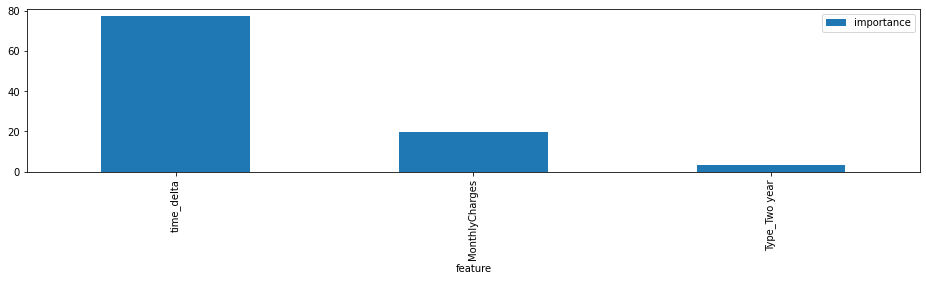

In [104]:
importances = pd.DataFrame({'feature':features_test.columns,'importance':np.round(cat.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(16, 3));

In [105]:
model_lgb = lgb.LGBMClassifier(objective='binary', n_estimators = 900, learning_rate = 0.05, max_depth = 5)
model_lgb.fit(features_upsampled, target_upsampled)
pred_test = model_lgb.predict(features_test)

0.8585643212508884
0.9241022254406006


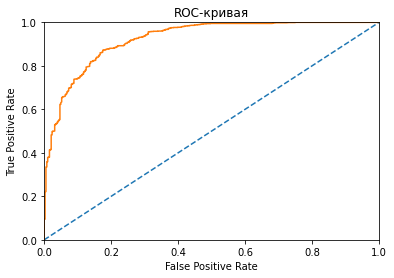

In [106]:
accuracy = accuracy_score(target_test, pred_test)
print(accuracy)

probabilities_test = model_lgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

probabilities_test = model_lgb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(roc_auc_score(target_test, probabilities_one_test))

Обе модели отработали примерно одинаково. 

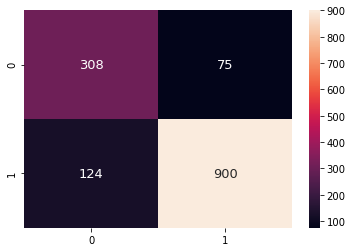

In [107]:
sns.heatmap(confusion_matrix(target_test, pred_test), annot=True, fmt='.0f', annot_kws={'fontsize':13});

у нас почти в 2 раза больше ошибок False Negative, чем False Positive

False Positive: ошибка 1-го рода, ML-модель предсказала, что в 75 случаях из нашей тестовой выборки мы не увидим что клиент собирается уйти. 

Ущерб от этого состоит в том что мы не работаем с ними (не предлогаем спец. предложений/скидок и прочих благ) чтобы клиент остался. и клиент уходит.... 

False Negative: ошибка 2-го рода – ML-модель предсказала, что в 124 случаях мы ложно отнесли клиентов, которые не хотят никуда уходить к клиентам собравшимся покинуть нашу компанию.

Ущерб от этого состоит в том что мы ошибочно полагаем что клиент хочет уйти и предлогаем ему всевозможные скидки и спец. предложения, когда как он и так себя прекрасно чувствовал и уходить не собирался. 

Как мне кажется : наиболее критично в данном случае это удержать клиентов которые хотят уйти и соответственно было бы наиболее перспективно повышать метрику.

In [108]:
precision_score(target_test, pred_test)

0.9230769230769231

In [109]:
recall_score(target_test, pred_test)

0.87890625

precision - это доля людей которые хотят уйти, которые были классифицированы как люди которые хотят уйти (другими словами, какое у нас количество «ложных срабатываний»)

recall - доля людей которые хотят от нас уйти, которых мы "вычислили". (другими словами, какое у нас количество «ложных пропусков»)

Таким образом, необходимо подсчитать что для нас выгоднее: 

    - во что бы то ни стало оставлять клиентов (остановить отток даже платя тем кто не собирался уходить)
    - не переплачивать людям которые и так наши клиенты, но как следствие повысится кол-во желающих уйти не получивших предложения о скидке.
    

## Выводы

Максимальная метрика ROC-AUC = 0.92.
    
Наиболее ценными признаками оказались: время клиента и ежемесячные отчисления. По идее, пользуясь именно этими параметрами должен быть расчитан размер индивидуального предложения для удержания клиента(например, опираясь на отношение потраченного время к потраченным деньгам).
    
Были выявлены следующие трудности:
  - отсутствие таргетного признака (0/1) в исходном датасете
  - пропуски в данных
  - дисбаланс классов
  - исходные данные были переданы не в тех форматах (например числовой в строковом формате)
  - числовые и категориальные признаки сильно коррелировали друг с другом (не имеем ввиду target)

Преодоление трудностей:
  - сгенерировал таргетный признак пользуясь данными даты входа и выхода клиента из компании. 
  - В случае когда пропусков было мало (в данном случае 11) удалил. В остальных случаях достоверно осуществить замену не представлялось возможным, а при удалении терялся очень большой объем данных, так что была осуществлена замена пропусков на букву "N".
  - с дисбалансом классов боролся увеличив "отстающий" класс
  - исправил форматы на необходимые
  - удалил коррелирующие друг с другом признаки
  
Ключевые шаги:
   - загрузка данных
   - знакомство и предварительный анализ данных
   - коррекция и приведение данных к нужной форме и содержанию
   - анализ данных
   - подготовка данных к использованию в ML
   - обучение нескольких моделей, выбор наиболее эффективных
   - исследование ключевых фичей и последующая подготовка(коррекция) данных для финального обучения
   - финальное обучение моделей-лидеров на подготовленных данных
   - исследование полученных результатов
   - выводы
   
Итоговая модель(наилучшая): CatBoostClassifier с качеством ROC-AUC = 0.926